# 基于ClusterGAN的多视图异常检测算法

In [1]:
import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import chain as ichain

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
from torch.utils.data import DataLoader, Dataset

from torchvision import datasets
import torchvision.transforms as transforms

import time
import cv2

from sklearn.preprocessing import MinMaxScaler

## 制作数据集

### 两个实验数据集，从torchvision.datasets导入


In [2]:
DATASET_FN_DICT = {
                    'mnist': datasets.MNIST,
                    'fashion-mnist': datasets.FashionMNIST
                   }
DATASET_FN_DICT

{'mnist': torchvision.datasets.mnist.MNIST,
 'fashion-mnist': torchvision.datasets.mnist.FashionMNIST}

In [3]:
dataset_list = DATASET_FN_DICT.keys()
dataset_list

dict_keys(['mnist', 'fashion-mnist'])

### 传入参数返回一个类函数

In [4]:
def get_dataset(dataset_name='mnist'):
    if dataset_name in DATASET_FN_DICT:
        fn = DATASET_FN_DICT[dataset_name]
        return fn
    else:
        raise ValueError('Invalid dataset, {}, entered. Must be '
                         'in {}'.format(dataset_name, DATASET_FN_DICT.keys()))

In [5]:
get_dataset('mnist')

torchvision.datasets.mnist.MNIST

### 传入 数据名称、数据存储路径、dataloader的批次大小、是否为训练集


In [6]:
def get_dataloader(dataset_name='mnist', data_dir='./datasets/mnist', batch_size=64, train_set=True, num_workers=1):
    dset = get_dataset(dataset_name)

    dataloader = torch.utils.data.DataLoader(
        dset(data_dir, train=train_set, download=False, transform=transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )
             ),
        num_workers=num_workers,
        batch_size=batch_size,
        shuffle=True
    )
    return dataloader

In [7]:
mnist = get_dataloader(dataset_name='mnist', data_dir='./datasets/mnist', batch_size=64, train_set=True, num_workers=1)

### 构造多视图数据：GLCM数据

In [8]:
def fast_glcm(img, vmin=0, vmax=255, nbit=8, kernel_size=5):
    """
    img: 传入的图像
    vmin: 灰度的最小值
    vmax: 灰度的最大值
    nbit： 间隔
    kernel_size: 卷积核的大小
    """
    mi, ma = vmin, vmax
    ks = kernel_size
    h,w = img.shape

    # digitize
    bins = np.linspace(mi, ma+1, nbit+1)
    gl1 = np.digitize(img, bins) - 1
    gl2 = np.append(gl1[:,1:], gl1[:,-1:], axis=1)

    # make glcm
    glcm = np.zeros((nbit, nbit, h, w), dtype=np.uint8)
    for i in range(nbit):
        for j in range(nbit):
            mask = ((gl1==i) & (gl2==j))
            glcm[i,j, mask] = 1

    kernel = np.ones((ks, ks), dtype=np.uint8)
    for i in range(nbit):
        for j in range(nbit):
            glcm[i,j] = cv2.filter2D(glcm[i,j], -1, kernel)

    glcm = glcm.astype(np.float32)
    return glcm

def fast_glcm_mean(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm mean
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    mean = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            mean += glcm[i,j] * i / (nbit)**2
    return mean

def fast_glcm_std(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm std
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    mean = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            mean += glcm[i,j] * i / (nbit)**2

    std2 = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            std2 += (glcm[i,j] * i - mean)**2

    std = np.sqrt(std2)
    return std

def fast_glcm_contrast(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    计算对比度
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    cont = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            cont += glcm[i,j] * (i-j)**2
    return cont

def fast_glcm_dissimilarity(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    计算不相似度
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    diss = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            diss += glcm[i,j] * np.abs(i-j)
    return diss

def fast_glcm_homogeneity(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    计算均匀性
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    homo = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            homo += glcm[i,j] / (1.+(i-j)**2)
    return homo

def fast_glcm_ASM(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    ASM（Angular Second Moment）和能量（Energy）
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    asm = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            asm  += glcm[i,j]**2

    ene = np.sqrt(asm)
    return asm, ene

def fast_glcm_max(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    计算GLCM的最大值（Maximum）
    '''
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    max_  = np.max(glcm, axis=(0,1))
    return max_

def fast_glcm_entropy(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    计算GLCM的熵（Entropy）
    '''
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    pnorm = glcm / np.sum(glcm, axis=(0,1)) + 1./ks**2
    ent  = np.sum(-pnorm * np.log(pnorm), axis=(0,1))
    return ent

def mnist_on_glcm():
    nbit = 8
    ks = 5
    mi, ma = 0, 255

    ori_f = './datasets/mnist/MNIST/processed/training.pt' #该数据集使用torchvision下载
    imgs, labels = torch.load(ori_f)

    glcm_mnist = []
    for img in imgs:
        img = fast_glcm_mean(img, vmin=mi, vmax=ma, nbit=nbit, ks=ks)
        glcm_mnist.append(img)
    glcm_mnist = torch.tensor(glcm_mnist)

    file = (glcm_mnist, labels)
    tar_f = './datasets/mnist/MNIST/processed/mnist_glcm.pt'
    with open(tar_f, 'wb') as f:
        torch.save(file, f)
    print('shape ', glcm_mnist.shape)
    print('glcm on mnist generate success.')

### 导入数据集 查看

In [9]:
torch.load('./datasets/mnist/MNIST/processed/mnist_glcm.pt')[0].shape

torch.Size([60000, 28, 28])

### 由原始数据生成GLCM数据
保存地址为 './datasets/mnist/MNIST/processed/mnist_glcm.pt'

In [10]:
t1 = time.time()
mnist_on_glcm()
t2 = time.time()
print('cost {}s'.format(t2 - t1))

shape  torch.Size([60000, 28, 28])
glcm on mnist generate success.
cost 60.27004909515381s


In [11]:
data_glcm = torch.load('./datasets/mnist/MNIST/processed/mnist_glcm.pt')
data_glcm[0][0].shape

torch.Size([28, 28])

In [12]:
data_ori = torch.load('./datasets/mnist/MNIST/processed/training.pt')
data_ori[0][0].shape

torch.Size([28, 28])

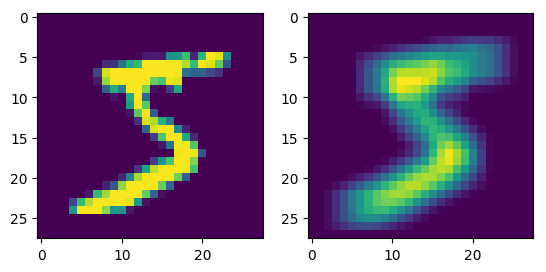

In [13]:
import matplotlib.pyplot as plt


# 创建一个包含两个子图的画布
fig, axes = plt.subplots(1, 2)

# 绘制第一个子图
axes[0].imshow(data_ori[0][0].squeeze())

# 绘制第二个子图
axes[1].imshow(data_glcm[0][0].squeeze())

# 显示图形
plt.show()

## 构造多视图数据：LBP数据

In [9]:
class LBP:
    def __init__(self):
        #revolve_map为旋转不变模式的36种特征值从小到大进行序列化编号得到的字典
        self.revolve_map={0:0, 1:1, 3:2, 5:3, 7:4, 9:5, 11:6, 13:7, 15:8, 17:9, 19:10,
                          21:11, 23:12, 25:13, 27:14, 29:15, 31:16, 37:17, 39:18, 43:19, 45:20,
                          47:21, 51:22, 53:23, 55:24, 59:25, 61:26, 63:27, 85:28, 87:29, 91:30,
                          95:31, 111:32, 119:33, 127:34, 255:35}
        
        #uniform_map为等价模式的58种特征值从小到大进行序列化编号得到的字典
        self.uniform_map={0:0, 1:1, 2:2, 3:3, 4:4, 6:5, 7:6, 8:7, 12:8, 14:9, 15:10,
                          16:11, 24:12, 28:13, 30:14, 31:15, 32:16, 48:17, 56:18, 60:19, 62:20,
                          63:21, 64:22, 96:23, 112:24, 120:25, 124:26, 126:27, 127:28, 128:29, 129:30,
                          131:31, 135:32, 143:33, 159:34, 191:35, 192:36, 193:37, 195:38, 199:39, 207:40,
                          223:41,224:42,225:43,227:44,231:45,239:46,240:47,241:48,
                          243:49, 247:50, 248:51, 249:52, 251:53, 252:54, 253:55, 254:56, 255:57}

    # 将图像载入，并转化为灰度图，获取图像灰度图的像素信息   
    def describe(self,image):
        image_array = np.array(Image.open(image).convert('L'))
        return image_array
    
    # 图像的LBP原始特征计算算法：将图像指定位置的像素与周围8个像素比较
    # 比中心像素大的点赋值为1，比中心像素小的赋值为0，返回得到的二进制序列
    def calute_basic_lbp(self, image_array, i, j):
        sum=[]
        if image_array[i-1, j-1] > image_array[i, j]:
            sum.append(1)
        else:
            sum.append(0)
            
        if image_array[i-1, j] > image_array[i, j]:
            sum.append(1)
        else:
            sum.append(0)
        
        if image_array[i-1, j+1] > image_array[i, j]:
            sum.append(1)
        else:
            sum.append(0)
        
        if image_array[i, j-1] > image_array[i, j]:
            sum.append(1)
        else:
            sum.append(0)
        
        if image_array[i, j+1] > image_array[i, j]:
            sum.append(1)
        else:
            sum.append(0)
        
        if image_array[i+1, j-1] > image_array[i, j]:
            sum.append(1)
        else:
            sum.append(0)
        
        if image_array[i+1, j] > image_array[i, j]:
            sum.append(1)
        else:
            sum.append(0)
        
        if image_array[i+1, j+1] > image_array[i, j]:
            sum.append(1)
        else:
            sum.append(0)
        return sum
    
    #获取二进制序列进行不断环形旋转得到新的二进制序列的最小十进制值
    def get_min_for_revolve(self,arr): 
        values=[]
        circle=arr
        circle.extend(arr)
        for i in range(0,8):
            j = 0
            sum = 0
            bit_num = 0
            while j < 8:
                sum += circle[i+j]<<bit_num
                bit_num += 1
                j += 1
            values.append(sum)
        return min(values)

    # 获取值r的二进制中1的位数
    def calc_sum(self,r):
        num = 0
        while(r):
            r &= (r-1)
            num += 1
        return num

    # 获取图像的LBP原始模式特征
    def lbp_basic(self,image_array):
        basic_array = np.zeros(image_array.shape, np.uint8)
        width = image_array.shape[0]
        height = image_array.shape[1]
        for i in range(1, width-1):
            for j in range(1, height-1):
                sum = self.calute_basic_lbp(image_array, i, j)
                bit_num=0
                result=0
                for s in sum:
                    result += s<<bit_num
                    bit_num += 1
                basic_array[i, j] = result
        return basic_array

    # 获取图像的LBP旋转不变模式特征
    def lbp_revolve(self, image_array):
        revolve_array = np.zeros(image_array.shape, np.uint8)
        width = image_array.shape[0]
        height = image_array.shape[1]
        for i in range(1, width-1):
            for j in range(1, height-1):
                sum = self.calute_basic_lbp(image_array, i, j)
                revolve_key = self.get_min_for_revolve(sum)
                revolve_array[i, j] = self.revolve_map[revolve_key]
        return revolve_array

    # 获取图像的LBP等价模式特征
    def lbp_uniform(self,image_array):
        uniform_array=np.zeros(image_array.shape, np.uint8)
        basic_array=self.lbp_basic(image_array)
        width=image_array.shape[0]
        height=image_array.shape[1]

        for i in range(1,width-1):
            for j in range(1,height-1):
                 k= basic_array[i,j]<<1
                 if k>255:
                     k=k-255
                 xor=basic_array[i, j]^k
                 num=self.calc_sum(xor)
                 if num<=2:
                     uniform_array[i, j]=self.uniform_map[basic_array[i, j]]
                 else:
                     uniform_array[i, j]=58
        return uniform_array
    
    #获取图像的LBP旋转不变等价模式特征
    def lbp_revolve_uniform(self, image_array):
        uniform_revolve_array = np.zeros(image_array.shape, np.uint8)
        basic_array=self.lbp_basic(image_array)
        width = image_array.shape[0]
        height = image_array.shape[1]
        for i in range(1, width-1):
            for j in range(1, height-1):
                 k = basic_array[i,j]<<1
                 if k > 255:
                     k = k-255
                 xor = basic_array[i,j]^k
                 num = self.calc_sum(xor)
                 if num <= 2:
                     uniform_revolve_array[i, j] = self.calc_sum(basic_array[i, j])
                 else:
                     uniform_revolve_array[i, j] = 9
        return uniform_revolve_array

    # 绘制指定维数和范围的图像灰度归一化统计直方图
    def show_hist(self, img_array, im_bins, im_range):
        hist = cv2.calcHist([img_array], [0], None, im_bins, im_range)
        hist = cv2.normalize(hist, None).flatten()
        plt.plot(hist, color = 'r')
        plt.xlim(im_range)
        plt.show()
        
    # 绘制图像原始LBP特征的归一化统计直方图  
    def show_basic_hist(self,img_array):
        self.show_hist(img_array, [256], [0,256])
        
    # 绘制图像旋转不变LBP特征的归一化统计直方图     
    def show_revolve_hist(self, img_array):
        self.show_hist(img_array, [36], [0,36])

    # 绘制图像等价模式LBP特征的归一化统计直方图     
    def show_uniform_hist(self,img_array):
        self.show_hist(img_array, [60], [0,60])
        
    # 绘制图像旋转不变等价模式LBP特征的归一化统计直方图     
    def show_revolve_uniform_hist(self, img_array):
        self.show_hist(img_array, [10], [0,10])

    #显示图像
    def show_image(self, image_array):
        plt.imshow(image_array)
        plt.show()

In [10]:
def lbp_on_mnist():
    # Load
    ori_f = './datasets/mnist/MNIST/processed/training.pt'
    imgs, labels = torch.load(ori_f)

    # feat
    lbp = LBP()
    lbp_imgs = []
    for img in imgs:
        lbp_img = lbp.lbp_revolve_uniform(img.numpy())
        lbp_imgs.append(lbp_img)
    lbp_imgs = torch.tensor(lbp_imgs)

    # save
    file = (lbp_imgs, labels)
    tar_f = './datasets/mnist/MNIST/processed/mnist_lbp.pt'
    with open(tar_f, 'wb') as f:
        torch.save(file, f)
    print('shape ', lbp_imgs.shape)
    print('lbp on mnist generate success.')

In [16]:
t1 = time.time()
lbp_on_mnist()
t2 = time.time()
print('cost {}s'.format(t2 - t1))

shape  torch.Size([60000, 28, 28])
lbp on mnist generate success.
cost 265.06121945381165s


In [17]:
data_lbp = torch.load('./datasets/mnist/MNIST/processed/mnist_lbp.pt')
data_lbp[0][0].shape

torch.Size([28, 28])

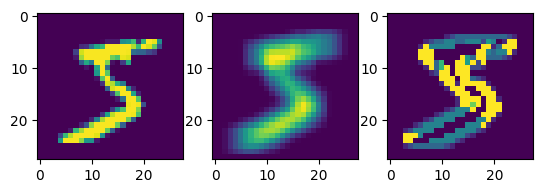

In [18]:
import matplotlib.pyplot as plt


# 创建一个包含两个子图的画布
fig, axes = plt.subplots(1, 3)

# 绘制第一个子图
axes[0].imshow(data_ori[0][0].squeeze())

# 绘制第二个子图
axes[1].imshow(data_glcm[0][0].squeeze())

# 绘制第三个子图
axes[2].imshow(data_lbp[0][0].squeeze())

# 显示图形
plt.show()

### 将上述提取的特征进行重构

In [11]:
# MNIST数据集迭代器
class MNISTDataset(Dataset):
    # 视图地址 ./datasets/mnist/MNIST/processed
    feat1v_f = './datasets/mnist/MNIST/processed/mnist_{}.pt'
    feat2v_f = './datasets/mnist/MNIST/processed/mnist_{}_{}.pt'
    feat3v_f = './datasets/mnist/MNIST/processed/mnist_{}_{}_{}.pt'
    
    # 异常数据视图地址
    anom_feat2v_f = './datasets/mnist/MNIST/processed/mnist_{}_{}_anom{}.pt'
    anom_feat3v_f = './datasets/mnist/MNIST/processed/mnist_{}_{}_{}_anom{}.pt'
    # 标签
    feat_list = {'ori', 'lbp', 'glcm'}
    anom_list = {'015', '005', '001', '005_0', '005_20', '005_40', '005_60', '005_80', '005_100'}

    def __init__(self, rt=True, anom='', feat1='ori', feat2='lbp', feat3=''):
        if rt:
            pass
        if feat3 == '':
            self.view = 2
            if anom and anom in self.anom_list:
                self.data1, self.data2, self.labels = torch.load(self.anom_feat2v_f.format(feat1, feat2, anom))
            else:
                self.data1, self.data2, self.labels = torch.load(self.feat2v_f.format(feat1, feat2))
        else:
            self.view = 3
            if anom and anom in self.anom_list:
                self.data1, self.data2, self.data3, self.labels = torch.load(
                    self.anom_feat3v_f.format(feat1, feat2, feat3, anom))
            else:
                self.data1, self.data2, self.data3, self.labels = torch.load(self.feat3v_f.format(feat1, feat2, feat3))

    def __getitem__(self, index):
        if self.view == 2:
            data1, data2, label = self.data1[index], self.data2[index], self.labels[index]
            return data1, data2, label
        else:
            data1, data2, data3, label = self.data1[index], self.data2[index], self.data3[index], self.labels[index]
            return data1, data2, data3, label

    def __len__(self):
        return len(self.labels)

    def gen(self, feat1='lbp', feat2='glcm', feat3=''):
        """
        根据需要选择生成2view合集 lbp_glcm
        """
        if feat3 == '':
            data1, _ = torch.load(self.feat1v_f.format(feat1))
            data2, _ = torch.load(self.feat1v_f.format(feat2))
            scaler = MinMaxScaler()
            trans = transforms.Compose([
                transforms.ToTensor()
            ])
            res_data1 = torch.empty(data1.shape)
            res_data2 = torch.empty(data2.shape)
            for i in range(len(data1)):
                res_data1[i] = trans(scaler.fit_transform(data1[i]))
                res_data2[i] = trans(scaler.fit_transform(data2[i]))
            res_data1.unsqueeze_(dim=1)
            res_data2.unsqueeze_(dim=1)
            file = (res_data1, res_data2, _)
            with open(self.feat2v_f.format(feat1, feat2), 'wb') as f:
                torch.save(file, f)
            print('gen {} success.'.format(self.feat2v_f.format(feat1, feat2)))
        else:
            data1, _ = torch.load(self.feat1v_f.format(feat1))
            data2, _ = torch.load(self.feat1v_f.format(feat2))
            data3, _ = torch.load(self.feat1v_f.format(feat3))
            scaler = MinMaxScaler()
            trans = transforms.Compose([
                transforms.ToTensor()
            ])
            res_data1 = torch.empty(data1.shape)
            res_data2 = torch.empty(data2.shape)
            res_data3 = torch.empty(data3.shape)
            for i in range(len(data1)):
                res_data1[i] = trans(scaler.fit_transform(data1[i]))
                res_data2[i] = trans(scaler.fit_transform(data2[i]))
                res_data3[i] = trans(scaler.fit_transform(data3[i]))
            res_data1.unsqueeze_(dim=1)
            res_data2.unsqueeze_(dim=1)
            res_data3.unsqueeze_(dim=1)
            file = (res_data1, res_data2, res_data3, _)
            with open(self.feat3v_f.format(feat1, feat2, feat3), 'wb') as f:
                torch.save(file, f)
            print('gen {} success.'.format(self.feat3v_f.format(feat1, feat2, feat3)))

    def gen_cls_attr_ca_anom(self, anom='', feat1='lbp', feat2='glcm', feat3=''):
        """
        类异常 + 属性异常 + 类属性
        """
        feature_num = 60
        if feat3 == '':
            data1, data2, labels = torch.load(self.feat2v_f.format(feat1, feat2))
        else:
            data1, data2, data3, labels = torch.load(self.feat3v_f.format(feat1, feat2, feat3))
        if anom in self.anom_list:
            if '015' == anom:
                anom_num = feature_num * 0.15
            elif '005' == anom:
                anom_num = feature_num * 0.05
            elif '001' == anom:
                anom_num = feature_num * 0.01
            else:
                raise ValueError('ratio not exist.')
            anom_index = random.sample(range(feature_num), int(anom_num))  # 015 - 9000/3, 005 - 3000/3, 001 - 600/3
            cls_anom, attr_anom, ca_anom = np.array_split(np.array(anom_index), 3)
            print('anom index ', anom_index)
            print('anom num ', len(anom_index))
        else:
            raise ValueError('anom not exist.')
        torch.zero_(labels).type(dtype=torch.int)
        for i in cls_anom:
            temp = torch.clone(data1[i])
            data1[i] = data1[i + feature_num]
            data1[i + feature_num] = data1[i + feature_num * 2]
            data1[i + feature_num * 2] = temp
            labels[i], labels[i + feature_num], labels[i + feature_num * 2] = 1, 1, 1
        for i in attr_anom:
            data1[i] = torch.randn(data1[i].shape)
            data1[i + feature_num] = torch.randn(data1[i].shape)
            data1[i + feature_num * 2] = torch.randn(data1[i].shape)
            labels[i], labels[i + feature_num], labels[i + feature_num * 2] = 1, 1, 1
        for i in ca_anom:
            temp = torch.clone(data1[i])
            data1[i] = data1[i + feature_num]
            data1[i + feature_num] = data1[i + feature_num * 2]
            data1[i + feature_num * 2] = temp
            data2[i] = torch.randn(data2[i].shape)
            data2[i + feature_num] = torch.randn(data2[i].shape)
            data2[i + feature_num * 2] = torch.randn(data2[i].shape)
            labels[i], labels[i + feature_num], labels[i + feature_num * 2] = 1, 1, 1

        if feat3 == '':
            file = (data1, data2, labels)
            with open(self.anom_feat2v_f.format(feat1, feat2, anom), 'wb') as f:
                torch.save(file, f)
                print('anom generate success in {}'.format(self.anom_feat2v_f.format(feat1, feat2, anom)))
        else:
            file = (data1, data2, data3, labels)
            with open(self.anom_feat3v_f.format(feat1, feat2, feat3, anom), 'wb') as f:
                torch.save(file, f)
                print('anom generate success in {}'.format(self.anom_feat3v_f.format(feat1, feat2, feat3, anom)))

    def gen_cls_attr(self, anom='', feat1='lbp', feat2='glcm', feat3=''):
        """
        类异常 + 属性异常（按不同比例）
        """
        feature_num = 20000  # 200 -> 60; 60000 -> 20000
        if feat3 == '':
            data1, data2, labels = torch.load(self.feat2v_f.format(feat1, feat2))
        else:
            data1, data2, data3, labels = torch.load(self.feat3v_f.format(feat1, feat2, feat3))
        if anom in self.anom_list:
            if '005' in anom:
                anom_num = feature_num * 0.05
                if '_0' in anom:
                    cls_num = anom_num * 0
                    attr_num = anom_num - cls_num
                elif '_20' in anom:
                    cls_num = anom_num * 0.2
                    attr_num = anom_num - cls_num
                elif '_40' in anom:
                    cls_num = anom_num * 0.4
                    attr_num = anom_num - cls_num
                elif '_60' in anom:
                    cls_num = anom_num * 0.6
                    attr_num = anom_num - cls_num
                elif '_80' in anom:
                    cls_num = anom_num * 0.8
                    attr_num = anom_num - cls_num
                elif '_100' in anom:
                    cls_num = anom_num * 1
                    attr_num = anom_num - cls_num
                else:
                    raise ValueError('ratio not exist.')
            else:
                raise ValueError('ratio not exist.')
            anom_index = random.sample(range(feature_num), int(anom_num))  # 015 - 9000/3, 005 - 3000/3, 001 - 600/3
            cls_anom = anom_index[:int(cls_num)]
            attr_anom = anom_index[int(cls_num):]
            print('anom index ', anom_index)
            print('cls anom ', cls_anom)
            print('cls num ', cls_num)
            print('cls len ', len(cls_anom))
            print('attr anom ', attr_anom)
            print('attr num ', attr_num)
            print('attr len ', len(attr_anom))
            print('anom num ', len(anom_index))
        else:
            raise ValueError('anom not exist.')
        torch.zero_(labels).type(dtype=torch.int)
        for i in cls_anom:
            # 通过交换数据和修改标签来实现类异常
            temp = torch.clone(data1[i])
            data1[i] = data1[i + feature_num]
            data1[i + feature_num] = data1[i + feature_num * 2]
            data1[i + feature_num * 2] = temp
            labels[i], labels[i + feature_num], labels[i + feature_num * 2] = 1, 1, 1
        for i in attr_anom:
            # 使用高斯噪声生成
            data1[i] = torch.randn(data1[i].shape)
            data1[i + feature_num] = torch.randn(data1[i].shape)
            data1[i + feature_num * 2] = torch.randn(data1[i].shape)
            labels[i], labels[i + feature_num], labels[i + feature_num * 2] = 1, 1, 1

        if feat3 == '':
            file = (data1, data2, labels)
            with open(self.anom_feat2v_f.format(feat1, feat2, anom), 'wb') as f:
                torch.save(file, f, _use_new_zipfile_serialization=False)
                print('anom generate success in {}'.format(self.anom_feat2v_f.format(feat1, feat2, anom)))
        else:
            file = (data1, data2, data3, labels)
            with open(self.anom_feat3v_f.format(feat1, feat2, feat3, anom), 'wb') as f:
                torch.save(file, f, _use_new_zipfile_serialization=False)
                print('anom generate success in {}'.format(self.anom_feat3v_f.format(feat1, feat2, feat3, anom)))

In [12]:
ds = MNISTDataset()

### 生成 ori_lbp联合数据

In [21]:
t1 = time.time()
ds.gen('ori','lbp')
t2 = time.time()
print('cost {}s'.format(t2 - t1))

gen ./datasets/mnist/MNIST/processed/mnist_ori_lbp.pt success.
cost 18.675711631774902s


### 生成 ori_glcm联合数据

In [22]:
t1 = time.time()
ds.gen('ori','glcm')
t2 = time.time()
print('cost {}s'.format(t2 - t1))

gen ./datasets/mnist/MNIST/processed/mnist_ori_glcm.pt success.
cost 19.2883141040802s


### 生成 lbp_glcm联合数据

In [23]:
t1 = time.time()
ds.gen('lbp','glcm')
t2 = time.time()
print('cost {}s'.format(t2 - t1))

gen ./datasets/mnist/MNIST/processed/mnist_lbp_glcm.pt success.
cost 19.280882835388184s


### 生成异常数据
实验中我们考虑了三种类型的异常值，即**类异常值**、**属性异常值**和**类-属性异常值**。  
为了生成离群点，我们根据设定的离群点比例随机生成一个离群点索引列表。  
随后，根据生成的离群点索引列表，去替换数据集中的正常数据。  
对于类离群点，我们将不属于同一类别的样本对中的$[\frac{V}{2}]$个视图中的特征进行交换，保持其他视图中的特征不变。  

**简而言之就是，在两个视图的情况下，假定为LBP和GLCM两个特征，我们有样本$x_{lbp}[1]$和$x_{GLCM}[1]$，标签为1，  
我们固定$x_{lbp}[1]$，将$x_{GLCM}[1]$强制更新为$x_{GLCM}[2]$，其中样本$x[2]$的标签为2**

对于属性离群者，我们将样本中的所有视图的特征转换成高斯噪声。  

**简而言之，属性离群就是该样本哪个类别都不属于，远离各类中心，因此我们直接将其变为高斯噪声即可。**


对于类属性离群值，我们首先将不属于同一类别的样本对中的$[\frac{V}{2}]$个视图中的特征进行交换，
对$[\frac{V}{2}]$个视图中的特征转换成高斯噪声。   

**简而言之，一个进行类离群，一个进行属性离群。**

In [13]:
ds.gen_cls_attr(anom='005_100', feat1='lbp', feat2='glcm') ## 生成类异常 5%的数据为异常 其中100%为类异常

anom index  [5832, 5682, 16590, 14886, 10118, 7171, 2139, 10512, 19213, 246, 11212, 16969, 6897, 19644, 7301, 11795, 9998, 229, 8246, 10286, 11137, 520, 17159, 8002, 12217, 11190, 18880, 2778, 14092, 11460, 13901, 15701, 10177, 7318, 6847, 5665, 5146, 15499, 8503, 1514, 537, 13768, 14015, 15831, 16250, 18972, 15265, 15321, 7482, 500, 19659, 13506, 11761, 746, 6544, 4424, 5005, 12816, 6202, 11887, 16328, 1109, 3746, 6236, 15704, 16142, 3680, 6747, 7786, 8953, 11389, 11452, 4582, 10890, 12499, 8277, 12803, 12036, 15620, 357, 12298, 19224, 5472, 1945, 10586, 14400, 18002, 12055, 276, 5461, 11355, 3054, 5779, 8494, 8579, 6803, 6329, 15019, 10835, 4026, 11136, 12972, 5434, 3190, 13654, 2788, 16779, 14114, 8524, 16456, 15967, 17952, 11479, 5129, 11364, 13087, 10478, 13795, 8671, 5972, 6285, 13708, 2960, 11209, 36, 11876, 11443, 2016, 11252, 1062, 3644, 18907, 10969, 7584, 12900, 14763, 3421, 6035, 9042, 18029, 15929, 7806, 18887, 17363, 17721, 9909, 3969, 14235, 2746, 793, 14592, 12811, 7091

In [14]:
data = torch.load("./datasets/mnist/MNIST/processed/mnist_lbp_glcm_anom005_100.pt")

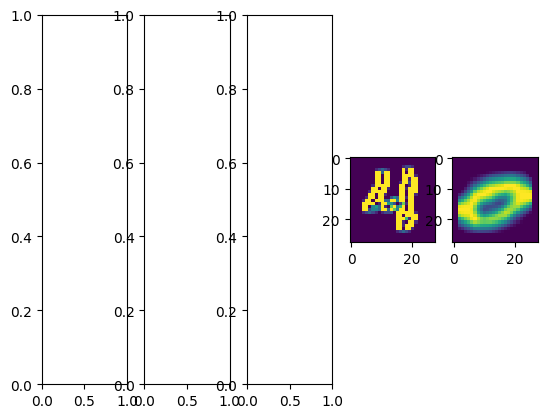

In [17]:
# 创建一个包含两个子图的画布
fig, axes = plt.subplots(1, 5)

# axes[0].imshow(data_ori[0][7].squeeze())
# axes[1].imshow(data_glcm[0][7].squeeze())
# axes[2].imshow(data_lbp[0][7].squeeze())
axes[3].imshow(data[0][13545].squeeze()) # ori上变化
axes[4].imshow(data[1][13545].squeeze())


# 显示图形
plt.show()

In [18]:
ds.gen_cls_attr(anom='005_0', feat1='lbp', feat2='glcm') ## 生成类异常 5%的数据为异常 其中100%为类异常

anom index  [6443, 9114, 17514, 1584, 15036, 15309, 11871, 1849, 4753, 18302, 12215, 8601, 18667, 10341, 2099, 10068, 10299, 11867, 8528, 13333, 18296, 6335, 9030, 13465, 6142, 11329, 14553, 6501, 11892, 7548, 16259, 4207, 17259, 17734, 18066, 8465, 3769, 11248, 14440, 13317, 8117, 17510, 17923, 19941, 14299, 11372, 17679, 15762, 13241, 12856, 13178, 6547, 19339, 7261, 8433, 3062, 14733, 3080, 14083, 5095, 3658, 15494, 634, 7208, 244, 18551, 4268, 9801, 2328, 18353, 10010, 1321, 19475, 3161, 15485, 19771, 8262, 19190, 13180, 5967, 14932, 4624, 7584, 15915, 15855, 10227, 2621, 12323, 6070, 4475, 19229, 15757, 12914, 10996, 821, 8127, 8698, 5463, 14393, 15257, 9330, 10701, 17735, 11763, 12987, 18735, 2749, 1260, 2858, 15512, 1758, 11900, 6475, 2435, 10892, 19548, 17594, 9856, 17270, 6712, 1563, 3829, 2177, 6935, 17439, 12015, 8420, 17123, 7858, 11658, 16450, 9768, 5378, 10173, 10802, 6583, 13841, 11633, 18609, 4960, 10105, 11714, 18877, 14146, 11387, 5551, 13190, 19493, 5039, 350, 14351,

In [21]:
data = torch.load("./datasets/mnist/MNIST/processed/mnist_lbp_glcm_anom005_0.pt")

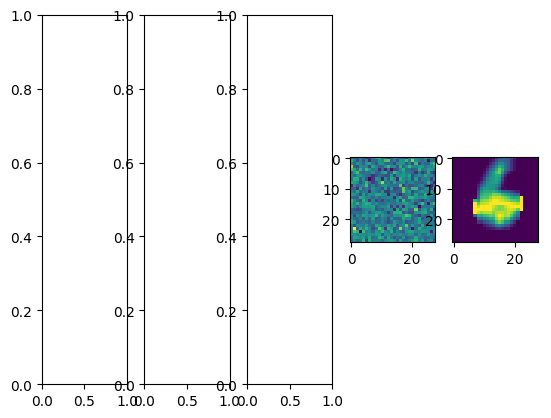

In [22]:
# 创建一个包含两个子图的画布
fig, axes = plt.subplots(1, 5)

# axes[0].imshow(data_ori[0][5363].squeeze())
# axes[1].imshow(data_glcm[0][5363].squeeze())
# axes[2].imshow(data_lbp[0][5363].squeeze())
axes[3].imshow(data[0][2296].squeeze()) # ori上变化
axes[4].imshow(data[1][2296].squeeze())


# 显示图形
plt.show()

## 模型训练阶段

In [23]:
device_id = 0 # GPU编号
wass_metric = True# 是否使用W-GAN
n_epochs = 200  # epoch
batch_size = 64  # batch
# mnist_ori_glcm_anom005_100
c = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = 'mnist'
feat1 = 'lbp'  # view1特征种类
feat2 = 'glcm'  # view2特征种类
feat3 = ''  # view3特征种类
anom = '005_0'  # 异常比例 {'015', '005', '001', '005_0', '005_20', '005_40', '005_60', '005_80', '005_100'}

lr1 = 1e-4  # 步长
lr2 = 1e-4  # 步长
lr3 = 1e-4  # 步长
b1 = 0.5  # 优化器参数
b2 = 0.9  # 优化器参数
decay = 2.5 * 1e-5  # 优化器参数
n_skip_iter = 1  # 训练n次D 训练1次G+E

# Latent space info
view_num = 2
latent_dim = 30  # 用于生成图片的隐空间向量dim
n_c = 10  # 聚类个数

betan1 = 10  # 计算zn1损失时对应的参数
betan2 = 10  # 计算zn2损失时对应的参数
betan3 = 10  # 计算zn2损失时对应的参数
betac1 = 10  # 计算zc1损失时对应的参数
betac2 = 10  # 计算zc2损失时对应的参数
betac3 = 10  # 计算zc2损失时对应的参数

In [24]:
mtype = 'van'
if wass_metric:
    mtype = 'wass'

sep_und = '_'
run_name_comps = [feat1, feat2, anom, mtype, 'e%i' % n_epochs, 'b%i' % batch_size, 'l%i' % latent_dim,
                  'betan1%.3f' % betan1, 'betac1%.3f' % betac1, 'betan2%.3f' % betan2, 'betac2%.3f' % betac2]
run_name = sep_und.join(run_name_comps)

In [25]:
run_name

'lbp_glcm_005_0_wass_e200_b64_l30_betan110.000_betac110.000_betan210.000_betac210.000'

In [26]:
# 生成输出的文件夹路径
run_dir = os.path.join('./out', run_name)  # ./out/iepoch
os.makedirs(run_dir, exist_ok=True)

print('\nResults to be saved in directory %s\n' % (run_dir))


Results to be saved in directory ./out/lbp_glcm_005_0_wass_e200_b64_l30_betan110.000_betac110.000_betan210.000_betac210.000



In [27]:
# 对于MNIST数据集
x_shape = (1, 28, 28) #[channel, size, size]

# 加载cuda 
cuda = True if torch.cuda.is_available() else False
if cuda: 
    torch.cuda.set_device(device_id)

In [28]:
# binary-cross-entropy
bce_loss1 = torch.nn.BCELoss()
bce_loss2 = torch.nn.BCELoss()
# cross-entropy
xe_loss1 = torch.nn.CrossEntropyLoss()
xe_loss2 = torch.nn.CrossEntropyLoss()
# mean-square-loss
mse_loss1 = torch.nn.MSELoss()
mse_loss2 = torch.nn.MSELoss()

In [29]:
class Reshape(nn.Module):
    def __init__(self, shape=None):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        if self.shape is None:
            return x.view(x.size(0), -1)  # 将x展平成一维向量
        else:
            return x.view(x.size(0), *self.shape)

    def extra_repr(self):
        return 'shape={}'.format(
            self.shape
        )

In [30]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [31]:
class Generator_CNN(nn.Module):
    def __init__(self, latent_dim, n_c, x_shape):
        super(Generator_CNN, self).__init__()
        self.name = 'generator'
        self.latent_dim = latent_dim
        self.n_c = n_c
        self.x_shape = x_shape
        self.ishape = (128, 7, 7)
        self.iels = int(np.prod(self.ishape))
        self.model = nn.Sequential(
            nn.Linear(self.latent_dim + self.n_c, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, self.iels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(self.iels),
            Reshape(self.ishape),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=False),
            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, bias=True),
            nn.Sigmoid()
        )
        initialize_weights(self)

    def forward(self, zn, zc):
        z = torch.cat((zn, zc), 1)
        x_gen = self.model(z)
        x_gen = x_gen.view(x_gen.size(0), *self.x_shape)
        return x_gen


class Encoder_CNN(nn.Module):
    def __init__(self, latent_dim, n_c):
        super(Encoder_CNN, self).__init__()
        self.name = 'encoder'
        self.channels = 1
        self.latent_dim = latent_dim
        self.n_c = n_c
        self.cshape = (128, 5, 5)
        self.iels = int(np.prod(self.cshape))
        self.lshape = (self.iels, )
        self.model = nn.Sequential(
            nn.Conv2d(self.channels, 64, 4, stride=2, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            Reshape(self.lshape),
            nn.Linear(self.iels, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, latent_dim + n_c)
        )
        initialize_weights(self)

    def forward(self, in_feat):
        z_img = self.model(in_feat)
        z = z_img.view(z_img.shape[0], -1)
        zn = z[:, :self.latent_dim]
        zc_logits = z[:, self.latent_dim:]
        zc = softmax(zc_logits)
        return zn, zc, zc_logits


class Discriminator_CNN(nn.Module):
    def __init__(self, wass_metric=True):
        super(Discriminator_CNN, self).__init__()
        self.name = 'discriminator'
        self.channels = 1
        self.cshape = (128, 5, 5)
        self.iels = int(np.prod(self.cshape))
        self.lshape = (self.iels, )
        self.wass = wass_metric

        self.model = nn.Sequential(
            nn.Conv2d(self.channels, 64, 4, stride=2, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            Reshape(self.lshape),
            nn.Linear(self.iels, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
        )

        if (not self.wass):
            self.model = nn.Sequential(self.model, torch.nn.Sigmoid())
        initialize_weights(self)

    def forward(self, img):
        validity = self.model(img)
        return validity

In [32]:
class MultiNet_mnist(nn.Module):
    def __init__(self, view_num, latent_dim, cls_num, x_shape, wass=True):
        super().__init__()
        self.view_num = view_num
        self.latent_dim = latent_dim
        self.cls_num = cls_num

        self.Gs = nn.ModuleList(
            [Generator_CNN(latent_dim=latent_dim, n_c=cls_num, x_shape=x_shape) for _ in range(view_num)])
        
        self.Ds = nn.ModuleList(
            [Discriminator_CNN(wass_metric=wass) for _ in range(view_num)])
        
        self.Es = nn.ModuleList(
            [Encoder_CNN(latent_dim=latent_dim, n_c=cls_num) for _ in range(view_num)])

    def forward(self, zn=None, zc=None, data=None, mode='G'):
        if mode == 'G':
            g = []
            for i in range(self.view_num):
                g.append(self.Gs[i](zn[i], zc[i]))
            return g
        elif mode == 'D':
            d = []
            for i in range(self.view_num):
                d.append(self.Ds[i](data[i]))
            return d
        elif mode == 'E':
            e = []
            for i in range(self.view_num):
                e.append(self.Es[i](data[i]))
            return e
        else:
            raise ValueError('err mode')

In [33]:
net = MultiNet_mnist(view_num=2, latent_dim=latent_dim, cls_num=n_c, x_shape=x_shape, wass=wass_metric)

In [34]:
print(net)

MultiNet_mnist(
  (Gs): ModuleList(
    (0): Generator_CNN(
      (model): Sequential(
        (0): Linear(in_features=40, out_features=1024, bias=True)
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Linear(in_features=1024, out_features=6272, bias=True)
        (4): LeakyReLU(negative_slope=0.2, inplace=True)
        (5): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Reshape(shape=(128, 7, 7))
        (7): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): LeakyReLU(negative_slope=0.2)
        (10): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (11): Sigmoid()
      )
    )
    (1): Generator_CNN(
      (model): Sequential(
        (0): Linear(in_features=4

In [35]:
if cuda:
    net.cuda()
    bce_loss1.cuda()
    bce_loss2.cuda()
    xe_loss1.cuda()
    xe_loss2.cuda()
    mse_loss1.cuda()
    mse_loss2.cuda()

In [36]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [37]:
def dataloader_v2(dataset='mnist', anom='005', feat1='lbp', feat2='glcm', batch=64, shuffle=False):
    if dataset == 'mnist':
        return DataLoader(MNISTDataset(anom=anom, feat1=feat1, feat2=feat2), batch_size=batch, shuffle=shuffle)
    elif dataset == 'fashionmnist':
        return DataLoader(FashionMNISTDataset(anom=anom, feat1=feat1, feat2=feat2), batch_size=batch, shuffle=shuffle)
    else:
        raise ValueError('no dataset')

In [38]:
# 加载Mutil-view-two-dataset
loader = dataloader_v2(dataset=dataset, anom=anom, feat1=feat1, feat2=feat2, batch=batch_size, shuffle=True)

In [39]:
# 联合优化 G E，生成器 和 编码器
GsEs_chain1 = ichain(net.Gs[0].parameters(), net.Es[0].parameters())
GsEs_chain2 = ichain(net.Gs[1].parameters(), net.Es[1].parameters())
optimizer_GsEs1 = torch.optim.Adam(GsEs_chain1, lr=lr1, betas=(b1, b2), weight_decay=decay)
optimizer_GsEs2 = torch.optim.Adam(GsEs_chain2, lr=lr2, betas=(b1, b2), weight_decay=decay)

In [40]:
 # 单独优化 D， 判别器 
optimizer_Ds1 = torch.optim.Adam(net.Ds[0].parameters(), lr=lr1, betas=(b1, b2))
optimizer_Ds2 = torch.optim.Adam(net.Ds[1].parameters(), lr=lr2, betas=(b1, b2))

In [41]:
#使用列表记录损失
eval_ge_loss1 = []
eval_ge_loss2 = []
eval_d_loss1 = []
eval_d_loss2 = []
eval_auc = []

In [42]:
# Sample a random latent space vector
# 随机生成噪声 隐空间上的向量
def sample_z(shape=64, latent_dim=10, n_c=10, fix_class=-1, req_grad=False):  # shape就是img[0], 也就是batch_size

    assert (fix_class == -1 or (fix_class >= 0 and fix_class < n_c)), "Requested class %i outside bounds." % fix_class

    # 将Tensor放到GPU上
    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

    # Sample noise as generator input, zn
    # 生成噪声zn
    """
    Tensor是基本数据类型，Variable是对Tensor的封装。
    Variable引入了计算图实现自动求导，backward(). Pytorch默认只进行一次自动求导，然后将计算图丢弃，如果想要多次求导需要retain_graph来保留计算图。
    """
    zn = Variable(Tensor(0.75 * np.random.normal(0, 1, (shape, latent_dim))), requires_grad=req_grad)

    ######### zc, zc_idx variables with grads, and zc to one-hot vector
    # Pure one-hot vector generation
    # 生成噪声zc 和 zc_idx
    zc_FT = Tensor(shape, n_c).fill_(0)  # FloatTensor类型的张量，是empty的特例。初始化形状，用0填充。torch.zeros
    zc_idx = torch.empty(shape, dtype=torch.long)  # empty创建任意类型的张量，使用参数才可以确定形状和数据类型。
    """
    scatter(dim, index, src)
    将src中的数据根据index中的索引按照dim的方向填入self.
    
    index必须是LongTensor类型，所以初始化zc_idx的时候创建的是torch.long类型的Tensor。
    
    Ex:
    class_num = 10
    batch_size = 4
    label = torch.LongTensor(batch_size, 1).random_() % class_num
    #tensor([[6],
    #        [0],
    #        [3],
    #        [2]])
    torch.zeros(batch_size, class_num).scatter_(1, label, 1)
    #tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
    #        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    #        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
    #        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])
    """

    """
    unsqueeze(dim)
    扩展维度
    
    [0, 1, 2, 3]
    在dim上扩展，如dim=0在0维上加1。[[0, 1, 2, 3]]
    dim=1在1维上加1[[0],
                    [1],
                    [2],
                    [3]]
    dim=-1是在最后一个维度上加1，也就是dim=1
    dim=-2是在倒数第二个维度上加1，也就是dim=0
    """

    """
    _xxx
    in place操作
    
    inplace操作是指将新值赋到原变量地址上的操作。
    """
    if (fix_class == -1):
        zc_idx = zc_idx.random_(n_c).cuda() if cuda else zc_idx.random_(n_c)  # 用一个离散均匀分布来填充当前的张量。[from 0, to n_c]
        zc_FT = zc_FT.scatter_(1, zc_idx.unsqueeze(1), 1.)  # 用于one-hot编码 zc_idx扩展为2维 zc_FT也就生成了二维上的one-hot编码
        # zc_idx = torch.empty(shape, dtype=torch.long).random_(n_c).cuda()
        # zc_FT = Tensor(shape, n_c).fill_(0).scatter_(1, zc_idx.unsqueeze(1), 1.)
    else:
        zc_idx[:] = fix_class
        zc_FT[:, fix_class] = 1

        zc_idx = zc_idx.cuda() if cuda else zc_idx
        zc_FT = zc_FT.cuda() if cuda else zc_idx

    zc = Variable(zc_FT, requires_grad=req_grad)

    ## Gaussian-noisey vector generation
    # zc = Variable(Tensor(np.random.normal(0, 1, (shape, n_c))), requires_grad=req_grad)
    # zc = softmax(zc)
    # zc_idx = torch.argmax(zc, dim=1)

    # Return components of latent space variable
    # zn[batch_size, 隐空间dim] zc[batch_size, 聚类个数c_n] zc_idx[batch_size]
    return zn, zc, zc_idx

In [43]:
def softmax(x):
    return F.softmax(x, dim=1)

In [44]:
def calc_gradient_penalty(netD, real_data, generated_data):
    # GP strength
    LAMBDA = 10

    b_size = real_data.size()[0]

    # Calculate interpolation
    alpha = torch.rand(b_size, 1, 1, 1)
    alpha = alpha.expand_as(real_data).cuda()

    interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
    interpolated = Variable(interpolated, requires_grad=True)
    interpolated = interpolated.cuda() if cuda else interpolated

    # Calculate probability of interpolated examples
    prob_interpolated = netD(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(prob_interpolated.size()).cuda(),
                           create_graph=True, retain_graph=True)[0]

    # Gradients have shape (batch_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(b_size, -1)

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Return gradient penalty
    return LAMBDA * ((gradients_norm - 1) ** 2).mean()

In [45]:
print('\nBegin training session with %i epochs...\n' % n_epochs)


Begin training session with 200 epochs...



In [46]:
d1 = []
d2 = []
ge1 = []
ge2 = []
for epoch in tqdm(range(n_epochs)):
    # 由于是两个视图，故从中抽取出两个特征矩阵
    for i, (data1, data2, labels) in (enumerate(loader)):
        # 开启训练模式
        net.Gs.train()
        net.Es.train()
        # 梯度清零
        net.Gs.zero_grad()
        net.Es.zero_grad()
        net.Ds.zero_grad()
        # 真实图像 real_imgs[0]/[1]
        real_imgs = [data1.type(Tensor), data2.type(Tensor)]
#         print(real_imgs[0].shape)

        # ---------------------------
        #    训练 生成器 和 编码器
        # ---------------------------

        # 优化两个视图的 G E，梯度清零， 生成器 编码器 
        optimizer_GsEs1.zero_grad()
        optimizer_GsEs2.zero_grad()

        # 采样 (batch_size, latent_dim, class_num) 
        # zn [64, 30] zc [64 10] zc_idx [64 1]
        zn, zc, zc_idx = sample_z(shape=data1.shape[0], latent_dim=latent_dim, n_c=n_c)
        zn = [zn for _ in range(2)]
        zc = [zc for _ in range(2)]
        zc_idx = [zc_idx for _ in range(2)]

        # 生成图像
        gen_imgs = net(zn=zn, zc=zc, mode='G') # torch.Size([64, 1, 28, 28])
        
        # 判别fake结果 [64,1]
        D_gen = net(data=gen_imgs, mode='D')
        
        D_real = net(data=real_imgs, mode='D')
        
#         if (i % n_skip_iter == 0):
        # [64, 30] [64, 10] [64, 10]
        encs = net(data=gen_imgs, mode='E')


        # enc_gen_zn, enc_gen_zc, enc_gen_zc_logits = encs
        zn_loss1 = mse_loss1(encs[0][0], zn[0])
        zc_loss1 = xe_loss1(encs[0][2], zc_idx[0])
        zn_loss2 = mse_loss2(encs[1][0], zn[1])
        zc_loss2 = xe_loss2(encs[1][2], zc_idx[1])
        if wass_metric:
            ge_loss1 = torch.mean(D_gen[0]) + betan1 * zn_loss1 + betac1 * zc_loss1
            ge_loss2 = torch.mean(D_gen[1]) + betan2 * zn_loss2 + betac2 * zc_loss2
            ge1.append(ge_loss1.item())
            ge2.append(ge_loss2.item())
        else:
            valid1 = Variable(Tensor(gen_imgs[0].size(0), 1).fill_(1.0), requires_grad=False)
            valid2 = Variable(Tensor(gen_imgs[1].size(0), 1).fill_(1.0), requires_grad=False)
            v_loss1 = bce_loss1(D_gen[0], valid1)
            v_loss2 = bce_loss2(D_gen[1], valid2)
            ge_loss1 = v_loss1 + betan1 * zn_loss1 + betac1 * zc_loss1
            ge_loss2 = v_loss2 + betan2 * zn_loss2 + betac2 * zc_loss2


        ge_loss1.backward(retain_graph=True)
        ge_loss2.backward(retain_graph=True)

        
        # ---------------------
        #      训练判别器
        # ---------------------
        optimizer_Ds1.zero_grad()
        optimizer_Ds2.zero_grad()
        optimizer_GsEs1.step()
        optimizer_GsEs2.step()
        
        gen_imgs = [tensor.detach() for tensor in gen_imgs]
        D_gen = net(data=gen_imgs, mode='D')

        if wass_metric:
            grad_penalty1 = calc_gradient_penalty(net.Ds[0], real_imgs[0], gen_imgs[0])
            grad_penalty2 = calc_gradient_penalty(net.Ds[1], real_imgs[1], gen_imgs[1])
            d_loss1 = torch.mean(D_real[0]) - torch.mean(D_gen[0]) + grad_penalty1
            d_loss2 = torch.mean(D_real[1]) - torch.mean(D_gen[1]) + grad_penalty2
            d1.append(d_loss1.item())
            d2.append(d_loss2.item())
            
        else:
            fake1 = Variable(Tensor(gen_imgs[0].size(0), 1).fill_(0.0), requires_grad=False)
            fake2 = Variable(Tensor(gen_imgs[1].size(0), 1).fill_(0.0), requires_grad=False)
            real_loss1 = bce_loss1(D_real[0], valid1)
            real_loss2 = bce_loss2(D_real[1], valid2)
            fake_loss1 = bce_loss1(D_gen[0], fake1)
            fake_loss2 = bce_loss2(D_gen[1], fake2)
            d_loss1 = (real_loss1 + fake_loss1) / 2
            d_loss2 = (real_loss2 + fake_loss2) / 2

        d_loss1.backward(retain_graph=True)
        d_loss2.backward(retain_graph=True)
        optimizer_Ds1.step()
        optimizer_Ds2.step()
        if(i%100==0):
            print("[Epoch {}/{}]\nLosses: [GE1: {}, GE2: {}] [D1: {}, D2: {}]".format(epoch, \
                    n_epochs, ge_loss1.item(), ge_loss2.item(), d_loss1.item(), d_loss2.item()))     

  0%|                                           | 0/200 [00:00<?, ?it/s]

[Epoch 0/200]
Losses: [GE1: 28.79877471923828, GE2: 28.7906494140625] [D1: 9.712751388549805, D2: 9.73239803314209]
[Epoch 0/200]
Losses: [GE1: 8.776874542236328, GE2: 13.225286483764648] [D1: -8.927139282226562, D2: -9.196504592895508]
[Epoch 0/200]
Losses: [GE1: -2.9844846725463867, GE2: 3.4847850799560547] [D1: -8.087573051452637, D2: -6.56536340713501]
[Epoch 0/200]
Losses: [GE1: -10.218647956848145, GE2: -3.5255656242370605] [D1: -5.862199783325195, D2: -4.0558366775512695]
[Epoch 0/200]
Losses: [GE1: -12.272286415100098, GE2: -6.687191963195801] [D1: -4.644688606262207, D2: -2.340580463409424]
[Epoch 0/200]
Losses: [GE1: -13.004470825195312, GE2: -6.020285606384277] [D1: -3.38464093208313, D2: -1.5771033763885498]
[Epoch 0/200]
Losses: [GE1: -13.062996864318848, GE2: -3.8067057132720947] [D1: -3.641890525817871, D2: -1.2161779403686523]
[Epoch 0/200]
Losses: [GE1: -13.141030311584473, GE2: -3.2907538414001465] [D1: -4.065951347351074, D2: -1.2022665739059448]
[Epoch 0/200]
Losses

  0%|▏                                | 1/200 [00:28<1:33:55, 28.32s/it]

[Epoch 1/200]
Losses: [GE1: -12.379551887512207, GE2: -1.775989294052124] [D1: -2.725621223449707, D2: -1.1160577535629272]
[Epoch 1/200]
Losses: [GE1: -10.758749961853027, GE2: 1.6094465255737305] [D1: -2.9369704723358154, D2: -1.0525119304656982]
[Epoch 1/200]
Losses: [GE1: -11.931050300598145, GE2: 0.6038874387741089] [D1: -2.55379581451416, D2: -1.1454466581344604]
[Epoch 1/200]
Losses: [GE1: -11.14677619934082, GE2: 1.6182936429977417] [D1: -1.8165628910064697, D2: -1.1305900812149048]
[Epoch 1/200]
Losses: [GE1: -10.60329818725586, GE2: 1.4039275646209717] [D1: -2.3294148445129395, D2: -1.1521879434585571]
[Epoch 1/200]
Losses: [GE1: -9.872726440429688, GE2: 2.0056943893432617] [D1: -2.8693370819091797, D2: -1.1274114847183228]
[Epoch 1/200]
Losses: [GE1: -10.723907470703125, GE2: 0.7365561723709106] [D1: -2.521716833114624, D2: -1.1086794137954712]
[Epoch 1/200]
Losses: [GE1: -8.377752304077148, GE2: 2.0872974395751953] [D1: -1.3906906843185425, D2: -1.1013444662094116]
[Epoch 1

  1%|▎                                | 2/200 [00:56<1:33:53, 28.45s/it]

[Epoch 2/200]
Losses: [GE1: -8.732611656188965, GE2: 1.8767613172531128] [D1: -2.402657985687256, D2: -1.0838658809661865]
[Epoch 2/200]
Losses: [GE1: -7.227132797241211, GE2: 2.552117109298706] [D1: -2.1417927742004395, D2: -1.1848512887954712]
[Epoch 2/200]
Losses: [GE1: -9.160172462463379, GE2: 0.08294009417295456] [D1: -2.449389696121216, D2: -1.1032085418701172]
[Epoch 2/200]
Losses: [GE1: -8.68259048461914, GE2: -2.240567207336426] [D1: -2.947897434234619, D2: -1.091404676437378]
[Epoch 2/200]
Losses: [GE1: -7.977566242218018, GE2: 1.689997911453247] [D1: -2.249784231185913, D2: -0.8842623233795166]
[Epoch 2/200]
Losses: [GE1: -6.001159191131592, GE2: 1.7117791175842285] [D1: -3.463958263397217, D2: -0.9454188942909241]
[Epoch 2/200]
Losses: [GE1: -6.681489944458008, GE2: 1.8790055513381958] [D1: -1.4128614664077759, D2: -0.9741290807723999]
[Epoch 2/200]
Losses: [GE1: -5.712862968444824, GE2: 2.7857754230499268] [D1: -1.888409972190857, D2: -1.0029282569885254]
[Epoch 2/200]
Los

  2%|▍                                | 3/200 [01:25<1:33:31, 28.49s/it]

[Epoch 3/200]
Losses: [GE1: -3.318998098373413, GE2: 2.8947677612304688] [D1: -1.937252402305603, D2: -0.8596631288528442]
[Epoch 3/200]
Losses: [GE1: -4.483153343200684, GE2: 2.2108139991760254] [D1: -2.1034231185913086, D2: -0.9359561204910278]
[Epoch 3/200]
Losses: [GE1: -4.798503875732422, GE2: 1.1993072032928467] [D1: -1.7064473628997803, D2: -0.9074094891548157]
[Epoch 3/200]
Losses: [GE1: -3.9799458980560303, GE2: 1.5773845911026] [D1: -1.7859336137771606, D2: -0.9311584830284119]
[Epoch 3/200]
Losses: [GE1: -4.021800994873047, GE2: 0.6277527213096619] [D1: -3.084908962249756, D2: -0.9434165954589844]
[Epoch 3/200]
Losses: [GE1: -3.9778249263763428, GE2: 2.2287158966064453] [D1: -1.7876098155975342, D2: -0.9541407823562622]
[Epoch 3/200]
Losses: [GE1: -4.114141464233398, GE2: 0.00286022387444973] [D1: -3.021972894668579, D2: -0.9118223190307617]
[Epoch 3/200]
Losses: [GE1: -3.91206693649292, GE2: 2.653796911239624] [D1: -3.858558416366577, D2: -0.8799123167991638]
[Epoch 3/200]


  2%|▋                                | 4/200 [01:54<1:33:08, 28.51s/it]

[Epoch 4/200]
Losses: [GE1: -1.9091018438339233, GE2: 2.056300640106201] [D1: -3.157163619995117, D2: -0.8591445684432983]
[Epoch 4/200]
Losses: [GE1: -2.568953037261963, GE2: 2.8011066913604736] [D1: -1.591723918914795, D2: -0.8627676963806152]
[Epoch 4/200]
Losses: [GE1: -1.334301471710205, GE2: 1.9784727096557617] [D1: -1.5165737867355347, D2: -0.7056319713592529]
[Epoch 4/200]
Losses: [GE1: -1.1508710384368896, GE2: 4.253783226013184] [D1: -1.644949197769165, D2: -0.9584783315658569]
[Epoch 4/200]
Losses: [GE1: -1.972847580909729, GE2: 1.766450047492981] [D1: -2.308298110961914, D2: -0.7226594686508179]
[Epoch 4/200]
Losses: [GE1: 0.2472662478685379, GE2: 3.3286595344543457] [D1: -1.6947497129440308, D2: -0.7954466342926025]
[Epoch 4/200]
Losses: [GE1: 0.06780711561441422, GE2: 2.6652729511260986] [D1: -1.530457615852356, D2: -0.7382521033287048]
[Epoch 4/200]
Losses: [GE1: -0.30471882224082947, GE2: 1.1669583320617676] [D1: -1.5833287239074707, D2: -0.6828144192695618]
[Epoch 4/20

  2%|▊                                | 5/200 [02:22<1:32:45, 28.54s/it]

[Epoch 5/200]
Losses: [GE1: 0.055352583527565, GE2: 1.2065550088882446] [D1: -2.159858226776123, D2: -0.5899698734283447]
[Epoch 5/200]
Losses: [GE1: 1.263056755065918, GE2: 2.3693151473999023] [D1: -2.2008635997772217, D2: -0.6845755577087402]
[Epoch 5/200]
Losses: [GE1: 1.9342992305755615, GE2: 2.847999095916748] [D1: -3.4125242233276367, D2: -0.7303323745727539]
[Epoch 5/200]
Losses: [GE1: 1.2068053483963013, GE2: 3.276643753051758] [D1: -1.1575305461883545, D2: -0.6944096684455872]
[Epoch 5/200]
Losses: [GE1: 2.5087943077087402, GE2: 2.2160871028900146] [D1: -1.784120798110962, D2: -0.6709529757499695]
[Epoch 5/200]
Losses: [GE1: 2.855747699737549, GE2: 2.857198715209961] [D1: -2.4305896759033203, D2: -0.6791797280311584]
[Epoch 5/200]
Losses: [GE1: 2.2741200923919678, GE2: 1.3181121349334717] [D1: -1.833485722541809, D2: -0.6266523599624634]
[Epoch 5/200]
Losses: [GE1: 4.621012210845947, GE2: 2.7615814208984375] [D1: -1.5429655313491821, D2: -0.7163861393928528]
[Epoch 5/200]
Loss

  3%|▉                                | 6/200 [02:51<1:32:18, 28.55s/it]

[Epoch 6/200]
Losses: [GE1: 3.553252696990967, GE2: 1.9718741178512573] [D1: -2.3933634757995605, D2: -0.5738237500190735]
[Epoch 6/200]
Losses: [GE1: 3.6761467456817627, GE2: 0.5209375023841858] [D1: -2.4854819774627686, D2: -0.619074821472168]
[Epoch 6/200]
Losses: [GE1: 3.8762388229370117, GE2: 1.6399871110916138] [D1: -2.68939208984375, D2: -0.6103608012199402]
[Epoch 6/200]
Losses: [GE1: 4.280445575714111, GE2: 1.8427268266677856] [D1: -2.0593814849853516, D2: -0.5674487948417664]
[Epoch 6/200]
Losses: [GE1: 4.80742883682251, GE2: 1.20138680934906] [D1: -2.657489776611328, D2: -0.6168068051338196]
[Epoch 6/200]
Losses: [GE1: 5.627295017242432, GE2: 2.555741786956787] [D1: -2.01173734664917, D2: -0.6346309185028076]
[Epoch 6/200]
Losses: [GE1: 4.604371547698975, GE2: 1.527999997138977] [D1: -1.677932858467102, D2: -0.5783692002296448]
[Epoch 6/200]
Losses: [GE1: 4.396251678466797, GE2: 2.765099287033081] [D1: -2.1973283290863037, D2: -0.8167132139205933]
[Epoch 6/200]
Losses: [GE1:

  4%|█▏                               | 7/200 [03:19<1:31:41, 28.51s/it]

[Epoch 7/200]
Losses: [GE1: 5.136467456817627, GE2: 1.52775239944458] [D1: -3.7053914070129395, D2: -0.6280405521392822]
[Epoch 7/200]
Losses: [GE1: 3.830611228942871, GE2: -0.044584885239601135] [D1: -1.9376730918884277, D2: -0.5796605348587036]
[Epoch 7/200]
Losses: [GE1: 4.6578216552734375, GE2: -0.8547891974449158] [D1: -3.5524463653564453, D2: -0.6197361946105957]
[Epoch 7/200]
Losses: [GE1: 4.060407638549805, GE2: 0.7038628458976746] [D1: -2.186399459838867, D2: -0.5551328659057617]
[Epoch 7/200]
Losses: [GE1: 4.674210548400879, GE2: 0.17895649373531342] [D1: -2.6697940826416016, D2: -0.5180990695953369]
[Epoch 7/200]
Losses: [GE1: 6.291807174682617, GE2: 0.3229445815086365] [D1: -2.944880723953247, D2: -0.531995415687561]
[Epoch 7/200]
Losses: [GE1: 5.919309139251709, GE2: -0.9491396546363831] [D1: -1.7835767269134521, D2: -0.4524078667163849]
[Epoch 7/200]
Losses: [GE1: 6.125556945800781, GE2: 0.17024025321006775] [D1: -2.3797926902770996, D2: -0.580981969833374]
[Epoch 7/200]


  4%|█▎                               | 8/200 [03:47<1:31:11, 28.50s/it]

[Epoch 8/200]
Losses: [GE1: 6.387256145477295, GE2: 0.6839632987976074] [D1: -1.836348295211792, D2: -0.4545028507709503]
[Epoch 8/200]
Losses: [GE1: 5.590726852416992, GE2: -0.6898383498191833] [D1: -1.8690221309661865, D2: -0.5524676442146301]
[Epoch 8/200]
Losses: [GE1: 4.993959903717041, GE2: -1.5559301376342773] [D1: -1.7049154043197632, D2: -0.4654005467891693]
[Epoch 8/200]
Losses: [GE1: 5.898029804229736, GE2: -0.6320810317993164] [D1: -2.411867618560791, D2: -0.4902239441871643]
[Epoch 8/200]
Losses: [GE1: 5.116979122161865, GE2: -0.0817834734916687] [D1: -2.893068790435791, D2: -0.4993561804294586]
[Epoch 8/200]
Losses: [GE1: 5.366081714630127, GE2: -0.6675804853439331] [D1: -1.0528926849365234, D2: -0.5609676837921143]
[Epoch 8/200]
Losses: [GE1: 7.241263389587402, GE2: -2.1207592487335205] [D1: -2.431029796600342, D2: -0.6641094088554382]
[Epoch 8/200]
Losses: [GE1: 5.560423374176025, GE2: -0.7768981456756592] [D1: -2.290365695953369, D2: -0.5308610796928406]
[Epoch 8/200]


  4%|█▍                               | 9/200 [04:16<1:30:43, 28.50s/it]

[Epoch 9/200]
Losses: [GE1: 8.110431671142578, GE2: -0.475270539522171] [D1: -3.0241284370422363, D2: -0.5046640634536743]
[Epoch 9/200]
Losses: [GE1: 7.7061262130737305, GE2: -1.6160264015197754] [D1: -1.9428788423538208, D2: -0.5417890548706055]
[Epoch 9/200]
Losses: [GE1: 8.105204582214355, GE2: -2.47472882270813] [D1: -2.326524019241333, D2: -0.6230753064155579]
[Epoch 9/200]
Losses: [GE1: 6.916057586669922, GE2: -1.0267494916915894] [D1: -4.390899658203125, D2: -0.5516537427902222]
[Epoch 9/200]
Losses: [GE1: 7.102887153625488, GE2: -2.61272931098938] [D1: -1.761103630065918, D2: -0.595676600933075]
[Epoch 9/200]
Losses: [GE1: 6.955994129180908, GE2: -2.4941189289093018] [D1: -1.2272155284881592, D2: -0.5275921821594238]
[Epoch 9/200]
Losses: [GE1: 6.9437947273254395, GE2: -0.9884144067764282] [D1: -1.7179646492004395, D2: -0.5767729878425598]
[Epoch 9/200]
Losses: [GE1: 6.670845985412598, GE2: -1.3448801040649414] [D1: -2.2284388542175293, D2: -0.34949547052383423]
[Epoch 9/200]


  5%|█▌                              | 10/200 [04:45<1:30:16, 28.51s/it]

[Epoch 10/200]
Losses: [GE1: 7.793983459472656, GE2: -1.2814419269561768] [D1: -1.63103187084198, D2: -0.4490760862827301]
[Epoch 10/200]
Losses: [GE1: 7.652787208557129, GE2: -0.7637738585472107] [D1: -2.1736440658569336, D2: -0.5518686175346375]
[Epoch 10/200]
Losses: [GE1: 7.19139289855957, GE2: -0.9244899749755859] [D1: -1.464629054069519, D2: -0.5380495190620422]
[Epoch 10/200]
Losses: [GE1: 7.974114418029785, GE2: -2.719289541244507] [D1: -1.637425422668457, D2: -0.5304388999938965]
[Epoch 10/200]
Losses: [GE1: 8.119196891784668, GE2: -1.6313644647598267] [D1: -1.7288485765457153, D2: -0.5041792392730713]
[Epoch 10/200]
Losses: [GE1: 8.443017959594727, GE2: -1.7655773162841797] [D1: -2.718731164932251, D2: -0.5408411622047424]
[Epoch 10/200]
Losses: [GE1: 8.688985824584961, GE2: -1.6922301054000854] [D1: -2.6526336669921875, D2: -0.483159601688385]
[Epoch 10/200]
Losses: [GE1: 8.183916091918945, GE2: -1.5694721937179565] [D1: -2.5662288665771484, D2: -0.34354645013809204]
[Epoch 

  6%|█▊                              | 11/200 [05:13<1:29:48, 28.51s/it]

[Epoch 11/200]
Losses: [GE1: 8.816758155822754, GE2: -2.6119062900543213] [D1: -2.904484272003174, D2: -0.46777456998825073]
[Epoch 11/200]
Losses: [GE1: 8.80451774597168, GE2: -1.7014524936676025] [D1: -2.688384532928467, D2: -0.5766395330429077]
[Epoch 11/200]
Losses: [GE1: 8.207222938537598, GE2: -2.2845981121063232] [D1: -2.366424083709717, D2: -0.4203237295150757]
[Epoch 11/200]
Losses: [GE1: 8.391268730163574, GE2: -2.425816297531128] [D1: -1.8513215780258179, D2: -0.5429999828338623]
[Epoch 11/200]
Losses: [GE1: 8.878859519958496, GE2: -2.563838005065918] [D1: -2.4281063079833984, D2: -0.4531240463256836]
[Epoch 11/200]
Losses: [GE1: 8.953917503356934, GE2: -2.8094229698181152] [D1: -2.1265652179718018, D2: -0.38116949796676636]
[Epoch 11/200]
Losses: [GE1: 8.136920928955078, GE2: -2.001258373260498] [D1: -2.174459457397461, D2: -0.38766053318977356]
[Epoch 11/200]
Losses: [GE1: 7.956902503967285, GE2: -3.0017082691192627] [D1: -1.976940393447876, D2: -0.4859810471534729]
[Epoch

  6%|█▉                              | 12/200 [05:41<1:29:17, 28.50s/it]

[Epoch 12/200]
Losses: [GE1: 8.628405570983887, GE2: -2.0102899074554443] [D1: -1.790647268295288, D2: -0.5092402100563049]
[Epoch 12/200]
Losses: [GE1: 7.79547119140625, GE2: -2.1833877563476562] [D1: -2.918545722961426, D2: -0.5962462425231934]
[Epoch 12/200]
Losses: [GE1: 8.789582252502441, GE2: -2.834441900253296] [D1: -2.907358169555664, D2: -0.4988301694393158]
[Epoch 12/200]
Losses: [GE1: 7.353912830352783, GE2: -2.879089593887329] [D1: -1.8425301313400269, D2: -0.4324314594268799]
[Epoch 12/200]
Losses: [GE1: 8.718196868896484, GE2: -2.0806972980499268] [D1: -1.5132298469543457, D2: -0.4403730034828186]
[Epoch 12/200]
Losses: [GE1: 8.992277145385742, GE2: -2.9437527656555176] [D1: -2.582106828689575, D2: -0.4927358031272888]
[Epoch 12/200]
Losses: [GE1: 9.88400936126709, GE2: -3.0355942249298096] [D1: -3.405284881591797, D2: -0.5344371199607849]
[Epoch 12/200]
Losses: [GE1: 9.887682914733887, GE2: -3.274111270904541] [D1: -2.702387809753418, D2: -0.4063781499862671]
[Epoch 12/2

  6%|██                              | 13/200 [06:10<1:28:49, 28.50s/it]

[Epoch 13/200]
Losses: [GE1: 8.56596565246582, GE2: -2.1409966945648193] [D1: -2.5126514434814453, D2: -0.31296706199645996]
[Epoch 13/200]
Losses: [GE1: 8.893383026123047, GE2: -2.576296329498291] [D1: -2.6076948642730713, D2: -0.4050899147987366]
[Epoch 13/200]
Losses: [GE1: 7.866415977478027, GE2: -3.104494333267212] [D1: -1.6518430709838867, D2: -0.5027077794075012]
[Epoch 13/200]
Losses: [GE1: 9.023265838623047, GE2: -3.1566286087036133] [D1: -2.1104989051818848, D2: -0.4084622859954834]
[Epoch 13/200]
Losses: [GE1: 7.779028415679932, GE2: -3.4024312496185303] [D1: -1.9610943794250488, D2: -0.42873406410217285]
[Epoch 13/200]
Losses: [GE1: 8.887702941894531, GE2: -3.1831018924713135] [D1: -1.7466034889221191, D2: -0.45820242166519165]
[Epoch 13/200]
Losses: [GE1: 10.676824569702148, GE2: -2.7766501903533936] [D1: -1.4376702308654785, D2: -0.3994902968406677]
[Epoch 13/200]
Losses: [GE1: 7.910689830780029, GE2: -2.4426796436309814] [D1: -3.0696663856506348, D2: -0.5475659370422363]

  7%|██▏                             | 14/200 [06:38<1:28:19, 28.49s/it]

[Epoch 14/200]
Losses: [GE1: 7.772953510284424, GE2: -2.408374547958374] [D1: -2.825702667236328, D2: -0.47953468561172485]
[Epoch 14/200]
Losses: [GE1: 9.250001907348633, GE2: -2.3654558658599854] [D1: -2.235381841659546, D2: -0.4346754550933838]
[Epoch 14/200]
Losses: [GE1: 8.652113914489746, GE2: -2.8492400646209717] [D1: -3.8682312965393066, D2: -0.46923285722732544]
[Epoch 14/200]
Losses: [GE1: 7.8491435050964355, GE2: -3.068681478500366] [D1: -3.50187349319458, D2: -0.4594269394874573]
[Epoch 14/200]
Losses: [GE1: 9.20981502532959, GE2: -2.971295118331909] [D1: -2.773803949356079, D2: -0.3812327980995178]
[Epoch 14/200]
Losses: [GE1: 8.697883605957031, GE2: -2.4623122215270996] [D1: -2.048889636993408, D2: -0.4532986879348755]
[Epoch 14/200]
Losses: [GE1: 9.306153297424316, GE2: -2.725282669067383] [D1: -2.0117759704589844, D2: -0.4641696512699127]
[Epoch 14/200]
Losses: [GE1: 9.184914588928223, GE2: -2.879159450531006] [D1: -2.673053026199341, D2: -0.4282989203929901]
[Epoch 14/

  8%|██▍                             | 15/200 [07:07<1:27:49, 28.48s/it]

[Epoch 15/200]
Losses: [GE1: 8.487698554992676, GE2: -2.487415075302124] [D1: -3.0341992378234863, D2: -0.5715401768684387]
[Epoch 15/200]
Losses: [GE1: 9.99969482421875, GE2: -2.370253562927246] [D1: -1.9940686225891113, D2: -0.31195753812789917]
[Epoch 15/200]
Losses: [GE1: 8.122547149658203, GE2: -3.174109935760498] [D1: -2.0107152462005615, D2: -0.6314878463745117]
[Epoch 15/200]
Losses: [GE1: 9.3771390914917, GE2: -2.4270901679992676] [D1: -3.5950710773468018, D2: -0.5175296068191528]
[Epoch 15/200]
Losses: [GE1: 8.856963157653809, GE2: -3.3085246086120605] [D1: -1.7208476066589355, D2: -0.3879789710044861]
[Epoch 15/200]
Losses: [GE1: 8.922237396240234, GE2: -3.2403712272644043] [D1: -2.7086026668548584, D2: -0.4066796898841858]
[Epoch 15/200]
Losses: [GE1: 9.001656532287598, GE2: -2.8492000102996826] [D1: -2.302441358566284, D2: -0.3854376971721649]
[Epoch 15/200]
Losses: [GE1: 9.176807403564453, GE2: -2.926767349243164] [D1: -1.814748764038086, D2: -0.46311041712760925]
[Epoch 

  8%|██▌                             | 16/200 [07:35<1:27:19, 28.48s/it]

[Epoch 16/200]
Losses: [GE1: 7.593252658843994, GE2: -3.518902063369751] [D1: -1.992516040802002, D2: -0.33494865894317627]
[Epoch 16/200]
Losses: [GE1: 8.36656665802002, GE2: -2.739734172821045] [D1: -1.9353541135787964, D2: -0.45865321159362793]
[Epoch 16/200]
Losses: [GE1: 7.804254531860352, GE2: -2.344224214553833] [D1: -2.5520987510681152, D2: -0.4867004156112671]
[Epoch 16/200]
Losses: [GE1: 8.202713966369629, GE2: -2.669250011444092] [D1: -1.156357765197754, D2: -0.49258431792259216]
[Epoch 16/200]
Losses: [GE1: 8.969741821289062, GE2: -2.569071054458618] [D1: -2.7744452953338623, D2: -0.3409905433654785]
[Epoch 16/200]
Losses: [GE1: 8.009099960327148, GE2: -3.037006139755249] [D1: -1.670015811920166, D2: -0.3950393497943878]
[Epoch 16/200]
Losses: [GE1: 7.609598636627197, GE2: -3.690037727355957] [D1: -2.989884853363037, D2: -0.5706530213356018]
[Epoch 16/200]
Losses: [GE1: 7.818136692047119, GE2: -3.009702444076538] [D1: -1.7312653064727783, D2: -0.5364105701446533]
[Epoch 16/

  8%|██▋                             | 17/200 [08:04<1:26:50, 28.47s/it]

[Epoch 17/200]
Losses: [GE1: 8.54017448425293, GE2: -3.2961952686309814] [D1: -2.958637237548828, D2: -0.5480074882507324]
[Epoch 17/200]
Losses: [GE1: 7.462526798248291, GE2: -3.1398441791534424] [D1: -2.249856948852539, D2: -0.36501848697662354]
[Epoch 17/200]
Losses: [GE1: 7.929548263549805, GE2: -2.4019405841827393] [D1: -1.9419434070587158, D2: -0.36444011330604553]
[Epoch 17/200]
Losses: [GE1: 6.991384029388428, GE2: -2.3189916610717773] [D1: -2.1297850608825684, D2: -0.5052273273468018]
[Epoch 17/200]
Losses: [GE1: 6.659780502319336, GE2: -2.949965715408325] [D1: -2.5486550331115723, D2: -0.49169909954071045]
[Epoch 17/200]
Losses: [GE1: 8.59945297241211, GE2: -3.435830593109131] [D1: -2.3542089462280273, D2: -0.4091964364051819]
[Epoch 17/200]
Losses: [GE1: 7.184539318084717, GE2: -3.0445501804351807] [D1: -1.3931375741958618, D2: -0.4568704664707184]
[Epoch 17/200]
Losses: [GE1: 8.031124114990234, GE2: -3.2937681674957275] [D1: -2.046726703643799, D2: -0.47978469729423523]
[Ep

  9%|██▉                             | 18/200 [08:32<1:26:22, 28.48s/it]

[Epoch 18/200]
Losses: [GE1: 6.950973033905029, GE2: -2.4242706298828125] [D1: -1.7258100509643555, D2: -0.5309987664222717]
[Epoch 18/200]
Losses: [GE1: 7.29850959777832, GE2: -2.323439836502075] [D1: -3.613278865814209, D2: -0.5391102433204651]
[Epoch 18/200]
Losses: [GE1: 7.5026326179504395, GE2: -2.288468599319458] [D1: -2.6411705017089844, D2: -0.5218477845191956]
[Epoch 18/200]
Losses: [GE1: 7.712015151977539, GE2: -3.1214277744293213] [D1: -2.4779372215270996, D2: -0.6269016861915588]
[Epoch 18/200]
Losses: [GE1: 8.355209350585938, GE2: -2.6115052700042725] [D1: -1.9097723960876465, D2: -0.5103603601455688]
[Epoch 18/200]
Losses: [GE1: 8.050196647644043, GE2: -2.423586845397949] [D1: -2.883054733276367, D2: -0.5002976059913635]
[Epoch 18/200]
Losses: [GE1: 7.172962188720703, GE2: -2.4966530799865723] [D1: -1.6288666725158691, D2: -0.46033841371536255]
[Epoch 18/200]
Losses: [GE1: 6.841154098510742, GE2: -2.556752920150757] [D1: -3.3047614097595215, D2: -0.4336850345134735]
[Epoc

 10%|███                             | 19/200 [09:01<1:25:54, 28.48s/it]

[Epoch 19/200]
Losses: [GE1: 7.303956031799316, GE2: -2.834125280380249] [D1: -2.6647183895111084, D2: -0.46357306838035583]
[Epoch 19/200]
Losses: [GE1: 8.326687812805176, GE2: -3.190088987350464] [D1: -2.005002021789551, D2: -0.45532092452049255]
[Epoch 19/200]
Losses: [GE1: 6.351492881774902, GE2: -3.3827805519104004] [D1: -2.153177261352539, D2: -0.4875970184803009]
[Epoch 19/200]
Losses: [GE1: 8.077547073364258, GE2: -2.834847927093506] [D1: -2.5223004817962646, D2: -0.4698134660720825]
[Epoch 19/200]
Losses: [GE1: 6.500500679016113, GE2: -2.017913341522217] [D1: -2.6520957946777344, D2: -0.5968340039253235]
[Epoch 19/200]
Losses: [GE1: 7.281378746032715, GE2: -3.016641855239868] [D1: -1.4745681285858154, D2: -0.4646020531654358]
[Epoch 19/200]
Losses: [GE1: 7.228789329528809, GE2: -3.3928914070129395] [D1: -2.8496270179748535, D2: -0.3897574543952942]
[Epoch 19/200]
Losses: [GE1: 8.008340835571289, GE2: -3.369372606277466] [D1: -2.598649501800537, D2: -0.3941303491592407]
[Epoch 

 10%|███▏                            | 20/200 [09:29<1:25:26, 28.48s/it]

[Epoch 20/200]
Losses: [GE1: 6.497609615325928, GE2: -3.9397614002227783] [D1: -1.489525556564331, D2: -0.42859697341918945]
[Epoch 20/200]
Losses: [GE1: 5.5583014488220215, GE2: -3.505977153778076] [D1: -1.899035930633545, D2: -0.3261146545410156]
[Epoch 20/200]
Losses: [GE1: 6.959414958953857, GE2: -2.7955493927001953] [D1: -2.78080677986145, D2: -0.3503515124320984]
[Epoch 20/200]
Losses: [GE1: 5.800206184387207, GE2: -2.5442380905151367] [D1: -1.4012703895568848, D2: -0.5525258183479309]
[Epoch 20/200]
Losses: [GE1: 6.7121052742004395, GE2: -3.1469829082489014] [D1: -2.18705415725708, D2: -0.43635743856430054]
[Epoch 20/200]
Losses: [GE1: 6.350770473480225, GE2: -2.3863131999969482] [D1: -1.34322190284729, D2: -0.5081701278686523]
[Epoch 20/200]
Losses: [GE1: 6.631486415863037, GE2: -3.3029115200042725] [D1: -2.630127191543579, D2: -0.3449842631816864]
[Epoch 20/200]
Losses: [GE1: 6.001135349273682, GE2: -3.133009672164917] [D1: -1.787182092666626, D2: -0.2845210134983063]
[Epoch 2

 10%|███▎                            | 21/200 [09:57<1:24:56, 28.47s/it]

[Epoch 21/200]
Losses: [GE1: 5.7323479652404785, GE2: -2.8419435024261475] [D1: -1.3905513286590576, D2: -0.40227577090263367]
[Epoch 21/200]
Losses: [GE1: 6.362742900848389, GE2: -3.3869385719299316] [D1: -1.9703774452209473, D2: -0.3095141351222992]
[Epoch 21/200]
Losses: [GE1: 4.956624984741211, GE2: -2.937112331390381] [D1: -2.3336362838745117, D2: -0.38149121403694153]
[Epoch 21/200]
Losses: [GE1: 5.192577838897705, GE2: -3.478628396987915] [D1: -1.075068712234497, D2: -0.480330228805542]
[Epoch 21/200]
Losses: [GE1: 4.751512050628662, GE2: -3.7707648277282715] [D1: -3.830832004547119, D2: -0.47151151299476624]
[Epoch 21/200]
Losses: [GE1: 5.650555610656738, GE2: -2.943052291870117] [D1: -1.2654156684875488, D2: -0.38521939516067505]
[Epoch 21/200]
Losses: [GE1: 4.5613508224487305, GE2: -3.0506765842437744] [D1: -2.6086511611938477, D2: -0.3718520402908325]
[Epoch 21/200]
Losses: [GE1: 4.726616382598877, GE2: -3.1223723888397217] [D1: -2.443190097808838, D2: -0.3318939507007599]
[

 11%|███▌                            | 22/200 [10:26<1:24:28, 28.47s/it]

[Epoch 22/200]
Losses: [GE1: 6.326041221618652, GE2: -3.1348578929901123] [D1: -1.8069937229156494, D2: -0.429526686668396]
[Epoch 22/200]
Losses: [GE1: 5.892614364624023, GE2: -2.982356071472168] [D1: -2.196850061416626, D2: -0.3533458411693573]
[Epoch 22/200]
Losses: [GE1: 5.721104145050049, GE2: -2.2065742015838623] [D1: -2.4492459297180176, D2: -0.5097997188568115]
[Epoch 22/200]
Losses: [GE1: 4.64949893951416, GE2: -3.3716323375701904] [D1: -3.796908140182495, D2: -0.40417444705963135]
[Epoch 22/200]
Losses: [GE1: 4.97933292388916, GE2: -2.92287015914917] [D1: -2.0777482986450195, D2: -0.34617581963539124]
[Epoch 22/200]
Losses: [GE1: 5.3143815994262695, GE2: -2.3131372928619385] [D1: -1.5437549352645874, D2: -0.4934334456920624]
[Epoch 22/200]
Losses: [GE1: 4.944435119628906, GE2: -2.6068239212036133] [D1: -1.9948980808258057, D2: -0.4686248302459717]
[Epoch 22/200]
Losses: [GE1: 4.725914478302002, GE2: -2.536642074584961] [D1: -2.328735828399658, D2: -0.5009252429008484]
[Epoch 

 12%|███▋                            | 23/200 [10:54<1:23:59, 28.47s/it]

[Epoch 23/200]
Losses: [GE1: 4.248230457305908, GE2: -3.1131577491760254] [D1: -1.6787445545196533, D2: -0.38651612401008606]
[Epoch 23/200]
Losses: [GE1: 5.461626052856445, GE2: -3.10772442817688] [D1: -3.433424949645996, D2: -0.4034888446331024]
[Epoch 23/200]
Losses: [GE1: 4.91026496887207, GE2: -2.614405870437622] [D1: -3.3655595779418945, D2: -0.4049818813800812]
[Epoch 23/200]
Losses: [GE1: 5.069009780883789, GE2: -2.852588415145874] [D1: -1.5681934356689453, D2: -0.38896679878234863]
[Epoch 23/200]
Losses: [GE1: 5.319336414337158, GE2: -2.313396453857422] [D1: -1.8722903728485107, D2: -0.4541216194629669]
[Epoch 23/200]
Losses: [GE1: 5.720434665679932, GE2: -3.0433197021484375] [D1: -2.817176342010498, D2: -0.37478822469711304]
[Epoch 23/200]
Losses: [GE1: 5.162697792053223, GE2: -3.0851926803588867] [D1: -2.1084091663360596, D2: -0.31941619515419006]
[Epoch 23/200]
Losses: [GE1: 5.659333229064941, GE2: -2.27152419090271] [D1: -1.3282487392425537, D2: -0.42550933361053467]
[Epoc

 12%|███▊                            | 24/200 [11:23<1:23:32, 28.48s/it]

[Epoch 24/200]
Losses: [GE1: 6.250405788421631, GE2: -3.3858792781829834] [D1: -1.7572481632232666, D2: -0.42642202973365784]
[Epoch 24/200]
Losses: [GE1: 4.7342424392700195, GE2: -3.5306944847106934] [D1: -2.5080015659332275, D2: -0.34520766139030457]
[Epoch 24/200]
Losses: [GE1: 4.699124813079834, GE2: -3.438040018081665] [D1: -1.5873761177062988, D2: -0.4555056691169739]
[Epoch 24/200]
Losses: [GE1: 5.804840564727783, GE2: -2.64949893951416] [D1: -2.046396017074585, D2: -0.3981274366378784]
[Epoch 24/200]
Losses: [GE1: 5.139153957366943, GE2: -2.6496989727020264] [D1: -2.8495938777923584, D2: -0.39905643463134766]
[Epoch 24/200]
Losses: [GE1: 5.086845397949219, GE2: -3.06783390045166] [D1: -1.5209741592407227, D2: -0.4264451861381531]
[Epoch 24/200]
Losses: [GE1: 4.610533237457275, GE2: -3.246624231338501] [D1: -1.9244495630264282, D2: -0.37426209449768066]
[Epoch 24/200]
Losses: [GE1: 5.665661334991455, GE2: -2.2269489765167236] [D1: -2.2044758796691895, D2: -0.45799338817596436]
[

 12%|████                            | 25/200 [11:51<1:23:03, 28.48s/it]

[Epoch 25/200]
Losses: [GE1: 4.4723124504089355, GE2: -3.256054162979126] [D1: -2.140606164932251, D2: -0.29270926117897034]
[Epoch 25/200]
Losses: [GE1: 4.059780597686768, GE2: -3.171785593032837] [D1: -1.9850165843963623, D2: -0.3013042211532593]
[Epoch 25/200]
Losses: [GE1: 3.5590434074401855, GE2: -3.1612160205841064] [D1: -1.2242560386657715, D2: -0.29468199610710144]
[Epoch 25/200]
Losses: [GE1: 4.661910533905029, GE2: -3.394979476928711] [D1: -1.7857434749603271, D2: -0.414492666721344]
[Epoch 25/200]
Losses: [GE1: 4.355449676513672, GE2: -3.104055881500244] [D1: -2.3202929496765137, D2: -0.40048304200172424]
[Epoch 25/200]
Losses: [GE1: 5.077345848083496, GE2: -3.2683746814727783] [D1: -1.920249104499817, D2: -0.41086673736572266]
[Epoch 25/200]
Losses: [GE1: 3.8606932163238525, GE2: -3.6735386848449707] [D1: -2.1068644523620605, D2: -0.48343145847320557]
[Epoch 25/200]
Losses: [GE1: 3.356088161468506, GE2: -3.322514533996582] [D1: -5.986144065856934, D2: -0.4383738934993744]
[

 13%|████▏                           | 26/200 [12:20<1:22:35, 28.48s/it]

[Epoch 26/200]
Losses: [GE1: 4.2411956787109375, GE2: -2.6206161975860596] [D1: -1.8020793199539185, D2: -0.4509267807006836]
[Epoch 26/200]
Losses: [GE1: 4.834390163421631, GE2: -3.3011863231658936] [D1: -1.976183295249939, D2: -0.3406423032283783]
[Epoch 26/200]
Losses: [GE1: 4.1573166847229, GE2: -3.6848907470703125] [D1: -3.434155225753784, D2: -0.43534931540489197]
[Epoch 26/200]
Losses: [GE1: 3.5904386043548584, GE2: -3.338986396789551] [D1: -1.642549991607666, D2: -0.3761194944381714]
[Epoch 26/200]
Losses: [GE1: 3.3962903022766113, GE2: -2.8603076934814453] [D1: -2.3694584369659424, D2: -0.3694273829460144]
[Epoch 26/200]
Losses: [GE1: 4.606655597686768, GE2: -3.2834837436676025] [D1: -1.7868483066558838, D2: -0.4246980547904968]
[Epoch 26/200]
Losses: [GE1: 3.5990452766418457, GE2: -3.258636236190796] [D1: -2.7983293533325195, D2: -0.4901583790779114]
[Epoch 26/200]
Losses: [GE1: 4.645328521728516, GE2: -3.6677610874176025] [D1: -1.854346752166748, D2: -0.44838863611221313]
[E

 14%|████▎                           | 27/200 [12:48<1:22:06, 28.48s/it]

[Epoch 27/200]
Losses: [GE1: 4.32869815826416, GE2: -2.8376410007476807] [D1: -3.1622018814086914, D2: -0.4482648968696594]
[Epoch 27/200]
Losses: [GE1: 4.928899765014648, GE2: -3.77016019821167] [D1: -1.2962416410446167, D2: -0.342850923538208]
[Epoch 27/200]
Losses: [GE1: 4.084838390350342, GE2: -3.353886365890503] [D1: -2.6223487854003906, D2: -0.45414406061172485]
[Epoch 27/200]
Losses: [GE1: 4.732819080352783, GE2: -3.0723178386688232] [D1: -2.3284752368927, D2: -0.4358285367488861]
[Epoch 27/200]
Losses: [GE1: 3.8006341457366943, GE2: -3.6126840114593506] [D1: -1.661415934562683, D2: -0.42619574069976807]
[Epoch 27/200]
Losses: [GE1: 3.7257747650146484, GE2: -3.114140272140503] [D1: -1.9099565744400024, D2: -0.3695593774318695]
[Epoch 27/200]
Losses: [GE1: 4.490614891052246, GE2: -3.0313282012939453] [D1: -2.3911988735198975, D2: -0.4209563732147217]
[Epoch 27/200]
Losses: [GE1: 4.0426836013793945, GE2: -2.5770061016082764] [D1: -2.1052961349487305, D2: -0.4005756378173828]
[Epoc

 14%|████▍                           | 28/200 [13:17<1:21:37, 28.47s/it]

[Epoch 28/200]
Losses: [GE1: 4.225460529327393, GE2: -2.6529974937438965] [D1: -2.2916765213012695, D2: -0.4811350703239441]
[Epoch 28/200]
Losses: [GE1: 3.9779372215270996, GE2: -2.868100166320801] [D1: -2.3199315071105957, D2: -0.48672249913215637]
[Epoch 28/200]
Losses: [GE1: 3.4779512882232666, GE2: -3.080843687057495] [D1: -2.1213579177856445, D2: -0.30909809470176697]
[Epoch 28/200]
Losses: [GE1: 4.140321731567383, GE2: -2.153745412826538] [D1: -2.362870931625366, D2: -0.4806375801563263]
[Epoch 28/200]
Losses: [GE1: 3.4228291511535645, GE2: -2.6985068321228027] [D1: -2.6864099502563477, D2: -0.3466545641422272]
[Epoch 28/200]
Losses: [GE1: 2.831608772277832, GE2: -4.023890018463135] [D1: -3.111084461212158, D2: -0.4049018919467926]
[Epoch 28/200]
Losses: [GE1: 4.504374980926514, GE2: -3.1779556274414062] [D1: -1.5716664791107178, D2: -0.45790573954582214]
[Epoch 28/200]
Losses: [GE1: 2.8991000652313232, GE2: -3.0860071182250977] [D1: -2.1601476669311523, D2: -0.47842174768447876

 14%|████▋                           | 29/200 [13:45<1:21:09, 28.48s/it]

[Epoch 29/200]
Losses: [GE1: 3.6362195014953613, GE2: -3.1281986236572266] [D1: -0.9903304576873779, D2: -0.4345664978027344]
[Epoch 29/200]
Losses: [GE1: 2.8561906814575195, GE2: -3.0123329162597656] [D1: -1.4431490898132324, D2: -0.38339105248451233]
[Epoch 29/200]
Losses: [GE1: 3.318260908126831, GE2: -2.359506607055664] [D1: -1.9542171955108643, D2: -0.4591153860092163]
[Epoch 29/200]
Losses: [GE1: 2.82792067527771, GE2: -3.1022067070007324] [D1: -2.1340034008026123, D2: -0.5078608989715576]
[Epoch 29/200]
Losses: [GE1: 2.8104448318481445, GE2: -3.374157190322876] [D1: -2.6491641998291016, D2: -0.37800532579421997]
[Epoch 29/200]
Losses: [GE1: 3.534128427505493, GE2: -2.8312931060791016] [D1: -2.8937957286834717, D2: -0.2923771142959595]
[Epoch 29/200]
Losses: [GE1: 3.086879253387451, GE2: -3.532547950744629] [D1: -0.9905682802200317, D2: -0.44411444664001465]
[Epoch 29/200]
Losses: [GE1: 3.8969764709472656, GE2: -3.3449161052703857] [D1: -2.275308132171631, D2: -0.4605322480201721

 15%|████▊                           | 30/200 [14:14<1:20:40, 28.47s/it]

[Epoch 30/200]
Losses: [GE1: 3.0253851413726807, GE2: -2.615643262863159] [D1: -1.9888893365859985, D2: -0.39255523681640625]
[Epoch 30/200]
Losses: [GE1: 3.7593178749084473, GE2: -2.470381498336792] [D1: -1.9425992965698242, D2: -0.43233948945999146]
[Epoch 30/200]
Losses: [GE1: 4.4287896156311035, GE2: -2.2400951385498047] [D1: -2.3077023029327393, D2: -0.2781038284301758]
[Epoch 30/200]
Losses: [GE1: 4.68595027923584, GE2: -2.675760507583618] [D1: -2.4446611404418945, D2: -0.3603648245334625]
[Epoch 30/200]
Losses: [GE1: 2.1992998123168945, GE2: -2.702136278152466] [D1: -2.086001396179199, D2: -0.3602404296398163]
[Epoch 30/200]
Losses: [GE1: 3.359078884124756, GE2: -3.001723527908325] [D1: -2.4618334770202637, D2: -0.40785473585128784]
[Epoch 30/200]
Losses: [GE1: 3.0583481788635254, GE2: -2.8120005130767822] [D1: -0.9345486164093018, D2: -0.39146071672439575]
[Epoch 30/200]
Losses: [GE1: 3.5206267833709717, GE2: -2.758992910385132] [D1: -2.6323301792144775, D2: -0.4816634058952331

 16%|████▉                           | 31/200 [14:42<1:20:11, 28.47s/it]

[Epoch 31/200]
Losses: [GE1: 4.1729936599731445, GE2: -2.2592713832855225] [D1: -1.8815315961837769, D2: -0.3693189322948456]
[Epoch 31/200]
Losses: [GE1: 2.8827075958251953, GE2: -2.434844493865967] [D1: -1.8022791147232056, D2: -0.4379012882709503]
[Epoch 31/200]
Losses: [GE1: 4.205618381500244, GE2: -3.2575576305389404] [D1: -2.5489163398742676, D2: -0.36130720376968384]
[Epoch 31/200]
Losses: [GE1: 3.9807090759277344, GE2: -3.0638487339019775] [D1: -1.720994472503662, D2: -0.4461480379104614]
[Epoch 31/200]
Losses: [GE1: 4.479730606079102, GE2: -2.2271926403045654] [D1: -3.156468391418457, D2: -0.3590017557144165]
[Epoch 31/200]
Losses: [GE1: 3.2561585903167725, GE2: -2.2447688579559326] [D1: -2.211242437362671, D2: -0.3714231848716736]
[Epoch 31/200]
Losses: [GE1: 4.449643135070801, GE2: -2.286689281463623] [D1: -2.127866506576538, D2: -0.45321813225746155]
[Epoch 31/200]
Losses: [GE1: 4.014928817749023, GE2: -2.4262759685516357] [D1: -2.2659802436828613, D2: -0.47452372312545776]

 16%|█████                           | 32/200 [15:11<1:19:42, 28.47s/it]

[Epoch 32/200]
Losses: [GE1: 3.4359169006347656, GE2: -2.217064142227173] [D1: -1.8963006734848022, D2: -0.36581912636756897]
[Epoch 32/200]
Losses: [GE1: 4.291823387145996, GE2: -2.6458044052124023] [D1: -2.619213104248047, D2: -0.45064517855644226]
[Epoch 32/200]
Losses: [GE1: 4.845712661743164, GE2: -3.077097177505493] [D1: -3.2669763565063477, D2: -0.38210129737854004]
[Epoch 32/200]
Losses: [GE1: 3.3290295600891113, GE2: -2.789196729660034] [D1: -2.6735687255859375, D2: -0.4285316467285156]
[Epoch 32/200]
Losses: [GE1: 3.592833995819092, GE2: -3.5563595294952393] [D1: -1.8307559490203857, D2: -0.3024897575378418]
[Epoch 32/200]
Losses: [GE1: 3.577716827392578, GE2: -3.198230504989624] [D1: -2.2193517684936523, D2: -0.4569554626941681]
[Epoch 32/200]
Losses: [GE1: 3.809502363204956, GE2: -2.5588619709014893] [D1: -2.4969542026519775, D2: -0.45240071415901184]
[Epoch 32/200]
Losses: [GE1: 3.109135627746582, GE2: -2.7973580360412598] [D1: -2.3353304862976074, D2: -0.3905465304851532]

 16%|█████▎                          | 33/200 [15:39<1:19:13, 28.47s/it]

[Epoch 33/200]
Losses: [GE1: 2.797262191772461, GE2: -3.1046767234802246] [D1: -2.491407871246338, D2: -0.3538765609264374]
[Epoch 33/200]
Losses: [GE1: 4.384025573730469, GE2: -2.1189444065093994] [D1: -2.022449493408203, D2: -0.27076414227485657]
[Epoch 33/200]
Losses: [GE1: 3.6516056060791016, GE2: -3.268507719039917] [D1: -2.8167271614074707, D2: -0.3697701394557953]
[Epoch 33/200]
Losses: [GE1: 4.119816780090332, GE2: -2.3075225353240967] [D1: -2.7802376747131348, D2: -0.41580450534820557]
[Epoch 33/200]
Losses: [GE1: 4.073021411895752, GE2: -3.211737632751465] [D1: -1.9296094179153442, D2: -0.3296065926551819]
[Epoch 33/200]
Losses: [GE1: 3.5623605251312256, GE2: -2.6182994842529297] [D1: -2.930266857147217, D2: -0.38576820492744446]
[Epoch 33/200]
Losses: [GE1: 3.5491132736206055, GE2: -2.6648247241973877] [D1: -2.7732479572296143, D2: -0.36718398332595825]
[Epoch 33/200]
Losses: [GE1: 2.9537746906280518, GE2: -2.6749267578125] [D1: -1.3711766004562378, D2: -0.36389023065567017]

 17%|█████▍                          | 34/200 [16:08<1:18:46, 28.47s/it]

[Epoch 34/200]
Losses: [GE1: 4.539445400238037, GE2: -2.625004768371582] [D1: -1.2516212463378906, D2: -0.335582971572876]
[Epoch 34/200]
Losses: [GE1: 3.78182053565979, GE2: -2.767238140106201] [D1: -2.6997976303100586, D2: -0.33585214614868164]
[Epoch 34/200]
Losses: [GE1: 3.5723953247070312, GE2: -2.6780834197998047] [D1: -2.5735538005828857, D2: -0.36214250326156616]
[Epoch 34/200]
Losses: [GE1: 2.7362241744995117, GE2: -3.115234136581421] [D1: -1.6429059505462646, D2: -0.4109017848968506]
[Epoch 34/200]
Losses: [GE1: 3.7242252826690674, GE2: -2.1596310138702393] [D1: -2.0344443321228027, D2: -0.4246944189071655]
[Epoch 34/200]
Losses: [GE1: 2.7339859008789062, GE2: -2.140057325363159] [D1: -1.7095880508422852, D2: -0.3628993332386017]
[Epoch 34/200]
Losses: [GE1: 3.6153016090393066, GE2: -2.826713800430298] [D1: -2.316732883453369, D2: -0.46068036556243896]
[Epoch 34/200]
Losses: [GE1: 1.9747709035873413, GE2: -1.638714075088501] [D1: -2.964789867401123, D2: -0.47535377740859985]


 18%|█████▌                          | 35/200 [16:36<1:18:17, 28.47s/it]

[Epoch 35/200]
Losses: [GE1: 2.522977113723755, GE2: -1.811509370803833] [D1: -1.8907735347747803, D2: -0.42534852027893066]
[Epoch 35/200]
Losses: [GE1: 3.190359592437744, GE2: -1.858494758605957] [D1: -2.83665132522583, D2: -0.404697448015213]
[Epoch 35/200]
Losses: [GE1: 3.3963520526885986, GE2: -2.88087797164917] [D1: -2.1743834018707275, D2: -0.4855864346027374]
[Epoch 35/200]
Losses: [GE1: 3.404428243637085, GE2: -1.9517362117767334] [D1: -2.894197463989258, D2: -0.3280346393585205]
[Epoch 35/200]
Losses: [GE1: 4.3656721115112305, GE2: -1.5431047677993774] [D1: -1.3326821327209473, D2: -0.3192283809185028]
[Epoch 35/200]
Losses: [GE1: 2.6170811653137207, GE2: -2.0819735527038574] [D1: -1.2632532119750977, D2: -0.4668452739715576]
[Epoch 35/200]
Losses: [GE1: 3.8804104328155518, GE2: -1.6093345880508423] [D1: -1.4818235635757446, D2: -0.4219171404838562]
[Epoch 35/200]
Losses: [GE1: 2.5497169494628906, GE2: -1.901726245880127] [D1: -2.543567657470703, D2: -0.382705956697464]
[Epoc

 18%|█████▊                          | 36/200 [17:04<1:17:48, 28.47s/it]

[Epoch 36/200]
Losses: [GE1: 3.870708703994751, GE2: -2.0576043128967285] [D1: -1.1017593145370483, D2: -0.3152514398097992]
[Epoch 36/200]
Losses: [GE1: 3.4707658290863037, GE2: -2.4845526218414307] [D1: -2.1788034439086914, D2: -0.33580827713012695]
[Epoch 36/200]
Losses: [GE1: 2.9721875190734863, GE2: -2.730085849761963] [D1: -1.9967012405395508, D2: -0.40890079736709595]
[Epoch 36/200]
Losses: [GE1: 3.3440890312194824, GE2: -2.8027873039245605] [D1: -1.6906658411026, D2: -0.3977299928665161]
[Epoch 36/200]
Losses: [GE1: 3.4757368564605713, GE2: -2.019632339477539] [D1: -1.83121919631958, D2: -0.4679621756076813]
[Epoch 36/200]
Losses: [GE1: 3.090581178665161, GE2: -1.836679458618164] [D1: -1.3012921810150146, D2: -0.37191230058670044]
[Epoch 36/200]
Losses: [GE1: 3.0913243293762207, GE2: -1.7867567539215088] [D1: -2.169135332107544, D2: -0.3286803662776947]
[Epoch 36/200]
Losses: [GE1: 3.232924222946167, GE2: -2.0789403915405273] [D1: -2.9486231803894043, D2: -0.45640015602111816]


 18%|█████▉                          | 37/200 [17:33<1:17:20, 28.47s/it]

[Epoch 37/200]
Losses: [GE1: 4.028648853302002, GE2: -2.151620864868164] [D1: -2.1179146766662598, D2: -0.33436423540115356]
[Epoch 37/200]
Losses: [GE1: 3.1433145999908447, GE2: -1.270662784576416] [D1: -2.8887836933135986, D2: -0.425756573677063]
[Epoch 37/200]
Losses: [GE1: 2.567816972732544, GE2: -3.115365982055664] [D1: -2.1292285919189453, D2: -0.38230136036872864]
[Epoch 37/200]
Losses: [GE1: 2.873835325241089, GE2: -1.8484268188476562] [D1: -1.192663550376892, D2: -0.42979955673217773]
[Epoch 37/200]
Losses: [GE1: 3.1017556190490723, GE2: -1.9093912839889526] [D1: -3.9766383171081543, D2: -0.30365750193595886]
[Epoch 37/200]
Losses: [GE1: 3.548508405685425, GE2: -2.0773282051086426] [D1: -2.532069683074951, D2: -0.41143473982810974]
[Epoch 37/200]
Losses: [GE1: 4.285879135131836, GE2: -2.113370418548584] [D1: -2.7371323108673096, D2: -0.3964690566062927]
[Epoch 37/200]
Losses: [GE1: 3.611438035964966, GE2: -1.9949555397033691] [D1: -1.7897093296051025, D2: -0.3874533474445343]


 19%|██████                          | 38/200 [18:01<1:16:51, 28.47s/it]

[Epoch 38/200]
Losses: [GE1: 3.313277244567871, GE2: -2.198162317276001] [D1: -1.9569294452667236, D2: -0.48936158418655396]
[Epoch 38/200]
Losses: [GE1: 2.7992515563964844, GE2: -2.0230820178985596] [D1: -2.4352309703826904, D2: -0.42335274815559387]
[Epoch 38/200]
Losses: [GE1: 2.885855197906494, GE2: -1.3926254510879517] [D1: -2.784792423248291, D2: -0.2500862181186676]
[Epoch 38/200]
Losses: [GE1: 2.2307188510894775, GE2: -1.5831918716430664] [D1: -1.5083611011505127, D2: -0.40351179242134094]
[Epoch 38/200]
Losses: [GE1: 3.1898391246795654, GE2: -1.5047684907913208] [D1: -2.1936748027801514, D2: -0.4083820581436157]
[Epoch 38/200]
Losses: [GE1: 2.9330179691314697, GE2: -1.7648494243621826] [D1: -1.3972675800323486, D2: -0.38522472977638245]
[Epoch 38/200]
Losses: [GE1: 3.4847898483276367, GE2: -2.2949087619781494] [D1: -1.7190320491790771, D2: -0.3117653727531433]
[Epoch 38/200]
Losses: [GE1: 3.223806858062744, GE2: -1.341218113899231] [D1: -1.565042495727539, D2: -0.2194522619247

 20%|██████▏                         | 39/200 [18:30<1:16:23, 28.47s/it]

[Epoch 39/200]
Losses: [GE1: 2.9923629760742188, GE2: -1.5947716236114502] [D1: -3.027453899383545, D2: -0.4506332278251648]
[Epoch 39/200]
Losses: [GE1: 3.0822854042053223, GE2: -2.639521598815918] [D1: -1.3498773574829102, D2: -0.3517579436302185]
[Epoch 39/200]
Losses: [GE1: 2.3835904598236084, GE2: -1.3961937427520752] [D1: -2.479182720184326, D2: -0.366505891084671]
[Epoch 39/200]
Losses: [GE1: 2.732558250427246, GE2: -2.8588037490844727] [D1: -1.3695166110992432, D2: -0.26434528827667236]
[Epoch 39/200]
Losses: [GE1: 4.074124336242676, GE2: -1.7251181602478027] [D1: -3.104968309402466, D2: -0.36126863956451416]
[Epoch 39/200]
Losses: [GE1: 3.388237714767456, GE2: -2.084967613220215] [D1: -1.5870579481124878, D2: -0.3739496171474457]
[Epoch 39/200]
Losses: [GE1: 3.638721227645874, GE2: -2.0023062229156494] [D1: -2.919457197189331, D2: -0.3481069505214691]
[Epoch 39/200]
Losses: [GE1: 3.7813737392425537, GE2: -1.9708521366119385] [D1: -1.7089353799819946, D2: -0.40342777967453003]


 20%|██████▍                         | 40/200 [18:58<1:15:55, 28.47s/it]

[Epoch 40/200]
Losses: [GE1: 2.745863199234009, GE2: -2.520564317703247] [D1: -2.336183786392212, D2: -0.45384880900382996]
[Epoch 40/200]
Losses: [GE1: 4.52225399017334, GE2: -1.931386113166809] [D1: -3.0984721183776855, D2: -0.30420053005218506]
[Epoch 40/200]
Losses: [GE1: 3.2372143268585205, GE2: -1.3734842538833618] [D1: -1.4818696975708008, D2: -0.3249466121196747]
[Epoch 40/200]
Losses: [GE1: 2.537299871444702, GE2: -2.3534345626831055] [D1: -1.6151270866394043, D2: -0.3590550422668457]
[Epoch 40/200]
Losses: [GE1: 3.3632211685180664, GE2: -1.8097257614135742] [D1: -1.9675862789154053, D2: -0.42527785897254944]
[Epoch 40/200]
Losses: [GE1: 2.0929300785064697, GE2: -1.5487617254257202] [D1: -0.9159074425697327, D2: -0.3857399821281433]
[Epoch 40/200]
Losses: [GE1: 2.3891568183898926, GE2: -2.4712436199188232] [D1: -1.3888006210327148, D2: -0.302094966173172]
[Epoch 40/200]
Losses: [GE1: 2.0551304817199707, GE2: -2.701810359954834] [D1: -2.210710048675537, D2: -0.3581230044364929]

 20%|██████▌                         | 41/200 [19:27<1:15:26, 28.47s/it]

[Epoch 41/200]
Losses: [GE1: 3.450385808944702, GE2: -1.312267541885376] [D1: -2.456573963165283, D2: -0.4318915605545044]
[Epoch 41/200]
Losses: [GE1: 3.7415730953216553, GE2: -1.4935097694396973] [D1: -2.9606728553771973, D2: -0.3697299063205719]
[Epoch 41/200]
Losses: [GE1: 3.127957820892334, GE2: -1.8376479148864746] [D1: -1.6775987148284912, D2: -0.3243144154548645]
[Epoch 41/200]
Losses: [GE1: 2.603161573410034, GE2: -1.736463189125061] [D1: -1.641854166984558, D2: -0.26782888174057007]
[Epoch 41/200]
Losses: [GE1: 2.46649432182312, GE2: -1.972861647605896] [D1: -2.037259578704834, D2: -0.3808556795120239]
[Epoch 41/200]
Losses: [GE1: 3.731853723526001, GE2: -1.3757238388061523] [D1: -2.440372943878174, D2: -0.3223414421081543]
[Epoch 41/200]
Losses: [GE1: 3.375300884246826, GE2: -1.5240145921707153] [D1: -3.5516443252563477, D2: -0.39830896258354187]
[Epoch 41/200]
Losses: [GE1: 2.6870694160461426, GE2: -2.051487445831299] [D1: -1.3992842435836792, D2: -0.45771417021751404]
[Epo

 21%|██████▋                         | 42/200 [19:55<1:14:58, 28.47s/it]

[Epoch 42/200]
Losses: [GE1: 2.512753963470459, GE2: -1.63681960105896] [D1: -3.5650312900543213, D2: -0.31927335262298584]
[Epoch 42/200]
Losses: [GE1: 2.4835119247436523, GE2: -2.3697667121887207] [D1: -1.830214262008667, D2: -0.23937155306339264]
[Epoch 42/200]
Losses: [GE1: 3.2909982204437256, GE2: -1.8186146020889282] [D1: -2.506080389022827, D2: -0.31182754039764404]
[Epoch 42/200]
Losses: [GE1: 2.4971165657043457, GE2: -1.6500076055526733] [D1: -2.6256155967712402, D2: -0.3604571223258972]
[Epoch 42/200]
Losses: [GE1: 3.563610315322876, GE2: -1.7542147636413574] [D1: -1.9056941270828247, D2: -0.1393623948097229]
[Epoch 42/200]
Losses: [GE1: 3.414611339569092, GE2: -1.9120980501174927] [D1: -1.9858622550964355, D2: -0.40276700258255005]
[Epoch 42/200]
Losses: [GE1: 2.614176034927368, GE2: -2.1276023387908936] [D1: -3.2556190490722656, D2: -0.453705370426178]
[Epoch 42/200]
Losses: [GE1: 3.7401556968688965, GE2: -2.0352797508239746] [D1: -1.687258005142212, D2: -0.3157610297203064

 22%|██████▉                         | 43/200 [20:24<1:14:29, 28.47s/it]

[Epoch 43/200]
Losses: [GE1: 2.1238231658935547, GE2: -1.9279310703277588] [D1: -1.9023303985595703, D2: -0.39763379096984863]
[Epoch 43/200]
Losses: [GE1: 2.6096930503845215, GE2: -1.9881091117858887] [D1: -2.201174736022949, D2: -0.3124627470970154]
[Epoch 43/200]
Losses: [GE1: 3.170513391494751, GE2: -0.9445292353630066] [D1: -1.7591662406921387, D2: -0.4170241951942444]
[Epoch 43/200]
Losses: [GE1: 2.6515390872955322, GE2: -2.5897114276885986] [D1: -2.9713408946990967, D2: -0.32561007142066956]
[Epoch 43/200]
Losses: [GE1: 3.0445613861083984, GE2: -2.326674222946167] [D1: -2.469794273376465, D2: -0.4069788455963135]
[Epoch 43/200]
Losses: [GE1: 2.516793966293335, GE2: -1.862985372543335] [D1: -1.98270845413208, D2: -0.26872900128364563]
[Epoch 43/200]
Losses: [GE1: 2.9029765129089355, GE2: -1.2390071153640747] [D1: -2.6734089851379395, D2: -0.17361542582511902]
[Epoch 43/200]
Losses: [GE1: 3.442075490951538, GE2: -0.9395539164543152] [D1: -1.8217451572418213, D2: -0.407501369714736

 22%|███████                         | 44/200 [20:52<1:14:01, 28.47s/it]

[Epoch 44/200]
Losses: [GE1: 2.175957202911377, GE2: -0.834048867225647] [D1: -3.7763772010803223, D2: -0.3404160439968109]
[Epoch 44/200]
Losses: [GE1: 3.8207311630249023, GE2: -1.822479009628296] [D1: -3.72617769241333, D2: -0.30390316247940063]
[Epoch 44/200]
Losses: [GE1: 1.5094239711761475, GE2: -1.9069361686706543] [D1: -2.68698787689209, D2: -0.38906702399253845]
[Epoch 44/200]
Losses: [GE1: 2.147101640701294, GE2: -1.1427785158157349] [D1: -1.921915888786316, D2: -0.3552118241786957]
[Epoch 44/200]
Losses: [GE1: 2.983783483505249, GE2: -0.9812026619911194] [D1: -2.346210241317749, D2: -0.46137070655822754]
[Epoch 44/200]
Losses: [GE1: 1.979536533355713, GE2: -1.1548887491226196] [D1: -2.407858371734619, D2: -0.3221698999404907]
[Epoch 44/200]
Losses: [GE1: 3.0627787113189697, GE2: -2.152139186859131] [D1: -1.4093658924102783, D2: -0.4575392007827759]
[Epoch 44/200]
Losses: [GE1: 2.4090256690979004, GE2: -1.8706982135772705] [D1: -1.749772548675537, D2: -0.4243444502353668]
[Epo

 22%|███████▏                        | 45/200 [21:21<1:13:33, 28.47s/it]

[Epoch 45/200]
Losses: [GE1: 2.85630464553833, GE2: -1.0631299018859863] [D1: -1.9331767559051514, D2: -0.34102094173431396]
[Epoch 45/200]
Losses: [GE1: 2.968245267868042, GE2: -1.49709153175354] [D1: -3.1311728954315186, D2: -0.36554059386253357]
[Epoch 45/200]
Losses: [GE1: 1.8855316638946533, GE2: -2.3632636070251465] [D1: -2.7977941036224365, D2: -0.39946281909942627]
[Epoch 45/200]
Losses: [GE1: 2.256855010986328, GE2: -2.114065170288086] [D1: -1.7069573402404785, D2: -0.475719690322876]
[Epoch 45/200]
Losses: [GE1: 2.8465778827667236, GE2: -1.2808384895324707] [D1: -0.9566360712051392, D2: -0.3929361402988434]
[Epoch 45/200]
Losses: [GE1: 2.28413987159729, GE2: -1.0366873741149902] [D1: -3.4451870918273926, D2: -0.37382441759109497]
[Epoch 45/200]
Losses: [GE1: 1.6853116750717163, GE2: -0.7787322402000427] [D1: -1.7023895978927612, D2: -0.3534238338470459]
[Epoch 45/200]
Losses: [GE1: 2.1564033031463623, GE2: -1.5172911882400513] [D1: -1.500169038772583, D2: -0.27682071924209595

 23%|███████▎                        | 46/200 [21:49<1:13:04, 28.47s/it]

[Epoch 46/200]
Losses: [GE1: 1.7447489500045776, GE2: -1.0441234111785889] [D1: -1.5855733156204224, D2: -0.4658939838409424]
[Epoch 46/200]
Losses: [GE1: 2.247764825820923, GE2: -1.7963025569915771] [D1: -1.5858551263809204, D2: -0.34718361496925354]
[Epoch 46/200]
Losses: [GE1: 2.204578161239624, GE2: -1.7460278272628784] [D1: -2.168271541595459, D2: -0.33852729201316833]
[Epoch 46/200]
Losses: [GE1: 1.6728211641311646, GE2: -1.6267385482788086] [D1: -1.0596930980682373, D2: -0.36453020572662354]
[Epoch 46/200]
Losses: [GE1: 1.5846307277679443, GE2: -1.9843757152557373] [D1: -1.4399566650390625, D2: -0.4052523076534271]
[Epoch 46/200]
Losses: [GE1: 1.2688792943954468, GE2: -1.6006633043289185] [D1: -2.8811285495758057, D2: -0.40520602464675903]
[Epoch 46/200]
Losses: [GE1: 1.436592698097229, GE2: -2.1755270957946777] [D1: -2.3547255992889404, D2: -0.3836228549480438]
[Epoch 46/200]
Losses: [GE1: 0.8719227313995361, GE2: -1.1193550825119019] [D1: -1.9739093780517578, D2: -0.4369518458

 24%|███████▌                        | 47/200 [22:17<1:12:35, 28.47s/it]

[Epoch 47/200]
Losses: [GE1: 0.8411644697189331, GE2: -2.047469139099121] [D1: -2.9692535400390625, D2: -0.3902079463005066]
[Epoch 47/200]
Losses: [GE1: 1.1479616165161133, GE2: -1.6055852174758911] [D1: -2.376067638397217, D2: -0.486750066280365]
[Epoch 47/200]
Losses: [GE1: 0.8429865837097168, GE2: -1.0647923946380615] [D1: -1.6368473768234253, D2: -0.3510645031929016]
[Epoch 47/200]
Losses: [GE1: 1.1533541679382324, GE2: -1.4855165481567383] [D1: -2.0467512607574463, D2: -0.4303250014781952]
[Epoch 47/200]
Losses: [GE1: 1.2683806419372559, GE2: -2.2442591190338135] [D1: -2.073197364807129, D2: -0.3961077034473419]
[Epoch 47/200]
Losses: [GE1: 1.6231305599212646, GE2: -1.530133605003357] [D1: -2.1311721801757812, D2: -0.41496512293815613]
[Epoch 47/200]
Losses: [GE1: 1.5369727611541748, GE2: -1.717390775680542] [D1: -2.976713180541992, D2: -0.3094894587993622]
[Epoch 47/200]
Losses: [GE1: 0.6300987601280212, GE2: -1.2742302417755127] [D1: -2.041428327560425, D2: -0.37097567319869995

 24%|███████▋                        | 48/200 [22:46<1:12:06, 28.47s/it]

[Epoch 48/200]
Losses: [GE1: 1.3902667760849, GE2: -0.7446208000183105] [D1: -2.045837879180908, D2: -0.3737213909626007]
[Epoch 48/200]
Losses: [GE1: 0.612193763256073, GE2: -1.270893931388855] [D1: -1.505039930343628, D2: -0.30510213971138]
[Epoch 48/200]
Losses: [GE1: 1.7433308362960815, GE2: -1.0202797651290894] [D1: -2.426748275756836, D2: -0.41176554560661316]
[Epoch 48/200]
Losses: [GE1: 1.3842664957046509, GE2: -1.4671159982681274] [D1: -2.255688428878784, D2: -0.32302117347717285]
[Epoch 48/200]
Losses: [GE1: 1.100122094154358, GE2: -1.281908392906189] [D1: -3.0870308876037598, D2: -0.43985697627067566]
[Epoch 48/200]
Losses: [GE1: 1.089133620262146, GE2: -0.9946751594543457] [D1: -2.647850513458252, D2: -0.35870885848999023]
[Epoch 48/200]
Losses: [GE1: 0.3293507993221283, GE2: -1.4309965372085571] [D1: -3.284311532974243, D2: -0.3534244894981384]
[Epoch 48/200]
Losses: [GE1: 1.5727113485336304, GE2: -1.8196254968643188] [D1: -2.6957030296325684, D2: -0.3736928403377533]
[Epo

 24%|███████▊                        | 49/200 [23:14<1:11:38, 28.47s/it]

[Epoch 49/200]
Losses: [GE1: 1.293624758720398, GE2: -1.8055888414382935] [D1: -2.3538551330566406, D2: -0.311832994222641]
[Epoch 49/200]
Losses: [GE1: 1.9877879619598389, GE2: -1.153926968574524] [D1: -2.349045515060425, D2: -0.37916770577430725]
[Epoch 49/200]
Losses: [GE1: 2.5497891902923584, GE2: -1.1872323751449585] [D1: -2.0231776237487793, D2: -0.3587390184402466]
[Epoch 49/200]
Losses: [GE1: 0.8324159383773804, GE2: -1.2768999338150024] [D1: -2.8014166355133057, D2: -0.35956305265426636]
[Epoch 49/200]
Losses: [GE1: 0.7650781273841858, GE2: -2.4845643043518066] [D1: -2.0109243392944336, D2: -0.3954644501209259]
[Epoch 49/200]
Losses: [GE1: 1.2449588775634766, GE2: -1.255850911140442] [D1: -3.0501086711883545, D2: -0.3292195200920105]
[Epoch 49/200]
Losses: [GE1: 1.643957495689392, GE2: -2.020599603652954] [D1: -1.6981654167175293, D2: -0.3164133131504059]
[Epoch 49/200]
Losses: [GE1: 1.8839614391326904, GE2: -1.4580477476119995] [D1: -1.4145941734313965, D2: -0.274449676275253

 25%|████████                        | 50/200 [23:43<1:11:10, 28.47s/it]

[Epoch 50/200]
Losses: [GE1: 1.0012619495391846, GE2: -2.2020745277404785] [D1: -3.7409186363220215, D2: -0.39770153164863586]
[Epoch 50/200]
Losses: [GE1: 1.6942189931869507, GE2: -1.1235967874526978] [D1: -1.4354138374328613, D2: -0.33623358607292175]
[Epoch 50/200]
Losses: [GE1: 1.8337247371673584, GE2: -1.6767215728759766] [D1: -2.1018218994140625, D2: -0.36376696825027466]
[Epoch 50/200]
Losses: [GE1: 0.4146042466163635, GE2: -2.0530683994293213] [D1: -2.068053722381592, D2: -0.3844807744026184]
[Epoch 50/200]
Losses: [GE1: 1.595681071281433, GE2: -1.7487945556640625] [D1: -2.10587477684021, D2: -0.2913283705711365]
[Epoch 50/200]
Losses: [GE1: 2.0302398204803467, GE2: -1.872652530670166] [D1: -2.9805591106414795, D2: -0.3314770460128784]
[Epoch 50/200]
Losses: [GE1: 1.027678370475769, GE2: -1.6070436239242554] [D1: -1.8607847690582275, D2: -0.41496285796165466]
[Epoch 50/200]
Losses: [GE1: 1.8086897134780884, GE2: -0.8907734751701355] [D1: -3.011195659637451, D2: -0.3130071163177

 26%|████████▏                       | 51/200 [24:11<1:10:41, 28.47s/it]

[Epoch 51/200]
Losses: [GE1: 2.016502618789673, GE2: -1.813698410987854] [D1: -0.923827052116394, D2: -0.44070327281951904]
[Epoch 51/200]
Losses: [GE1: 1.3640273809432983, GE2: -1.2764338254928589] [D1: -2.995509386062622, D2: -0.42081379890441895]
[Epoch 51/200]
Losses: [GE1: 2.194420337677002, GE2: -1.050893783569336] [D1: -2.356339454650879, D2: -0.379218190908432]
[Epoch 51/200]
Losses: [GE1: 0.9279826283454895, GE2: -1.6238176822662354] [D1: -2.737929582595825, D2: -0.3438279330730438]
[Epoch 51/200]
Losses: [GE1: 1.534180760383606, GE2: -0.9324024319648743] [D1: -2.1650357246398926, D2: -0.5281464457511902]
[Epoch 51/200]
Losses: [GE1: 1.3375258445739746, GE2: -0.9838613867759705] [D1: -2.3952503204345703, D2: -0.3423616290092468]
[Epoch 51/200]
Losses: [GE1: 1.2633553743362427, GE2: -1.089329719543457] [D1: -1.798841953277588, D2: -0.34622034430503845]
[Epoch 51/200]
Losses: [GE1: 1.083275318145752, GE2: -1.344247817993164] [D1: -1.6500797271728516, D2: -0.33895671367645264]
[E

 26%|████████▎                       | 52/200 [24:40<1:10:12, 28.46s/it]

[Epoch 52/200]
Losses: [GE1: 1.2211703062057495, GE2: -1.0381815433502197] [D1: -1.6667935848236084, D2: -0.35486656427383423]
[Epoch 52/200]
Losses: [GE1: 1.8822941780090332, GE2: -0.9130937457084656] [D1: -2.577950954437256, D2: -0.40706905722618103]
[Epoch 52/200]
Losses: [GE1: 1.4672598838806152, GE2: -0.9710197448730469] [D1: -2.3536596298217773, D2: -0.38837501406669617]
[Epoch 52/200]
Losses: [GE1: 1.2133463621139526, GE2: -1.4491322040557861] [D1: -1.8070778846740723, D2: -0.35300499200820923]
[Epoch 52/200]
Losses: [GE1: 1.8858323097229004, GE2: -0.7775943279266357] [D1: -2.003359079360962, D2: -0.38807860016822815]
[Epoch 52/200]
Losses: [GE1: 1.5504549741744995, GE2: -0.9286842942237854] [D1: -4.810892105102539, D2: -0.4423171877861023]
[Epoch 52/200]
Losses: [GE1: 1.1675450801849365, GE2: -1.611772894859314] [D1: -2.252119779586792, D2: -0.36679258942604065]
[Epoch 52/200]
Losses: [GE1: 1.4281539916992188, GE2: -1.388880729675293] [D1: -2.9196715354919434, D2: -0.2965966761

 26%|████████▍                       | 53/200 [25:08<1:09:44, 28.46s/it]

[Epoch 53/200]
Losses: [GE1: 1.3562592267990112, GE2: -0.7643753290176392] [D1: -1.5082652568817139, D2: -0.32000988721847534]
[Epoch 53/200]
Losses: [GE1: 1.445139765739441, GE2: -1.5074681043624878] [D1: -1.8857017755508423, D2: -0.42402908205986023]
[Epoch 53/200]
Losses: [GE1: 2.3782355785369873, GE2: -1.055643081665039] [D1: -2.9512579441070557, D2: -0.3912818431854248]
[Epoch 53/200]
Losses: [GE1: 1.6381361484527588, GE2: -1.0701231956481934] [D1: -2.3044044971466064, D2: -0.3942122757434845]
[Epoch 53/200]
Losses: [GE1: 1.4691599607467651, GE2: -0.926947832107544] [D1: -1.5168559551239014, D2: -0.4319247305393219]
[Epoch 53/200]
Losses: [GE1: 0.9381449818611145, GE2: -1.3728493452072144] [D1: -1.7322384119033813, D2: -0.41488683223724365]
[Epoch 53/200]
Losses: [GE1: 1.9703832864761353, GE2: -1.3646786212921143] [D1: -2.5099220275878906, D2: -0.3349440395832062]
[Epoch 53/200]
Losses: [GE1: 1.395390272140503, GE2: -1.7344574928283691] [D1: -2.9414641857147217, D2: -0.48834833502

 27%|████████▋                       | 54/200 [25:36<1:09:15, 28.46s/it]

[Epoch 54/200]
Losses: [GE1: 1.986425518989563, GE2: -1.5620384216308594] [D1: -1.6974486112594604, D2: -0.31587547063827515]
[Epoch 54/200]
Losses: [GE1: 1.7942578792572021, GE2: -1.062644362449646] [D1: -1.3487521409988403, D2: -0.3156838119029999]
[Epoch 54/200]
Losses: [GE1: 2.0300958156585693, GE2: -1.2682342529296875] [D1: -2.706512928009033, D2: -0.3772090673446655]
[Epoch 54/200]
Losses: [GE1: 1.9038416147232056, GE2: -1.025140404701233] [D1: -2.7560038566589355, D2: -0.35858532786369324]
[Epoch 54/200]
Losses: [GE1: 2.192871332168579, GE2: -1.5863478183746338] [D1: -2.523974895477295, D2: -0.3170439600944519]
[Epoch 54/200]
Losses: [GE1: 2.1807425022125244, GE2: -0.954105019569397] [D1: -1.7605483531951904, D2: -0.460374653339386]
[Epoch 54/200]
Losses: [GE1: 1.4845730066299438, GE2: -1.3569414615631104] [D1: -2.0294127464294434, D2: -0.41410234570503235]
[Epoch 54/200]
Losses: [GE1: 2.339292287826538, GE2: -1.7436273097991943] [D1: -2.711416482925415, D2: -0.4614788591861725]

 28%|████████▊                       | 55/200 [26:05<1:08:46, 28.46s/it]

[Epoch 55/200]
Losses: [GE1: 1.5553674697875977, GE2: -1.4961073398590088] [D1: -1.878239393234253, D2: -0.4270550310611725]
[Epoch 55/200]
Losses: [GE1: 2.7095460891723633, GE2: -1.1437369585037231] [D1: -2.101715087890625, D2: -0.3574559986591339]
[Epoch 55/200]
Losses: [GE1: 1.864184021949768, GE2: -1.7362333536148071] [D1: -1.796072006225586, D2: -0.39644575119018555]
[Epoch 55/200]
Losses: [GE1: 2.5345089435577393, GE2: -1.6910159587860107] [D1: -2.3681960105895996, D2: -0.4142909646034241]
[Epoch 55/200]
Losses: [GE1: 2.6854965686798096, GE2: -1.4102238416671753] [D1: -2.2329776287078857, D2: -0.2879093289375305]
[Epoch 55/200]
Losses: [GE1: 2.9920496940612793, GE2: -1.784421682357788] [D1: -2.4965248107910156, D2: -0.3064999282360077]
[Epoch 55/200]
Losses: [GE1: 2.5511302947998047, GE2: -1.6974945068359375] [D1: -2.31976318359375, D2: -0.43548619747161865]
[Epoch 55/200]
Losses: [GE1: 2.207050085067749, GE2: -1.3824799060821533] [D1: -1.9535516500473022, D2: -0.3479590713977813

 28%|████████▉                       | 56/200 [26:33<1:08:18, 28.46s/it]

[Epoch 56/200]
Losses: [GE1: 2.4486243724823, GE2: -1.3162205219268799] [D1: -3.465277671813965, D2: -0.3092469573020935]
[Epoch 56/200]
Losses: [GE1: 2.8905327320098877, GE2: -1.1295323371887207] [D1: -1.8491880893707275, D2: -0.3037899136543274]
[Epoch 56/200]
Losses: [GE1: 2.953174114227295, GE2: -1.5033485889434814] [D1: -2.0072460174560547, D2: -0.4199790060520172]
[Epoch 56/200]
Losses: [GE1: 1.780127763748169, GE2: -1.8678778409957886] [D1: -1.8896398544311523, D2: -0.33837395906448364]
[Epoch 56/200]
Losses: [GE1: 2.4549765586853027, GE2: -1.7722092866897583] [D1: -2.5086402893066406, D2: -0.39695069193840027]
[Epoch 56/200]
Losses: [GE1: 2.239562511444092, GE2: -1.318711757659912] [D1: -2.554405927658081, D2: -0.38415229320526123]
[Epoch 56/200]
Losses: [GE1: 2.4295709133148193, GE2: -1.4753155708312988] [D1: -1.824428677558899, D2: -0.40737271308898926]
[Epoch 56/200]
Losses: [GE1: 3.3831851482391357, GE2: -1.6440352201461792] [D1: -2.012357473373413, D2: -0.4048881530761719]

 28%|█████████                       | 57/200 [27:02<1:07:49, 28.46s/it]

[Epoch 57/200]
Losses: [GE1: 1.8399574756622314, GE2: -1.6839040517807007] [D1: -2.0896427631378174, D2: -0.35156553983688354]
[Epoch 57/200]
Losses: [GE1: 2.3655331134796143, GE2: -1.60860013961792] [D1: -1.768056869506836, D2: -0.25244802236557007]
[Epoch 57/200]
Losses: [GE1: 2.7273476123809814, GE2: -1.6313613653182983] [D1: -1.1276326179504395, D2: -0.2656492590904236]
[Epoch 57/200]
Losses: [GE1: 2.5904014110565186, GE2: -1.6505658626556396] [D1: -2.348909854888916, D2: -0.2823370397090912]
[Epoch 57/200]
Losses: [GE1: 2.764533758163452, GE2: -0.5286858081817627] [D1: -3.2139158248901367, D2: -0.3047460615634918]
[Epoch 57/200]
Losses: [GE1: 3.1609320640563965, GE2: -0.8514723181724548] [D1: -2.176124095916748, D2: -0.4327640235424042]
[Epoch 57/200]
Losses: [GE1: 1.84917151927948, GE2: -1.4893977642059326] [D1: -2.0474555492401123, D2: -0.3012141287326813]
[Epoch 57/200]
Losses: [GE1: 2.2169597148895264, GE2: -1.2040090560913086] [D1: -3.290536403656006, D2: -0.29628488421440125

 29%|█████████▎                      | 58/200 [27:30<1:07:20, 28.46s/it]

[Epoch 58/200]
Losses: [GE1: 3.103630542755127, GE2: -2.047576427459717] [D1: -1.491464614868164, D2: -0.32212933897972107]
[Epoch 58/200]
Losses: [GE1: 2.66023325920105, GE2: -1.9930644035339355] [D1: -1.946702003479004, D2: -0.3913276791572571]
[Epoch 58/200]
Losses: [GE1: 2.6991047859191895, GE2: -1.6732732057571411] [D1: -2.5513205528259277, D2: -0.40499648451805115]
[Epoch 58/200]
Losses: [GE1: 2.557055711746216, GE2: -0.8365577459335327] [D1: -1.4437751770019531, D2: -0.3551749587059021]
[Epoch 58/200]
Losses: [GE1: 2.5485284328460693, GE2: -1.2022911310195923] [D1: -1.9579973220825195, D2: -0.3684622049331665]
[Epoch 58/200]
Losses: [GE1: 3.15575909614563, GE2: -0.4837893843650818] [D1: -2.1067824363708496, D2: -0.4607240855693817]
[Epoch 58/200]
Losses: [GE1: 2.1141505241394043, GE2: -1.4346964359283447] [D1: -4.059873104095459, D2: -0.3233603835105896]
[Epoch 58/200]
Losses: [GE1: 2.6492037773132324, GE2: -1.4394973516464233] [D1: -2.253392219543457, D2: -0.3683388829231262]
[

 30%|█████████▍                      | 59/200 [27:59<1:06:52, 28.46s/it]

[Epoch 59/200]
Losses: [GE1: 2.575317859649658, GE2: -1.0432381629943848] [D1: -3.7517037391662598, D2: -0.308115690946579]
[Epoch 59/200]
Losses: [GE1: 2.318896770477295, GE2: -1.6040327548980713] [D1: -4.328422546386719, D2: -0.3591459095478058]
[Epoch 59/200]
Losses: [GE1: 2.3293519020080566, GE2: -0.8833458423614502] [D1: -1.8904521465301514, D2: -0.3441615700721741]
[Epoch 59/200]
Losses: [GE1: 1.984162449836731, GE2: -1.4325851202011108] [D1: -1.756076693534851, D2: -0.4710058271884918]
[Epoch 59/200]
Losses: [GE1: 2.9700348377227783, GE2: -1.0395050048828125] [D1: -2.502514600753784, D2: -0.36162739992141724]
[Epoch 59/200]
Losses: [GE1: 2.989271879196167, GE2: -1.4029234647750854] [D1: -2.783247232437134, D2: -0.37729182839393616]
[Epoch 59/200]
Losses: [GE1: 2.0861129760742188, GE2: -1.4268882274627686] [D1: -1.0295168161392212, D2: -0.43280211091041565]
[Epoch 59/200]
Losses: [GE1: 2.068654775619507, GE2: -1.4120014905929565] [D1: -1.4822688102722168, D2: -0.42815104126930237

 30%|█████████▌                      | 60/200 [28:27<1:06:24, 28.46s/it]

[Epoch 60/200]
Losses: [GE1: 2.5822818279266357, GE2: -1.2176610231399536] [D1: -1.1976792812347412, D2: -0.4333987832069397]
[Epoch 60/200]
Losses: [GE1: 2.6874961853027344, GE2: -1.8428667783737183] [D1: -1.4977596998214722, D2: -0.3839312493801117]
[Epoch 60/200]
Losses: [GE1: 2.5945534706115723, GE2: -1.7730493545532227] [D1: -2.548750400543213, D2: -0.33956658840179443]
[Epoch 60/200]
Losses: [GE1: 2.3461692333221436, GE2: -1.0184829235076904] [D1: -2.548032283782959, D2: -0.44250765442848206]
[Epoch 60/200]
Losses: [GE1: 1.6756508350372314, GE2: -0.7561959028244019] [D1: -2.495569944381714, D2: -0.28246498107910156]
[Epoch 60/200]
Losses: [GE1: 2.2138824462890625, GE2: -1.1855463981628418] [D1: -2.637364625930786, D2: -0.43415290117263794]
[Epoch 60/200]
Losses: [GE1: 2.0680158138275146, GE2: -0.8106794357299805] [D1: -1.9093384742736816, D2: -0.2942579984664917]
[Epoch 60/200]
Losses: [GE1: 2.2293899059295654, GE2: -0.39176589250564575] [D1: -2.513065814971924, D2: -0.4624737203

 30%|█████████▊                      | 61/200 [28:55<1:05:55, 28.46s/it]

[Epoch 61/200]
Losses: [GE1: 2.378817081451416, GE2: -0.658837080001831] [D1: -1.0904603004455566, D2: -0.3427053391933441]
[Epoch 61/200]
Losses: [GE1: 2.947023630142212, GE2: -1.4483603239059448] [D1: -2.039396047592163, D2: -0.30525004863739014]
[Epoch 61/200]
Losses: [GE1: 1.7369624376296997, GE2: -1.2427393198013306] [D1: -1.6135947704315186, D2: -0.3351149260997772]
[Epoch 61/200]
Losses: [GE1: 1.9812157154083252, GE2: -1.0486500263214111] [D1: -1.8211815357208252, D2: -0.32889944314956665]
[Epoch 61/200]
Losses: [GE1: 2.1244492530822754, GE2: -1.2967535257339478] [D1: -2.944322109222412, D2: -0.3109990060329437]
[Epoch 61/200]
Losses: [GE1: 2.149691343307495, GE2: -1.260766625404358] [D1: -2.8693199157714844, D2: -0.3135288953781128]
[Epoch 61/200]
Losses: [GE1: 1.0860848426818848, GE2: -0.82196044921875] [D1: -2.9024605751037598, D2: -0.3697397708892822]
[Epoch 61/200]
Losses: [GE1: 1.559792399406433, GE2: -1.0277924537658691] [D1: -3.0529096126556396, D2: -0.3415065407752991]


 31%|█████████▉                      | 62/200 [29:24<1:05:26, 28.46s/it]

[Epoch 62/200]
Losses: [GE1: 0.9755855798721313, GE2: -0.3039223253726959] [D1: -1.3789169788360596, D2: -0.3762320876121521]
[Epoch 62/200]
Losses: [GE1: 1.8524212837219238, GE2: -1.2195271253585815] [D1: -1.4059749841690063, D2: -0.42345261573791504]
[Epoch 62/200]
Losses: [GE1: 1.8366611003875732, GE2: -0.6824191808700562] [D1: -1.8256652355194092, D2: -0.39591094851493835]
[Epoch 62/200]
Losses: [GE1: 2.0343399047851562, GE2: -0.7099788784980774] [D1: -2.60689115524292, D2: -0.3798036277294159]
[Epoch 62/200]
Losses: [GE1: 1.8456354141235352, GE2: -1.4361804723739624] [D1: -2.1359453201293945, D2: -0.3420080542564392]
[Epoch 62/200]
Losses: [GE1: 2.0918147563934326, GE2: -1.1581475734710693] [D1: -1.9264198541641235, D2: -0.350324422121048]
[Epoch 62/200]
Losses: [GE1: 1.5994622707366943, GE2: -1.3529890775680542] [D1: -1.0200163125991821, D2: -0.43796828389167786]
[Epoch 62/200]
Losses: [GE1: 2.385647773742676, GE2: -1.1363732814788818] [D1: -1.5625879764556885, D2: -0.32670253515

 32%|██████████                      | 63/200 [29:52<1:04:58, 28.46s/it]

[Epoch 63/200]
Losses: [GE1: 1.4559162855148315, GE2: -0.7136982083320618] [D1: -2.1064114570617676, D2: -0.39588671922683716]
[Epoch 63/200]
Losses: [GE1: 2.416426420211792, GE2: -0.8391907215118408] [D1: -1.6570777893066406, D2: -0.3282015025615692]
[Epoch 63/200]
Losses: [GE1: 2.882478713989258, GE2: -0.16027843952178955] [D1: -2.130762815475464, D2: -0.5673362016677856]
[Epoch 63/200]
Losses: [GE1: 1.1429303884506226, GE2: -1.2869969606399536] [D1: -3.3381385803222656, D2: -0.4000958800315857]
[Epoch 63/200]
Losses: [GE1: 1.6105728149414062, GE2: -0.6982360482215881] [D1: -1.9383668899536133, D2: -0.40626388788223267]
[Epoch 63/200]
Losses: [GE1: 1.8916603326797485, GE2: -1.2213475704193115] [D1: -1.7834440469741821, D2: -0.301929771900177]
[Epoch 63/200]
Losses: [GE1: 1.8554303646087646, GE2: -1.0609140396118164] [D1: -2.0224690437316895, D2: -0.35745182633399963]
[Epoch 63/200]
Losses: [GE1: 1.8217332363128662, GE2: -1.5398540496826172] [D1: -1.0714683532714844, D2: -0.3702056705

 32%|██████████▏                     | 64/200 [30:21<1:04:29, 28.45s/it]

[Epoch 64/200]
Losses: [GE1: 2.635584592819214, GE2: -1.26022207736969] [D1: -2.149404287338257, D2: -0.361355721950531]
[Epoch 64/200]
Losses: [GE1: 2.3288087844848633, GE2: -1.6867804527282715] [D1: -1.9440417289733887, D2: -0.410671204328537]
[Epoch 64/200]
Losses: [GE1: 2.3577210903167725, GE2: -0.6916592717170715] [D1: -1.3887029886245728, D2: -0.2897183895111084]
[Epoch 64/200]
Losses: [GE1: 2.3662056922912598, GE2: -0.7764990329742432] [D1: -2.189973831176758, D2: -0.38626423478126526]
[Epoch 64/200]
Losses: [GE1: 1.4944980144500732, GE2: -0.9231310486793518] [D1: -1.9157888889312744, D2: -0.3664693236351013]
[Epoch 64/200]
Losses: [GE1: 1.2371282577514648, GE2: -1.1306133270263672] [D1: -2.220921039581299, D2: -0.35448145866394043]
[Epoch 64/200]
Losses: [GE1: 1.354340672492981, GE2: -1.5626461505889893] [D1: -3.1838150024414062, D2: -0.3186444938182831]
[Epoch 64/200]
Losses: [GE1: 0.9664490818977356, GE2: -0.84526127576828] [D1: -2.1932287216186523, D2: -0.3672742545604706]
[

 32%|██████████▍                     | 65/200 [30:49<1:04:01, 28.46s/it]

[Epoch 65/200]
Losses: [GE1: 1.2528765201568604, GE2: -0.5881331562995911] [D1: -2.956812620162964, D2: -0.3921305537223816]
[Epoch 65/200]
Losses: [GE1: 2.253631353378296, GE2: -0.9973556995391846] [D1: -3.130340576171875, D2: -0.311683714389801]
[Epoch 65/200]
Losses: [GE1: 1.1785188913345337, GE2: -1.1344633102416992] [D1: -2.326775074005127, D2: -0.4769299328327179]
[Epoch 65/200]
Losses: [GE1: 1.8495588302612305, GE2: -0.8603062629699707] [D1: -2.555187702178955, D2: -0.45431452989578247]
[Epoch 65/200]
Losses: [GE1: 1.7902265787124634, GE2: -0.5177262425422668] [D1: -1.9408955574035645, D2: -0.4141925573348999]
[Epoch 65/200]
Losses: [GE1: 1.6189686059951782, GE2: -0.3581565320491791] [D1: -2.8438687324523926, D2: -0.37789076566696167]
[Epoch 65/200]
Losses: [GE1: 0.4280083477497101, GE2: -1.5124768018722534] [D1: -1.4289900064468384, D2: -0.21576233208179474]
[Epoch 65/200]
Losses: [GE1: 0.9186875224113464, GE2: -1.5739997625350952] [D1: -2.7093472480773926, D2: -0.3364863693714

 33%|██████████▌                     | 66/200 [31:18<1:03:33, 28.46s/it]

[Epoch 66/200]
Losses: [GE1: 1.0525379180908203, GE2: -0.92213374376297] [D1: -1.8349851369857788, D2: -0.33920201659202576]
[Epoch 66/200]
Losses: [GE1: 0.6986850500106812, GE2: -0.9325062036514282] [D1: -1.435544490814209, D2: -0.2918296754360199]
[Epoch 66/200]
Losses: [GE1: 1.9226564168930054, GE2: -1.461351752281189] [D1: -2.88773250579834, D2: -0.29896464943885803]
[Epoch 66/200]
Losses: [GE1: 1.614746332168579, GE2: -1.3664278984069824] [D1: -2.5292890071868896, D2: -0.37482523918151855]
[Epoch 66/200]
Losses: [GE1: 1.0385555028915405, GE2: -1.1339082717895508] [D1: -2.1764988899230957, D2: -0.4252432584762573]
[Epoch 66/200]
Losses: [GE1: 1.757344365119934, GE2: -0.8262567520141602] [D1: -3.263488292694092, D2: -0.4307529032230377]
[Epoch 66/200]
Losses: [GE1: 1.2138134241104126, GE2: -1.778899073600769] [D1: -3.5474085807800293, D2: -0.27180197834968567]
[Epoch 66/200]
Losses: [GE1: 0.8976671695709229, GE2: -1.0205748081207275] [D1: -1.7222795486450195, D2: -0.3938217163085937

 34%|██████████▋                     | 67/200 [31:46<1:03:04, 28.46s/it]

[Epoch 67/200]
Losses: [GE1: 0.5104474425315857, GE2: -0.8264034986495972] [D1: -1.942311406135559, D2: -0.38734370470046997]
[Epoch 67/200]
Losses: [GE1: 1.209226369857788, GE2: -1.087964415550232] [D1: -2.8821520805358887, D2: -0.4677164554595947]
[Epoch 67/200]
Losses: [GE1: 0.6143826246261597, GE2: -0.9709635376930237] [D1: -2.1737887859344482, D2: -0.40839946269989014]
[Epoch 67/200]
Losses: [GE1: 1.3597512245178223, GE2: -1.1386970281600952] [D1: -2.4339840412139893, D2: -0.42979905009269714]
[Epoch 67/200]
Losses: [GE1: 0.6015189290046692, GE2: -0.5783759355545044] [D1: -1.496389627456665, D2: -0.4082626700401306]
[Epoch 67/200]
Losses: [GE1: 1.4920545816421509, GE2: -0.9547590017318726] [D1: -2.987009048461914, D2: -0.28497275710105896]
[Epoch 67/200]
Losses: [GE1: 1.6976577043533325, GE2: -0.9005396366119385] [D1: -3.0335094928741455, D2: -0.39478397369384766]
[Epoch 67/200]
Losses: [GE1: 1.4068284034729004, GE2: -0.5380463600158691] [D1: -1.8613895177841187, D2: -0.3637755811

 34%|██████████▉                     | 68/200 [32:14<1:02:36, 28.46s/it]

[Epoch 68/200]
Losses: [GE1: 0.6065179109573364, GE2: -0.5501245856285095] [D1: -3.279893398284912, D2: -0.3998202383518219]
[Epoch 68/200]
Losses: [GE1: 1.2250233888626099, GE2: -0.41047894954681396] [D1: -2.003316879272461, D2: -0.3478597104549408]
[Epoch 68/200]
Losses: [GE1: 1.507988691329956, GE2: -1.3292145729064941] [D1: -2.141623020172119, D2: -0.4920933246612549]
[Epoch 68/200]
Losses: [GE1: 1.4632271528244019, GE2: -0.6244109272956848] [D1: -2.141113042831421, D2: -0.3767700493335724]
[Epoch 68/200]
Losses: [GE1: 1.2714201211929321, GE2: -0.965600848197937] [D1: -2.4587631225585938, D2: -0.3875352740287781]
[Epoch 68/200]
Losses: [GE1: 1.0663386583328247, GE2: -0.5531468987464905] [D1: -1.9396122694015503, D2: -0.32699212431907654]
[Epoch 68/200]
Losses: [GE1: 0.6876459121704102, GE2: -0.8932908773422241] [D1: -1.7642483711242676, D2: -0.3176223635673523]
[Epoch 68/200]
Losses: [GE1: 0.14667938649654388, GE2: -0.8582873940467834] [D1: -3.1301631927490234, D2: -0.3936036527156

 34%|███████████                     | 69/200 [32:43<1:02:07, 28.45s/it]

[Epoch 69/200]
Losses: [GE1: 0.44181346893310547, GE2: -0.5151481032371521] [D1: -1.4694234132766724, D2: -0.3857749104499817]
[Epoch 69/200]
Losses: [GE1: 0.7768480181694031, GE2: -1.0372262001037598] [D1: -2.1946821212768555, D2: -0.4492948651313782]
[Epoch 69/200]
Losses: [GE1: 1.0385081768035889, GE2: -1.406822681427002] [D1: -3.020005226135254, D2: -0.35303860902786255]
[Epoch 69/200]
Losses: [GE1: 0.24898427724838257, GE2: -1.3069489002227783] [D1: -3.005293369293213, D2: -0.3151410222053528]
[Epoch 69/200]
Losses: [GE1: 0.8129315972328186, GE2: -1.437940239906311] [D1: -3.000490188598633, D2: -0.3693063259124756]
[Epoch 69/200]
Losses: [GE1: 0.9566449522972107, GE2: -1.5265676975250244] [D1: -1.3804339170455933, D2: -0.29765862226486206]
[Epoch 69/200]
Losses: [GE1: 1.0060080289840698, GE2: -0.8491155505180359] [D1: -1.7695938348770142, D2: -0.3491916358470917]
[Epoch 69/200]
Losses: [GE1: 0.5299654603004456, GE2: -0.9239888191223145] [D1: -2.9338786602020264, D2: -0.53410166501

 35%|███████████▏                    | 70/200 [33:11<1:01:39, 28.46s/it]

[Epoch 70/200]
Losses: [GE1: 0.5375567674636841, GE2: -0.9911344051361084] [D1: -2.940776824951172, D2: -0.3922441005706787]
[Epoch 70/200]
Losses: [GE1: 0.5805336833000183, GE2: -0.8841579556465149] [D1: -1.257420301437378, D2: -0.362673819065094]
[Epoch 70/200]
Losses: [GE1: 0.5550372004508972, GE2: -0.7309737205505371] [D1: -1.9355894327163696, D2: -0.4265841841697693]
[Epoch 70/200]
Losses: [GE1: -0.16327008605003357, GE2: -0.840683102607727] [D1: -2.725074291229248, D2: -0.4057614505290985]
[Epoch 70/200]
Losses: [GE1: 0.2507542371749878, GE2: -0.42226821184158325] [D1: -2.337200164794922, D2: -0.3500123620033264]
[Epoch 70/200]
Losses: [GE1: -0.3520437479019165, GE2: -0.8808875679969788] [D1: -1.1024612188339233, D2: -0.33634671568870544]
[Epoch 70/200]
Losses: [GE1: 0.07535868883132935, GE2: -0.9247108101844788] [D1: -2.1299338340759277, D2: -0.3535117208957672]
[Epoch 70/200]
Losses: [GE1: 0.07190478593111038, GE2: -0.41968604922294617] [D1: -2.299896240234375, D2: -0.377794355

 36%|███████████▎                    | 71/200 [33:40<1:01:10, 28.46s/it]

[Epoch 71/200]
Losses: [GE1: -0.281660795211792, GE2: -1.1406959295272827] [D1: -2.457357406616211, D2: -0.2908707559108734]
[Epoch 71/200]
Losses: [GE1: 0.9859763979911804, GE2: -0.8042251467704773] [D1: -2.3246138095855713, D2: -0.3429029583930969]
[Epoch 71/200]
Losses: [GE1: 0.4467613697052002, GE2: -0.8848253488540649] [D1: -1.7083317041397095, D2: -0.39207643270492554]
[Epoch 71/200]
Losses: [GE1: 0.7078143954277039, GE2: -0.9202637076377869] [D1: -2.7864816188812256, D2: -0.326318621635437]
[Epoch 71/200]
Losses: [GE1: 0.15787069499492645, GE2: -0.9234201908111572] [D1: -3.577259063720703, D2: -0.3094361424446106]
[Epoch 71/200]
Losses: [GE1: 0.17697672545909882, GE2: -1.0188571214675903] [D1: -2.005836009979248, D2: -0.4548880159854889]
[Epoch 71/200]
Losses: [GE1: 0.4625673294067383, GE2: -0.3948395252227783] [D1: -1.381632924079895, D2: -0.3626976013183594]
[Epoch 71/200]
Losses: [GE1: 0.17129553854465485, GE2: -0.7156877517700195] [D1: -1.9242334365844727, D2: -0.40595728158

 36%|███████████▌                    | 72/200 [34:08<1:00:42, 28.46s/it]

[Epoch 72/200]
Losses: [GE1: -0.01511293649673462, GE2: -0.9266048669815063] [D1: -2.428067207336426, D2: -0.32968366146087646]
[Epoch 72/200]
Losses: [GE1: 0.5193170309066772, GE2: -0.6655418872833252] [D1: -2.693800449371338, D2: -0.445365846157074]
[Epoch 72/200]
Losses: [GE1: 0.0725000873208046, GE2: -1.0686652660369873] [D1: -2.537724494934082, D2: -0.36869969964027405]
[Epoch 72/200]
Losses: [GE1: -0.712897002696991, GE2: -1.2674100399017334] [D1: -2.6699109077453613, D2: -0.33902713656425476]
[Epoch 72/200]
Losses: [GE1: -0.4869717061519623, GE2: -0.9112374782562256] [D1: -3.564225196838379, D2: -0.4089348316192627]
[Epoch 72/200]
Losses: [GE1: 0.04276716709136963, GE2: -0.3967195451259613] [D1: -2.182331085205078, D2: -0.37970617413520813]
[Epoch 72/200]
Losses: [GE1: -0.18932192027568817, GE2: -0.661604642868042] [D1: -1.4457679986953735, D2: -0.4543287754058838]
[Epoch 72/200]
Losses: [GE1: -0.30979448556900024, GE2: -0.8704895973205566] [D1: -3.8745951652526855, D2: -0.43363

 36%|███████████▋                    | 73/200 [34:37<1:00:13, 28.45s/it]

[Epoch 73/200]
Losses: [GE1: -0.7829768657684326, GE2: -0.6611477136611938] [D1: -1.421480417251587, D2: -0.37345561385154724]
[Epoch 73/200]
Losses: [GE1: 0.2180718630552292, GE2: -0.8739600777626038] [D1: -1.9046610593795776, D2: -0.3508042097091675]
[Epoch 73/200]
Losses: [GE1: -0.6007460951805115, GE2: -0.9111573100090027] [D1: -3.0946500301361084, D2: -0.35986417531967163]
[Epoch 73/200]
Losses: [GE1: -0.3987686336040497, GE2: -1.182235598564148] [D1: -1.754536509513855, D2: -0.38259220123291016]
[Epoch 73/200]
Losses: [GE1: -0.3891614079475403, GE2: -0.9816843867301941] [D1: -2.5018725395202637, D2: -0.35501986742019653]
[Epoch 73/200]
Losses: [GE1: -0.15999513864517212, GE2: -1.0286452770233154] [D1: -2.9927217960357666, D2: -0.34350425004959106]
[Epoch 73/200]
Losses: [GE1: 0.3582639694213867, GE2: -0.9120202660560608] [D1: -1.416675090789795, D2: -0.335702121257782]
[Epoch 73/200]
Losses: [GE1: 0.3246428072452545, GE2: -1.2097967863082886] [D1: -1.8276082277297974, D2: -0.4020

 37%|████████████▌                     | 74/200 [35:05<59:45, 28.45s/it]

[Epoch 74/200]
Losses: [GE1: -0.1284182220697403, GE2: -0.3325798809528351] [D1: -2.1330621242523193, D2: -0.488385945558548]
[Epoch 74/200]
Losses: [GE1: 0.4185740351676941, GE2: -0.9848324060440063] [D1: -2.451063394546509, D2: -0.30127325654029846]
[Epoch 74/200]
Losses: [GE1: -0.615900993347168, GE2: -0.4032171070575714] [D1: -2.8845791816711426, D2: -0.41630983352661133]
[Epoch 74/200]
Losses: [GE1: -1.5078253746032715, GE2: -1.3605977296829224] [D1: -2.4217233657836914, D2: -0.4075468182563782]
[Epoch 74/200]
Losses: [GE1: -1.0263558626174927, GE2: -1.1343834400177002] [D1: -2.003754138946533, D2: -0.5442751049995422]
[Epoch 74/200]
Losses: [GE1: -0.414913147687912, GE2: -0.7801058292388916] [D1: -2.0852808952331543, D2: -0.3320733308792114]
[Epoch 74/200]
Losses: [GE1: -0.4730646312236786, GE2: -0.6759064793586731] [D1: -1.760817289352417, D2: -0.3365848660469055]
[Epoch 74/200]
Losses: [GE1: 0.05243562161922455, GE2: -0.7940815091133118] [D1: -2.6223044395446777, D2: -0.4496872

 38%|████████████▊                     | 75/200 [35:34<59:17, 28.46s/it]

[Epoch 75/200]
Losses: [GE1: -0.9836028218269348, GE2: -0.9001317620277405] [D1: -2.056781768798828, D2: -0.3503324091434479]
[Epoch 75/200]
Losses: [GE1: -1.205562949180603, GE2: -0.3463900089263916] [D1: -1.791243553161621, D2: -0.3964388370513916]
[Epoch 75/200]
Losses: [GE1: -0.6909451484680176, GE2: -0.5179948210716248] [D1: -1.7320845127105713, D2: -0.4618533253669739]
[Epoch 75/200]
Losses: [GE1: -0.40087196230888367, GE2: -0.9889340996742249] [D1: -1.7531704902648926, D2: -0.3727775514125824]
[Epoch 75/200]
Losses: [GE1: 0.2765515148639679, GE2: -0.49350622296333313] [D1: -1.5500537157058716, D2: -0.3067516088485718]
[Epoch 75/200]
Losses: [GE1: -0.6223260164260864, GE2: -0.23818473517894745] [D1: -2.542206048965454, D2: -0.412206768989563]
[Epoch 75/200]
Losses: [GE1: -0.6843515634536743, GE2: -0.7146161794662476] [D1: -1.415976881980896, D2: -0.3759264051914215]
[Epoch 75/200]
Losses: [GE1: -0.2828863859176636, GE2: -0.7297765016555786] [D1: -1.7914150953292847, D2: -0.306889

 38%|████████████▉                     | 76/200 [36:02<58:48, 28.46s/it]

[Epoch 76/200]
Losses: [GE1: -1.3401176929473877, GE2: -0.872576892375946] [D1: -3.597346782684326, D2: -0.31146442890167236]
[Epoch 76/200]
Losses: [GE1: -0.9579692482948303, GE2: -1.0011303424835205] [D1: -1.401238203048706, D2: -0.3514045178890228]
[Epoch 76/200]
Losses: [GE1: 0.23665359616279602, GE2: -0.2553063631057739] [D1: -1.3230878114700317, D2: -0.3605079650878906]
[Epoch 76/200]
Losses: [GE1: -1.0333764553070068, GE2: -0.1836753785610199] [D1: -1.9627128839492798, D2: -0.38083240389823914]
[Epoch 76/200]
Losses: [GE1: -0.6511850953102112, GE2: -0.3332751989364624] [D1: -2.269094944000244, D2: -0.4075123369693756]
[Epoch 76/200]
Losses: [GE1: -0.8557422161102295, GE2: -0.6935910582542419] [D1: -1.7120137214660645, D2: -0.3861524164676666]
[Epoch 76/200]
Losses: [GE1: -0.17956027388572693, GE2: -0.7432056665420532] [D1: -1.9602187871932983, D2: -0.26131904125213623]
[Epoch 76/200]
Losses: [GE1: -0.7190722227096558, GE2: -0.48145008087158203] [D1: -1.575696349143982, D2: -0.33

 38%|█████████████                     | 77/200 [36:31<58:20, 28.46s/it]

[Epoch 77/200]
Losses: [GE1: -0.7549060583114624, GE2: -0.4433826804161072] [D1: -1.7443315982818604, D2: -0.36146119236946106]
[Epoch 77/200]
Losses: [GE1: -0.50091552734375, GE2: -1.1908570528030396] [D1: -2.2481586933135986, D2: -0.32046717405319214]
[Epoch 77/200]
Losses: [GE1: -0.8206337094306946, GE2: -1.3979103565216064] [D1: -2.425079584121704, D2: -0.35743963718414307]
[Epoch 77/200]
Losses: [GE1: -0.14056572318077087, GE2: -0.8879481554031372] [D1: -1.3574426174163818, D2: -0.32763588428497314]
[Epoch 77/200]
Losses: [GE1: -0.8429102301597595, GE2: -0.5681414008140564] [D1: -2.859142780303955, D2: -0.3977341055870056]
[Epoch 77/200]
Losses: [GE1: -0.9357056617736816, GE2: -0.3421502113342285] [D1: -2.0994315147399902, D2: -0.37714260816574097]
[Epoch 77/200]
Losses: [GE1: 0.25085246562957764, GE2: -0.4451565444469452] [D1: -1.6714292764663696, D2: -0.4105023741722107]
[Epoch 77/200]
Losses: [GE1: -0.7321863770484924, GE2: -0.8118687868118286] [D1: -1.5570459365844727, D2: -0.

 39%|█████████████▎                    | 78/200 [36:59<57:51, 28.46s/it]

[Epoch 78/200]
Losses: [GE1: -0.5374569892883301, GE2: -0.6687958240509033] [D1: -3.2518303394317627, D2: -0.3751704692840576]
[Epoch 78/200]
Losses: [GE1: -0.896085262298584, GE2: -0.7468751072883606] [D1: -1.4509207010269165, D2: -0.36436334252357483]
[Epoch 78/200]
Losses: [GE1: -0.1575099229812622, GE2: -0.7820310592651367] [D1: -1.8129178285598755, D2: -0.3282613754272461]
[Epoch 78/200]
Losses: [GE1: -0.7901486754417419, GE2: -0.7586401700973511] [D1: -2.123098850250244, D2: -0.3294474482536316]
[Epoch 78/200]
Losses: [GE1: -0.8722987174987793, GE2: -0.750815212726593] [D1: -2.1517274379730225, D2: -0.3362993001937866]
[Epoch 78/200]
Losses: [GE1: -1.4624420404434204, GE2: -0.5290417671203613] [D1: -2.740792989730835, D2: -0.2894507348537445]
[Epoch 78/200]
Losses: [GE1: -0.092369943857193, GE2: -0.0590025931596756] [D1: -1.8180488348007202, D2: -0.4371047616004944]
[Epoch 78/200]
Losses: [GE1: -0.8789169788360596, GE2: -0.46775129437446594] [D1: -2.277405261993408, D2: -0.323254

 40%|█████████████▍                    | 79/200 [37:28<57:23, 28.46s/it]

[Epoch 79/200]
Losses: [GE1: -0.7645366191864014, GE2: -1.059820294380188] [D1: -1.8339920043945312, D2: -0.4163472354412079]
[Epoch 79/200]
Losses: [GE1: -1.458396315574646, GE2: -0.6384895443916321] [D1: -1.2509174346923828, D2: -0.3527902066707611]
[Epoch 79/200]
Losses: [GE1: -1.343744158744812, GE2: -1.036487340927124] [D1: -2.1426000595092773, D2: -0.4018835425376892]
[Epoch 79/200]
Losses: [GE1: -1.0095250606536865, GE2: -0.9011552929878235] [D1: -1.2069215774536133, D2: -0.39892691373825073]
[Epoch 79/200]
Losses: [GE1: -0.5294943451881409, GE2: -0.40558335185050964] [D1: -3.2118422985076904, D2: -0.46648919582366943]
[Epoch 79/200]
Losses: [GE1: -1.3794994354248047, GE2: -0.19477955996990204] [D1: -1.938882827758789, D2: -0.31477266550064087]
[Epoch 79/200]
Losses: [GE1: -1.1813981533050537, GE2: -0.541545033454895] [D1: -1.889672875404358, D2: -0.32890239357948303]
[Epoch 79/200]
Losses: [GE1: -0.6563181281089783, GE2: -0.5541378855705261] [D1: -2.180978775024414, D2: -0.3524

 40%|█████████████▌                    | 80/200 [37:56<56:54, 28.46s/it]

[Epoch 80/200]
Losses: [GE1: -1.846662998199463, GE2: -0.9632577300071716] [D1: -2.6574368476867676, D2: -0.36131900548934937]
[Epoch 80/200]
Losses: [GE1: -1.6117421388626099, GE2: -0.904563844203949] [D1: -2.8439157009124756, D2: -0.3828907907009125]
[Epoch 80/200]
Losses: [GE1: -1.4565420150756836, GE2: -0.25796863436698914] [D1: -1.610291838645935, D2: -0.3257383108139038]
[Epoch 80/200]
Losses: [GE1: -0.8016633987426758, GE2: -0.5154944658279419] [D1: -1.7562226057052612, D2: -0.3483649492263794]
[Epoch 80/200]
Losses: [GE1: -0.39844009280204773, GE2: -1.0237659215927124] [D1: -1.3382790088653564, D2: -0.4006766676902771]
[Epoch 80/200]
Losses: [GE1: -0.8976494669914246, GE2: -0.803514838218689] [D1: -1.7477463483810425, D2: -0.28425952792167664]
[Epoch 80/200]
Losses: [GE1: -1.1198469400405884, GE2: -0.30866751074790955] [D1: -2.1721928119659424, D2: -0.36197417974472046]
[Epoch 80/200]
Losses: [GE1: -1.4603359699249268, GE2: -0.9444337487220764] [D1: -2.352417469024658, D2: -0.3

 40%|█████████████▊                    | 81/200 [38:24<56:26, 28.46s/it]

[Epoch 81/200]
Losses: [GE1: -0.806393027305603, GE2: -0.9732399582862854] [D1: -2.210292100906372, D2: -0.37245577573776245]
[Epoch 81/200]
Losses: [GE1: -1.3462460041046143, GE2: -0.36718884110450745] [D1: -2.4625277519226074, D2: -0.42604243755340576]
[Epoch 81/200]
Losses: [GE1: -1.133018136024475, GE2: -0.3819667398929596] [D1: -1.670106053352356, D2: -0.4267399311065674]
[Epoch 81/200]
Losses: [GE1: -0.6820880770683289, GE2: -0.4598596692085266] [D1: -1.8022702932357788, D2: -0.3286285102367401]
[Epoch 81/200]
Losses: [GE1: -1.104157567024231, GE2: -0.6302730441093445] [D1: -2.832949638366699, D2: -0.31614989042282104]
[Epoch 81/200]
Losses: [GE1: -1.3707491159439087, GE2: -0.5632919669151306] [D1: -3.6171140670776367, D2: -0.36314988136291504]
[Epoch 81/200]
Losses: [GE1: -2.065117120742798, GE2: -1.0975350141525269] [D1: -2.157575845718384, D2: -0.34932175278663635]
[Epoch 81/200]
Losses: [GE1: -1.5308650732040405, GE2: -0.29036572575569153] [D1: -1.8295669555664062, D2: -0.390

 41%|█████████████▉                    | 82/200 [38:53<55:57, 28.46s/it]

[Epoch 82/200]
Losses: [GE1: -1.8525478839874268, GE2: -0.5976600646972656] [D1: -2.4321095943450928, D2: -0.32222890853881836]
[Epoch 82/200]
Losses: [GE1: -2.1454780101776123, GE2: -0.40178245306015015] [D1: -1.790170669555664, D2: -0.3011109530925751]
[Epoch 82/200]
Losses: [GE1: -1.0722970962524414, GE2: -0.3830019235610962] [D1: -2.6569182872772217, D2: -0.4066065847873688]
[Epoch 82/200]
Losses: [GE1: -1.0101317167282104, GE2: -0.5997620820999146] [D1: -1.5588841438293457, D2: -0.3927076458930969]
[Epoch 82/200]
Losses: [GE1: -1.408819556236267, GE2: -0.9416128396987915] [D1: -2.6509697437286377, D2: -0.36407509446144104]
[Epoch 82/200]
Losses: [GE1: -2.0048704147338867, GE2: -0.7189974188804626] [D1: -2.7628276348114014, D2: -0.29779213666915894]
[Epoch 82/200]
Losses: [GE1: -2.075958490371704, GE2: -0.6166789531707764] [D1: -1.408083438873291, D2: -0.4000859260559082]
[Epoch 82/200]
Losses: [GE1: -1.4242855310440063, GE2: -0.5132283568382263] [D1: -2.3475098609924316, D2: -0.41

 42%|██████████████                    | 83/200 [39:21<55:29, 28.46s/it]

[Epoch 83/200]
Losses: [GE1: -2.533186912536621, GE2: -0.5455244779586792] [D1: -1.727967381477356, D2: -0.4157651662826538]
[Epoch 83/200]
Losses: [GE1: -1.5434187650680542, GE2: -0.3257008492946625] [D1: -2.362126350402832, D2: -0.4379660487174988]
[Epoch 83/200]
Losses: [GE1: -1.6839739084243774, GE2: -0.542363166809082] [D1: -3.7310166358947754, D2: -0.40553152561187744]
[Epoch 83/200]
Losses: [GE1: -1.683376431465149, GE2: -0.5376753211021423] [D1: -2.6994805335998535, D2: -0.418843150138855]
[Epoch 83/200]
Losses: [GE1: -1.4505342245101929, GE2: -0.8466285467147827] [D1: -2.167699098587036, D2: -0.2531552314758301]
[Epoch 83/200]
Losses: [GE1: -1.7459430694580078, GE2: -0.436015248298645] [D1: -3.267594814300537, D2: -0.38841184973716736]
[Epoch 83/200]
Losses: [GE1: -2.4337422847747803, GE2: -0.848937451839447] [D1: -3.600170135498047, D2: -0.447974294424057]
[Epoch 83/200]
Losses: [GE1: -2.1662545204162598, GE2: -0.8504443764686584] [D1: -3.538870334625244, D2: -0.3943778872489

 42%|██████████████▎                   | 84/200 [39:50<55:00, 28.45s/it]

[Epoch 84/200]
Losses: [GE1: -1.5548359155654907, GE2: -0.19039900600910187] [D1: -1.4193286895751953, D2: -0.4239833652973175]
[Epoch 84/200]
Losses: [GE1: -2.401432991027832, GE2: -0.8281404376029968] [D1: -1.9441169500350952, D2: -0.31814566254615784]
[Epoch 84/200]
Losses: [GE1: -2.2895238399505615, GE2: -0.5320271253585815] [D1: -2.4853250980377197, D2: -0.41454917192459106]
[Epoch 84/200]
Losses: [GE1: -1.9003463983535767, GE2: -0.19582431018352509] [D1: -2.6938235759735107, D2: -0.3652750551700592]
[Epoch 84/200]
Losses: [GE1: -2.1222009658813477, GE2: -0.3777843415737152] [D1: -1.7763457298278809, D2: -0.38347327709198]
[Epoch 84/200]
Losses: [GE1: -1.4695758819580078, GE2: -0.7986693978309631] [D1: -1.9184529781341553, D2: -0.4147397577762604]
[Epoch 84/200]
Losses: [GE1: -2.8007583618164062, GE2: -0.8531820178031921] [D1: -1.3923773765563965, D2: -0.46377938985824585]
[Epoch 84/200]
Losses: [GE1: -2.5332581996917725, GE2: -0.5352739095687866] [D1: -1.3523190021514893, D2: -0.

 42%|██████████████▍                   | 85/200 [40:18<54:32, 28.45s/it]

[Epoch 85/200]
Losses: [GE1: -2.8304226398468018, GE2: -0.3670171797275543] [D1: -2.0506980419158936, D2: -0.39205989241600037]
[Epoch 85/200]
Losses: [GE1: -3.178346872329712, GE2: -0.39760085940361023] [D1: -2.218240976333618, D2: -0.365421861410141]
[Epoch 85/200]
Losses: [GE1: -2.012002468109131, GE2: -0.3283849060535431] [D1: -2.7481844425201416, D2: -0.39271774888038635]
[Epoch 85/200]
Losses: [GE1: -3.6832377910614014, GE2: -0.9552063345909119] [D1: -2.2745683193206787, D2: -0.31146329641342163]
[Epoch 85/200]
Losses: [GE1: -2.439769744873047, GE2: -0.5621035099029541] [D1: -1.4851067066192627, D2: -0.39290115237236023]
[Epoch 85/200]
Losses: [GE1: -1.1729999780654907, GE2: -0.5426072478294373] [D1: -1.0565440654754639, D2: -0.33838072419166565]
[Epoch 85/200]
Losses: [GE1: -1.7848628759384155, GE2: -0.7775694131851196] [D1: -1.8734065294265747, D2: -0.3468284010887146]
[Epoch 85/200]
Losses: [GE1: -2.5878779888153076, GE2: -0.6316443085670471] [D1: -2.4778194427490234, D2: -0.3

 43%|██████████████▌                   | 86/200 [40:47<54:03, 28.45s/it]

[Epoch 86/200]
Losses: [GE1: -2.5621705055236816, GE2: -0.6996413469314575] [D1: -1.759962797164917, D2: -0.2886306643486023]
[Epoch 86/200]
Losses: [GE1: -3.9114694595336914, GE2: -0.6024507284164429] [D1: -2.908703327178955, D2: -0.44221726059913635]
[Epoch 86/200]
Losses: [GE1: -2.5538933277130127, GE2: -0.6951584815979004] [D1: -1.994270920753479, D2: -0.342323362827301]
[Epoch 86/200]
Losses: [GE1: -2.241623640060425, GE2: -0.21458017826080322] [D1: -2.2593154907226562, D2: -0.3867838978767395]
[Epoch 86/200]
Losses: [GE1: -2.6655611991882324, GE2: -0.8467833399772644] [D1: -1.2366952896118164, D2: -0.35324743390083313]
[Epoch 86/200]
Losses: [GE1: -3.468639850616455, GE2: -0.9809127449989319] [D1: -2.288851499557495, D2: -0.4426521062850952]
[Epoch 86/200]
Losses: [GE1: -2.7978782653808594, GE2: -0.981502115726471] [D1: -2.4555764198303223, D2: -0.46175116300582886]
[Epoch 86/200]
Losses: [GE1: -2.865450620651245, GE2: -0.5256252884864807] [D1: -2.0705618858337402, D2: -0.3583656

 44%|██████████████▊                   | 87/200 [41:15<53:35, 28.45s/it]

[Epoch 87/200]
Losses: [GE1: -2.651918888092041, GE2: -1.0305274724960327] [D1: -1.8393094539642334, D2: -0.30335870385169983]
[Epoch 87/200]
Losses: [GE1: -2.63999342918396, GE2: -0.6714803576469421] [D1: -3.2856173515319824, D2: -0.43175873160362244]
[Epoch 87/200]
Losses: [GE1: -3.143608331680298, GE2: -0.6851902008056641] [D1: -1.780203938484192, D2: -0.3788173198699951]
[Epoch 87/200]
Losses: [GE1: -3.200684070587158, GE2: -0.3345308005809784] [D1: -3.739368200302124, D2: -0.4845419228076935]
[Epoch 87/200]
Losses: [GE1: -2.779453992843628, GE2: -0.5332520008087158] [D1: -2.9677393436431885, D2: -0.35934513807296753]
[Epoch 87/200]
Losses: [GE1: -2.7817161083221436, GE2: -0.4304077625274658] [D1: -2.700627326965332, D2: -0.417510986328125]
[Epoch 87/200]
Losses: [GE1: -2.7283647060394287, GE2: -0.7578168511390686] [D1: -2.557224988937378, D2: -0.4262593686580658]
[Epoch 87/200]
Losses: [GE1: -3.1308178901672363, GE2: -0.4892292618751526] [D1: -3.4331979751586914, D2: -0.4051682353

 44%|██████████████▉                   | 88/200 [41:43<53:06, 28.45s/it]

[Epoch 88/200]
Losses: [GE1: -1.8530845642089844, GE2: -0.707718014717102] [D1: -1.2517704963684082, D2: -0.3633160889148712]
[Epoch 88/200]
Losses: [GE1: -3.1761226654052734, GE2: -0.5067622661590576] [D1: -2.4373092651367188, D2: -0.3052256107330322]
[Epoch 88/200]
Losses: [GE1: -3.354384660720825, GE2: -0.7003197073936462] [D1: -2.9951553344726562, D2: -0.41780009865760803]
[Epoch 88/200]
Losses: [GE1: -2.870450496673584, GE2: -0.20579597353935242] [D1: -1.1830544471740723, D2: -0.306799054145813]
[Epoch 88/200]
Losses: [GE1: -3.128397226333618, GE2: -0.414468377828598] [D1: -2.674496650695801, D2: -0.39254462718963623]
[Epoch 88/200]
Losses: [GE1: -2.576115846633911, GE2: -0.6241861581802368] [D1: -1.6077544689178467, D2: -0.3347201347351074]
[Epoch 88/200]
Losses: [GE1: -2.746385097503662, GE2: -0.2498241662979126] [D1: -3.1881048679351807, D2: -0.30218249559402466]
[Epoch 88/200]
Losses: [GE1: -3.1489179134368896, GE2: -0.45455867052078247] [D1: -2.4113876819610596, D2: -0.442344

 44%|███████████████▏                  | 89/200 [42:12<52:38, 28.45s/it]

[Epoch 89/200]
Losses: [GE1: -3.5413246154785156, GE2: -0.756492018699646] [D1: -2.403684377670288, D2: -0.43239355087280273]
[Epoch 89/200]
Losses: [GE1: -3.3078725337982178, GE2: -0.45642906427383423] [D1: -1.8565021753311157, D2: -0.3378206491470337]
[Epoch 89/200]
Losses: [GE1: -2.5147476196289062, GE2: -0.8852590918540955] [D1: -1.2669909000396729, D2: -0.4108452796936035]
[Epoch 89/200]
Losses: [GE1: -3.394094705581665, GE2: -0.3930535614490509] [D1: -2.7328858375549316, D2: -0.3749851584434509]
[Epoch 89/200]
Losses: [GE1: -3.889395236968994, GE2: -0.2630211114883423] [D1: -2.744702100753784, D2: -0.3480505049228668]
[Epoch 89/200]
Losses: [GE1: -3.915762424468994, GE2: -0.8191825747489929] [D1: -2.857948064804077, D2: -0.5016143918037415]
[Epoch 89/200]
Losses: [GE1: -4.19957971572876, GE2: -0.7180970311164856] [D1: -2.756983518600464, D2: -0.38528141379356384]
[Epoch 89/200]
Losses: [GE1: -4.07321310043335, GE2: -0.40492016077041626] [D1: -2.1573805809020996, D2: -0.4026568531

 45%|███████████████▎                  | 90/200 [42:40<52:09, 28.45s/it]

[Epoch 90/200]
Losses: [GE1: -2.6413722038269043, GE2: -0.14088739454746246] [D1: -2.181410074234009, D2: -0.3582535982131958]
[Epoch 90/200]
Losses: [GE1: -3.0859551429748535, GE2: -0.4305073320865631] [D1: -2.1682231426239014, D2: -0.35399168729782104]
[Epoch 90/200]
Losses: [GE1: -3.912598133087158, GE2: -0.5160691738128662] [D1: -1.4918359518051147, D2: -0.3908260464668274]
[Epoch 90/200]
Losses: [GE1: -2.294577121734619, GE2: -0.39025551080703735] [D1: -1.661405086517334, D2: -0.41098254919052124]
[Epoch 90/200]
Losses: [GE1: -3.3120064735412598, GE2: -0.6057738661766052] [D1: -2.334148406982422, D2: -0.4115624725818634]
[Epoch 90/200]
Losses: [GE1: -2.908463716506958, GE2: -0.48108428716659546] [D1: -1.5729496479034424, D2: -0.32254233956336975]
[Epoch 90/200]
Losses: [GE1: -3.4458107948303223, GE2: -0.3226158320903778] [D1: -2.3259294033050537, D2: -0.37872403860092163]
[Epoch 90/200]
Losses: [GE1: -3.1452293395996094, GE2: -0.17721164226531982] [D1: -1.8828285932540894, D2: -0.

 46%|███████████████▍                  | 91/200 [43:09<51:41, 28.45s/it]

[Epoch 91/200]
Losses: [GE1: -3.307504177093506, GE2: -0.4062854051589966] [D1: -2.2713088989257812, D2: -0.4151420593261719]
[Epoch 91/200]
Losses: [GE1: -2.6873857975006104, GE2: -0.4263167381286621] [D1: -2.414604902267456, D2: -0.34896209836006165]
[Epoch 91/200]
Losses: [GE1: -3.4901065826416016, GE2: -1.2413705587387085] [D1: -1.3878536224365234, D2: -0.3278142213821411]
[Epoch 91/200]
Losses: [GE1: -2.546657085418701, GE2: -0.6972365379333496] [D1: -1.3786649703979492, D2: -0.2852705121040344]
[Epoch 91/200]
Losses: [GE1: -3.0291948318481445, GE2: -0.8094910979270935] [D1: -2.0333189964294434, D2: -0.3701935410499573]
[Epoch 91/200]
Losses: [GE1: -3.7399661540985107, GE2: -0.480979323387146] [D1: -2.1834964752197266, D2: -0.3636302351951599]
[Epoch 91/200]
Losses: [GE1: -3.0589163303375244, GE2: -0.49013859033584595] [D1: -1.0582897663116455, D2: -0.3317261040210724]
[Epoch 91/200]
Losses: [GE1: -2.8633124828338623, GE2: -0.4496883451938629] [D1: -1.7469377517700195, D2: -0.4316

 46%|███████████████▋                  | 92/200 [43:37<51:12, 28.45s/it]

[Epoch 92/200]
Losses: [GE1: -2.3563919067382812, GE2: -0.2192094624042511] [D1: -3.2628488540649414, D2: -0.3281329274177551]
[Epoch 92/200]
Losses: [GE1: -3.097334146499634, GE2: -0.07644719630479813] [D1: -1.9252506494522095, D2: -0.34222373366355896]
[Epoch 92/200]
Losses: [GE1: -3.134352684020996, GE2: -0.38739296793937683] [D1: -2.2553489208221436, D2: -0.4362086057662964]
[Epoch 92/200]
Losses: [GE1: -3.6132962703704834, GE2: -0.376135915517807] [D1: -1.4590139389038086, D2: -0.38912642002105713]
[Epoch 92/200]
Losses: [GE1: -3.996852159500122, GE2: -0.5859636068344116] [D1: -1.4919633865356445, D2: -0.3578309118747711]
[Epoch 92/200]
Losses: [GE1: -3.497347354888916, GE2: -0.6090298295021057] [D1: -1.5039175748825073, D2: -0.39450910687446594]
[Epoch 92/200]
Losses: [GE1: -3.0345003604888916, GE2: -0.17996013164520264] [D1: -2.5990495681762695, D2: -0.3193751573562622]
[Epoch 92/200]
Losses: [GE1: -4.045503616333008, GE2: -0.2249254286289215] [D1: -2.967665195465088, D2: -0.351

 46%|███████████████▊                  | 93/200 [44:06<50:44, 28.46s/it]

[Epoch 93/200]
Losses: [GE1: -3.0809226036071777, GE2: -0.027317825704813004] [D1: -1.4178259372711182, D2: -0.3761463761329651]
[Epoch 93/200]
Losses: [GE1: -3.7256133556365967, GE2: -0.6465936899185181] [D1: -2.787754774093628, D2: -0.41004014015197754]
[Epoch 93/200]
Losses: [GE1: -3.31174898147583, GE2: -0.5385468006134033] [D1: -1.901270866394043, D2: -0.3837847411632538]
[Epoch 93/200]
Losses: [GE1: -3.11479115486145, GE2: -0.6626967787742615] [D1: -2.067291736602783, D2: -0.3276468515396118]
[Epoch 93/200]
Losses: [GE1: -3.611984968185425, GE2: -0.24718248844146729] [D1: -2.3826305866241455, D2: -0.3329755961894989]
[Epoch 93/200]
Losses: [GE1: -3.4197356700897217, GE2: -0.4126206636428833] [D1: -3.9658942222595215, D2: -0.4444980323314667]
[Epoch 93/200]
Losses: [GE1: -3.3910255432128906, GE2: -0.27897757291793823] [D1: -3.0439138412475586, D2: -0.3841277062892914]
[Epoch 93/200]
Losses: [GE1: -2.4047579765319824, GE2: -0.42621996998786926] [D1: -3.5842089653015137, D2: -0.3678

 47%|███████████████▉                  | 94/200 [44:34<50:16, 28.46s/it]

[Epoch 94/200]
Losses: [GE1: -3.183800220489502, GE2: -0.5685257315635681] [D1: -2.1020779609680176, D2: -0.4075968265533447]
[Epoch 94/200]
Losses: [GE1: -4.455231666564941, GE2: -0.36868712306022644] [D1: -2.982607126235962, D2: -0.40206021070480347]
[Epoch 94/200]
Losses: [GE1: -3.4656436443328857, GE2: -0.5673342347145081] [D1: -2.5552048683166504, D2: -0.42377516627311707]
[Epoch 94/200]
Losses: [GE1: -3.534214496612549, GE2: -0.3724469542503357] [D1: -1.6868175268173218, D2: -0.38030001521110535]
[Epoch 94/200]
Losses: [GE1: -4.031392574310303, GE2: -0.5412651896476746] [D1: -2.594618320465088, D2: -0.47323721647262573]
[Epoch 94/200]
Losses: [GE1: -3.4532618522644043, GE2: -0.19462436437606812] [D1: -2.376260757446289, D2: -0.30192118883132935]
[Epoch 94/200]
Losses: [GE1: -3.6195104122161865, GE2: -0.6614232659339905] [D1: -3.25366473197937, D2: -0.38595840334892273]
[Epoch 94/200]
Losses: [GE1: -3.026974678039551, GE2: -0.6637700796127319] [D1: -3.0484848022460938, D2: -0.3286

 48%|████████████████▏                 | 95/200 [45:03<49:47, 28.46s/it]

[Epoch 95/200]
Losses: [GE1: -3.0229854583740234, GE2: 0.15101611614227295] [D1: -2.3193633556365967, D2: -0.3217138648033142]
[Epoch 95/200]
Losses: [GE1: -3.886456251144409, GE2: -0.9181694984436035] [D1: -2.6224722862243652, D2: -0.36472004652023315]
[Epoch 95/200]
Losses: [GE1: -3.4585306644439697, GE2: -0.6997119784355164] [D1: -2.8855996131896973, D2: -0.3429429531097412]
[Epoch 95/200]
Losses: [GE1: -4.050808906555176, GE2: -0.160650834441185] [D1: -2.7346885204315186, D2: -0.3120165169239044]
[Epoch 95/200]
Losses: [GE1: -3.975785732269287, GE2: -0.3534928858280182] [D1: -2.1987948417663574, D2: -0.3076876401901245]
[Epoch 95/200]
Losses: [GE1: -3.8796308040618896, GE2: -0.4590364098548889] [D1: -2.1263601779937744, D2: -0.4265309274196625]
[Epoch 95/200]
Losses: [GE1: -3.697444438934326, GE2: -0.5246685147285461] [D1: -2.441925048828125, D2: -0.4421800673007965]
[Epoch 95/200]
Losses: [GE1: -4.066827774047852, GE2: -0.3717452585697174] [D1: -1.8213516473770142, D2: -0.38475468

 48%|████████████████▎                 | 96/200 [45:31<49:19, 28.46s/it]

[Epoch 96/200]
Losses: [GE1: -2.7569580078125, GE2: -0.763761043548584] [D1: -2.1191349029541016, D2: -0.4111630916595459]
[Epoch 96/200]
Losses: [GE1: -3.134350061416626, GE2: -0.4240473806858063] [D1: -3.574138879776001, D2: -0.424105167388916]
[Epoch 96/200]
Losses: [GE1: -3.2694056034088135, GE2: -0.4696290194988251] [D1: -2.754779815673828, D2: -0.39496931433677673]
[Epoch 96/200]
Losses: [GE1: -3.5642035007476807, GE2: -0.4465720057487488] [D1: -3.347984790802002, D2: -0.44410955905914307]
[Epoch 96/200]
Losses: [GE1: -3.5254008769989014, GE2: -0.8270929455757141] [D1: -1.800779104232788, D2: -0.3105955123901367]
[Epoch 96/200]
Losses: [GE1: -3.9356558322906494, GE2: -0.8481762409210205] [D1: -2.0049941539764404, D2: -0.4648289680480957]
[Epoch 96/200]
Losses: [GE1: -3.96317458152771, GE2: -0.30061155557632446] [D1: -2.1798641681671143, D2: -0.44077441096305847]
[Epoch 96/200]
Losses: [GE1: -3.593153715133667, GE2: -0.6100884675979614] [D1: -2.3752312660217285, D2: -0.40749186277

 48%|████████████████▍                 | 97/200 [46:00<48:50, 28.46s/it]

[Epoch 97/200]
Losses: [GE1: -3.455031633377075, GE2: -0.49529269337654114] [D1: -2.173691987991333, D2: -0.25211474299430847]
[Epoch 97/200]
Losses: [GE1: -3.792853355407715, GE2: -1.0265328884124756] [D1: -2.6533522605895996, D2: -0.32071653008461]
[Epoch 97/200]
Losses: [GE1: -3.6023459434509277, GE2: 0.07563219964504242] [D1: -3.1642301082611084, D2: -0.38812270760536194]
[Epoch 97/200]
Losses: [GE1: -4.082715034484863, GE2: -0.385454386472702] [D1: -2.253422975540161, D2: -0.34352079033851624]
[Epoch 97/200]
Losses: [GE1: -3.427669048309326, GE2: -0.769261360168457] [D1: -3.001995801925659, D2: -0.4231566786766052]
[Epoch 97/200]
Losses: [GE1: -3.388895273208618, GE2: -0.0036965999752283096] [D1: -1.9543286561965942, D2: -0.3130783140659332]
[Epoch 97/200]
Losses: [GE1: -4.632673740386963, GE2: -0.42067474126815796] [D1: -3.7798423767089844, D2: -0.3889629542827606]
[Epoch 97/200]
Losses: [GE1: -3.345607280731201, GE2: -0.22419185936450958] [D1: -1.5509419441223145, D2: -0.3811940

 49%|████████████████▋                 | 98/200 [46:28<48:22, 28.46s/it]

[Epoch 98/200]
Losses: [GE1: -4.083158016204834, GE2: -0.4547756016254425] [D1: -3.0922703742980957, D2: -0.35328587889671326]
[Epoch 98/200]
Losses: [GE1: -4.078593730926514, GE2: -0.557990550994873] [D1: -1.9236712455749512, D2: -0.3570457994937897]
[Epoch 98/200]
Losses: [GE1: -3.4956631660461426, GE2: -0.4243896007537842] [D1: -1.8932671546936035, D2: -0.3782365322113037]
[Epoch 98/200]
Losses: [GE1: -4.297407627105713, GE2: -0.7478801608085632] [D1: -2.899095058441162, D2: -0.40707746148109436]
[Epoch 98/200]
Losses: [GE1: -3.163097620010376, GE2: -0.362594872713089] [D1: -2.9620285034179688, D2: -0.5209006667137146]
[Epoch 98/200]
Losses: [GE1: -2.9106266498565674, GE2: -0.5520887970924377] [D1: -2.9807419776916504, D2: -0.3188997209072113]
[Epoch 98/200]
Losses: [GE1: -3.4716713428497314, GE2: -0.6609463691711426] [D1: -1.9973969459533691, D2: -0.3819209635257721]
[Epoch 98/200]
Losses: [GE1: -3.113769769668579, GE2: -0.3920161724090576] [D1: -2.4116873741149902, D2: -0.39536690

 50%|████████████████▊                 | 99/200 [46:57<47:54, 28.46s/it]

[Epoch 99/200]
Losses: [GE1: -4.643782138824463, GE2: -0.46343517303466797] [D1: -1.5827306509017944, D2: -0.3922668695449829]
[Epoch 99/200]
Losses: [GE1: -4.224778175354004, GE2: -0.5109291076660156] [D1: -1.8423683643341064, D2: -0.38284963369369507]
[Epoch 99/200]
Losses: [GE1: -3.41694712638855, GE2: -0.4855738878250122] [D1: -3.55880069732666, D2: -0.4528239369392395]
[Epoch 99/200]
Losses: [GE1: -3.941077947616577, GE2: -0.3732665181159973] [D1: -4.068004608154297, D2: -0.34330543875694275]
[Epoch 99/200]
Losses: [GE1: -3.4303998947143555, GE2: -0.5476593971252441] [D1: -2.4473421573638916, D2: -0.2910768985748291]
[Epoch 99/200]
Losses: [GE1: -4.420688629150391, GE2: 0.01827281340956688] [D1: -1.9340319633483887, D2: -0.48079293966293335]
[Epoch 99/200]
Losses: [GE1: -3.904742956161499, GE2: -0.8562750816345215] [D1: -1.9550797939300537, D2: -0.42191165685653687]
[Epoch 99/200]
Losses: [GE1: -3.560364007949829, GE2: -0.7010612487792969] [D1: -3.2041573524475098, D2: -0.32141011

 50%|████████████████▌                | 100/200 [47:25<47:25, 28.46s/it]

[Epoch 100/200]
Losses: [GE1: -3.4609501361846924, GE2: -0.3945300579071045] [D1: -3.7879528999328613, D2: -0.37858232855796814]
[Epoch 100/200]
Losses: [GE1: -3.7683463096618652, GE2: -0.6271452307701111] [D1: -2.053335666656494, D2: -0.24924036860466003]
[Epoch 100/200]
Losses: [GE1: -4.3104071617126465, GE2: -0.8000735640525818] [D1: -3.020379066467285, D2: -0.30235984921455383]
[Epoch 100/200]
Losses: [GE1: -3.7230684757232666, GE2: -0.5636216402053833] [D1: -3.405241012573242, D2: -0.3557245135307312]
[Epoch 100/200]
Losses: [GE1: -3.6870381832122803, GE2: -0.5174206495285034] [D1: -1.9496904611587524, D2: -0.41494572162628174]
[Epoch 100/200]
Losses: [GE1: -3.7576589584350586, GE2: -0.04630076140165329] [D1: -3.3364500999450684, D2: -0.3994486331939697]
[Epoch 100/200]
Losses: [GE1: -4.605186462402344, GE2: -0.5046073794364929] [D1: -2.2745747566223145, D2: -0.40044572949409485]
[Epoch 100/200]
Losses: [GE1: -4.37161111831665, GE2: -0.5979082584381104] [D1: -2.180509567260742, D2

 50%|████████████████▋                | 101/200 [47:54<46:57, 28.46s/it]

[Epoch 101/200]
Losses: [GE1: -4.900349140167236, GE2: 0.09167537093162537] [D1: -2.810765266418457, D2: -0.36250171065330505]
[Epoch 101/200]
Losses: [GE1: -3.385026454925537, GE2: -0.43768951296806335] [D1: -1.8670144081115723, D2: -0.42933157086372375]
[Epoch 101/200]
Losses: [GE1: -4.002596855163574, GE2: -0.46924248337745667] [D1: -3.335597515106201, D2: -0.3464713990688324]
[Epoch 101/200]
Losses: [GE1: -3.0329344272613525, GE2: -0.6751172542572021] [D1: -1.4916155338287354, D2: -0.41290783882141113]
[Epoch 101/200]
Losses: [GE1: -4.346438407897949, GE2: -0.6952595710754395] [D1: -2.825718879699707, D2: -0.2780844271183014]
[Epoch 101/200]
Losses: [GE1: -4.092459201812744, GE2: -0.06440195441246033] [D1: -2.1470139026641846, D2: -0.4162933826446533]
[Epoch 101/200]
Losses: [GE1: -3.9285614490509033, GE2: -0.40784141421318054] [D1: -1.7412974834442139, D2: -0.3840219974517822]
[Epoch 101/200]
Losses: [GE1: -4.6145524978637695, GE2: -0.06373044848442078] [D1: -2.231600761413574, D2

 51%|████████████████▊                | 102/200 [48:22<46:28, 28.46s/it]

[Epoch 102/200]
Losses: [GE1: -3.9722766876220703, GE2: -0.8526178598403931] [D1: -2.8021440505981445, D2: -0.43279099464416504]
[Epoch 102/200]
Losses: [GE1: -4.398109436035156, GE2: -0.5182096362113953] [D1: -3.2538528442382812, D2: -0.35895368456840515]
[Epoch 102/200]
Losses: [GE1: -3.9844119548797607, GE2: -0.2734805643558502] [D1: -2.0768563747406006, D2: -0.47778448462486267]
[Epoch 102/200]
Losses: [GE1: -3.939183235168457, GE2: -0.1804080456495285] [D1: -1.1693885326385498, D2: -0.40888506174087524]
[Epoch 102/200]
Losses: [GE1: -3.5300683975219727, GE2: -0.17400099337100983] [D1: -2.749814987182617, D2: -0.3263424336910248]
[Epoch 102/200]
Losses: [GE1: -4.409972667694092, GE2: -0.9198389053344727] [D1: -2.3490099906921387, D2: -0.4255843162536621]
[Epoch 102/200]
Losses: [GE1: -4.347001552581787, GE2: -0.4277907907962799] [D1: -3.1374731063842773, D2: -0.3984582722187042]
[Epoch 102/200]
Losses: [GE1: -3.2889769077301025, GE2: -0.6537675857543945] [D1: -2.2449047565460205, D

 52%|████████████████▉                | 103/200 [48:51<46:00, 28.46s/it]

[Epoch 103/200]
Losses: [GE1: -3.331644296646118, GE2: -0.15474572777748108] [D1: -1.086418867111206, D2: -0.3847016990184784]
[Epoch 103/200]
Losses: [GE1: -3.985696315765381, GE2: -0.5612205862998962] [D1: -3.422429323196411, D2: -0.4337044954299927]
[Epoch 103/200]
Losses: [GE1: -3.999112129211426, GE2: -0.4445019066333771] [D1: -3.654548168182373, D2: -0.39568981528282166]
[Epoch 103/200]
Losses: [GE1: -4.6808342933654785, GE2: -0.5303440690040588] [D1: -2.5290279388427734, D2: -0.3482538163661957]
[Epoch 103/200]
Losses: [GE1: -4.619243144989014, GE2: -0.6738411784172058] [D1: -1.1879661083221436, D2: -0.31804177165031433]
[Epoch 103/200]
Losses: [GE1: -4.046041011810303, GE2: -0.5323684811592102] [D1: -1.0853302478790283, D2: -0.3379816710948944]
[Epoch 103/200]
Losses: [GE1: -4.156317234039307, GE2: -0.4446447789669037] [D1: -3.873734951019287, D2: -0.47078943252563477]
[Epoch 103/200]
Losses: [GE1: -3.6633212566375732, GE2: -0.6953151822090149] [D1: -2.303569793701172, D2: -0.3

 52%|█████████████████▏               | 104/200 [49:19<45:31, 28.46s/it]

[Epoch 104/200]
Losses: [GE1: -4.495302200317383, GE2: -0.3487798571586609] [D1: -2.815342426300049, D2: -0.39743030071258545]
[Epoch 104/200]
Losses: [GE1: -3.712787628173828, GE2: -0.37699079513549805] [D1: -3.193082332611084, D2: -0.3617137670516968]
[Epoch 104/200]
Losses: [GE1: -4.990661144256592, GE2: -0.7133646011352539] [D1: -2.859541177749634, D2: -0.33408400416374207]
[Epoch 104/200]
Losses: [GE1: -5.177434921264648, GE2: -0.4622884690761566] [D1: -1.5875064134597778, D2: -0.39181336760520935]
[Epoch 104/200]
Losses: [GE1: -4.695253849029541, GE2: -0.33789321780204773] [D1: -1.590489387512207, D2: -0.4041539132595062]
[Epoch 104/200]
Losses: [GE1: -5.004403114318848, GE2: -0.273919939994812] [D1: -3.17205810546875, D2: -0.35566040873527527]
[Epoch 104/200]
Losses: [GE1: -3.967381000518799, GE2: -0.4548439383506775] [D1: -1.1344177722930908, D2: -0.3843138813972473]
[Epoch 104/200]
Losses: [GE1: -5.481910228729248, GE2: -0.16567277908325195] [D1: -2.285283327102661, D2: -0.406

 52%|█████████████████▎               | 105/200 [49:47<45:03, 28.46s/it]

[Epoch 105/200]
Losses: [GE1: -4.489573001861572, GE2: -0.472858726978302] [D1: -2.7114834785461426, D2: -0.39503076672554016]
[Epoch 105/200]
Losses: [GE1: -3.778111457824707, GE2: -0.22386707365512848] [D1: -1.8081998825073242, D2: -0.3100223243236542]
[Epoch 105/200]
Losses: [GE1: -4.361449241638184, GE2: -0.5281183123588562] [D1: -1.6636046171188354, D2: -0.3493226170539856]
[Epoch 105/200]
Losses: [GE1: -3.9615354537963867, GE2: -0.15783831477165222] [D1: -3.139274835586548, D2: -0.3888377845287323]
[Epoch 105/200]
Losses: [GE1: -4.505650997161865, GE2: -0.07672689855098724] [D1: -2.514336585998535, D2: -0.3788892328739166]
[Epoch 105/200]
Losses: [GE1: -4.018143653869629, GE2: -0.10383479297161102] [D1: -1.895669937133789, D2: -0.31033986806869507]
[Epoch 105/200]
Losses: [GE1: -3.9135358333587646, GE2: -0.5302302241325378] [D1: -2.455665349960327, D2: -0.3973029553890228]
[Epoch 105/200]
Losses: [GE1: -3.8086509704589844, GE2: -0.6995480060577393] [D1: -3.648651599884033, D2: -0

 53%|█████████████████▍               | 106/200 [50:16<44:34, 28.46s/it]

[Epoch 106/200]
Losses: [GE1: -3.3921382427215576, GE2: -0.7094876766204834] [D1: -3.384676218032837, D2: -0.41150200366973877]
[Epoch 106/200]
Losses: [GE1: -4.045660018920898, GE2: -0.6321099996566772] [D1: -2.238759994506836, D2: -0.4255406856536865]
[Epoch 106/200]
Losses: [GE1: -4.432655334472656, GE2: -0.6066184639930725] [D1: -1.6139845848083496, D2: -0.45049288868904114]
[Epoch 106/200]
Losses: [GE1: -5.108208656311035, GE2: -0.7666938900947571] [D1: -1.5515475273132324, D2: -0.3896075487136841]
[Epoch 106/200]
Losses: [GE1: -4.84145450592041, GE2: -0.9873337745666504] [D1: -2.458740711212158, D2: -0.33168813586235046]
[Epoch 106/200]
Losses: [GE1: -3.6519935131073, GE2: -0.38873937726020813] [D1: -1.5341793298721313, D2: -0.36308497190475464]
[Epoch 106/200]
Losses: [GE1: -3.8105545043945312, GE2: -0.3904905319213867] [D1: -1.1639022827148438, D2: -0.34555408358573914]
[Epoch 106/200]
Losses: [GE1: -2.9390718936920166, GE2: -0.2604900598526001] [D1: -1.4699958562850952, D2: -0

 54%|█████████████████▋               | 107/200 [50:44<44:06, 28.46s/it]

[Epoch 107/200]
Losses: [GE1: -4.344931602478027, GE2: -0.6172648668289185] [D1: -2.715625524520874, D2: -0.33698415756225586]
[Epoch 107/200]
Losses: [GE1: -3.80924916267395, GE2: -0.3343810439109802] [D1: -1.889991044998169, D2: -0.3774731159210205]
[Epoch 107/200]
Losses: [GE1: -4.891147136688232, GE2: -0.2458668202161789] [D1: -2.732307195663452, D2: -0.4640534222126007]
[Epoch 107/200]
Losses: [GE1: -3.85355281829834, GE2: -0.6343903541564941] [D1: -1.8814563751220703, D2: -0.36289966106414795]
[Epoch 107/200]
Losses: [GE1: -4.1713409423828125, GE2: -0.14075392484664917] [D1: -2.332582712173462, D2: -0.28832435607910156]
[Epoch 107/200]
Losses: [GE1: -3.4314513206481934, GE2: -0.2842620611190796] [D1: -1.6505861282348633, D2: -0.46285226941108704]
[Epoch 107/200]
Losses: [GE1: -4.467311859130859, GE2: -0.293750524520874] [D1: -2.2119457721710205, D2: -0.3982376158237457]
[Epoch 107/200]
Losses: [GE1: -3.5699350833892822, GE2: -0.5574139952659607] [D1: -3.9295010566711426, D2: -0.3

 54%|█████████████████▊               | 108/200 [51:13<43:37, 28.46s/it]

[Epoch 108/200]
Losses: [GE1: -4.856012344360352, GE2: -0.6839515566825867] [D1: -3.48244047164917, D2: -0.3901345729827881]
[Epoch 108/200]
Losses: [GE1: -4.907710075378418, GE2: -0.5504007935523987] [D1: -2.6270697116851807, D2: -0.37099072337150574]
[Epoch 108/200]
Losses: [GE1: -4.141594886779785, GE2: -0.6039257049560547] [D1: -1.0671993494033813, D2: -0.23300454020500183]
[Epoch 108/200]
Losses: [GE1: -4.310367107391357, GE2: -0.7430537939071655] [D1: -2.4998464584350586, D2: -0.29084405303001404]
[Epoch 108/200]
Losses: [GE1: -4.260717391967773, GE2: -0.7324445247650146] [D1: -3.7215914726257324, D2: -0.37946853041648865]
[Epoch 108/200]
Losses: [GE1: -3.7330563068389893, GE2: -0.6686719059944153] [D1: -1.866516351699829, D2: -0.302521288394928]
[Epoch 108/200]
Losses: [GE1: -4.57774019241333, GE2: -0.6531069874763489] [D1: -2.4657413959503174, D2: -0.394203782081604]
[Epoch 108/200]
Losses: [GE1: -4.759845733642578, GE2: -0.782123327255249] [D1: -1.744460105895996, D2: -0.37658

 55%|█████████████████▉               | 109/200 [51:41<43:09, 28.46s/it]

[Epoch 109/200]
Losses: [GE1: -5.220920085906982, GE2: -0.5437392592430115] [D1: -1.730038046836853, D2: -0.3689587116241455]
[Epoch 109/200]
Losses: [GE1: -4.01291561126709, GE2: -0.21007488667964935] [D1: -2.7021920680999756, D2: -0.39500582218170166]
[Epoch 109/200]
Losses: [GE1: -4.800278186798096, GE2: -0.6994649767875671] [D1: -1.6107596158981323, D2: -0.3575468957424164]
[Epoch 109/200]
Losses: [GE1: -3.5106301307678223, GE2: -0.3395041227340698] [D1: -3.290757417678833, D2: -0.433642715215683]
[Epoch 109/200]
Losses: [GE1: -3.5804131031036377, GE2: 0.12908706068992615] [D1: -3.4495739936828613, D2: -0.39516106247901917]
[Epoch 109/200]
Losses: [GE1: -3.9103739261627197, GE2: -0.11328499764204025] [D1: -1.8839190006256104, D2: -0.3778870403766632]
[Epoch 109/200]
Losses: [GE1: -4.070411205291748, GE2: -0.5296712517738342] [D1: -1.6599841117858887, D2: -0.3353159725666046]
[Epoch 109/200]
Losses: [GE1: -4.098701477050781, GE2: -0.2823846936225891] [D1: -2.3213400840759277, D2: -0

 55%|██████████████████▏              | 110/200 [52:10<42:41, 28.46s/it]

[Epoch 110/200]
Losses: [GE1: -4.520628929138184, GE2: -0.3357049524784088] [D1: -2.265033483505249, D2: -0.33605557680130005]
[Epoch 110/200]
Losses: [GE1: -4.24228572845459, GE2: -0.6456876397132874] [D1: -2.4253532886505127, D2: -0.3952047526836395]
[Epoch 110/200]
Losses: [GE1: -4.388906002044678, GE2: -0.5500916838645935] [D1: -3.3462460041046143, D2: -0.30446770787239075]
[Epoch 110/200]
Losses: [GE1: -4.483911991119385, GE2: -0.6802898645401001] [D1: -2.8487679958343506, D2: -0.44741976261138916]
[Epoch 110/200]
Losses: [GE1: -4.357454299926758, GE2: -0.5125790238380432] [D1: -3.253312110900879, D2: -0.36165642738342285]
[Epoch 110/200]
Losses: [GE1: -4.327613353729248, GE2: -0.6783023476600647] [D1: -2.746591567993164, D2: -0.4072543978691101]
[Epoch 110/200]
Losses: [GE1: -5.139073371887207, GE2: -0.7294815182685852] [D1: -3.451869010925293, D2: -0.3872092068195343]
[Epoch 110/200]
Losses: [GE1: -4.8809003829956055, GE2: -0.4297082722187042] [D1: -2.325843334197998, D2: -0.398

 56%|██████████████████▎              | 111/200 [52:38<42:12, 28.46s/it]

[Epoch 111/200]
Losses: [GE1: -3.9804530143737793, GE2: -0.7571684718132019] [D1: -1.9168797731399536, D2: -0.40889543294906616]
[Epoch 111/200]
Losses: [GE1: -4.000511646270752, GE2: -0.5431367754936218] [D1: -3.8969831466674805, D2: -0.4021827280521393]
[Epoch 111/200]
Losses: [GE1: -4.6680707931518555, GE2: -0.5012864470481873] [D1: -1.950492262840271, D2: -0.3793225586414337]
[Epoch 111/200]
Losses: [GE1: -4.187037944793701, GE2: -0.5307177901268005] [D1: -2.6021952629089355, D2: -0.3276231586933136]
[Epoch 111/200]
Losses: [GE1: -4.199001789093018, GE2: -0.462923139333725] [D1: -3.0120255947113037, D2: -0.3656206429004669]
[Epoch 111/200]
Losses: [GE1: -4.024971008300781, GE2: -0.394281268119812] [D1: -2.0352556705474854, D2: -0.42744946479797363]
[Epoch 111/200]
Losses: [GE1: -4.8196821212768555, GE2: -1.0401840209960938] [D1: -2.9704384803771973, D2: -0.40337038040161133]
[Epoch 111/200]
Losses: [GE1: -3.702423334121704, GE2: -0.9651919007301331] [D1: -2.0063915252685547, D2: -0

 56%|██████████████████▍              | 112/200 [53:07<41:44, 28.46s/it]

[Epoch 112/200]
Losses: [GE1: -3.4190337657928467, GE2: -0.2641087770462036] [D1: -3.5282249450683594, D2: -0.3559104800224304]
[Epoch 112/200]
Losses: [GE1: -4.02472448348999, GE2: -0.2372933328151703] [D1: -2.6622958183288574, D2: -0.3737749457359314]
[Epoch 112/200]
Losses: [GE1: -4.321484565734863, GE2: -0.5324302911758423] [D1: -4.009820938110352, D2: -0.35597115755081177]
[Epoch 112/200]
Losses: [GE1: -4.327210426330566, GE2: -0.18524938821792603] [D1: -1.657629370689392, D2: -0.5428627729415894]
[Epoch 112/200]
Losses: [GE1: -4.711871147155762, GE2: -0.47734904289245605] [D1: -2.3008246421813965, D2: -0.42499181628227234]
[Epoch 112/200]
Losses: [GE1: -4.836335182189941, GE2: -1.1504387855529785] [D1: -2.3917946815490723, D2: -0.3699924349784851]
[Epoch 112/200]
Losses: [GE1: -4.390596389770508, GE2: -0.7397017478942871] [D1: -1.8496081829071045, D2: -0.4156345725059509]
[Epoch 112/200]
Losses: [GE1: -5.013684272766113, GE2: -0.5315790176391602] [D1: -2.076752185821533, D2: -0.3

 56%|██████████████████▋              | 113/200 [53:35<41:15, 28.45s/it]

[Epoch 113/200]
Losses: [GE1: -5.016956329345703, GE2: -0.6433821320533752] [D1: -2.6321053504943848, D2: -0.4096308946609497]
[Epoch 113/200]
Losses: [GE1: -4.071167945861816, GE2: -0.689810037612915] [D1: -2.03629207611084, D2: -0.41656261682510376]
[Epoch 113/200]
Losses: [GE1: -4.6759772300720215, GE2: -0.8626095056533813] [D1: -2.572622537612915, D2: -0.355989545583725]
[Epoch 113/200]
Losses: [GE1: -4.02169942855835, GE2: -0.7518683075904846] [D1: -2.9893510341644287, D2: -0.28414779901504517]
[Epoch 113/200]
Losses: [GE1: -3.710021734237671, GE2: -0.5976713299751282] [D1: -3.024160861968994, D2: -0.28222206234931946]
[Epoch 113/200]
Losses: [GE1: -4.630154609680176, GE2: -0.7077513337135315] [D1: -1.6757044792175293, D2: -0.46706250309944153]
[Epoch 113/200]
Losses: [GE1: -4.0709686279296875, GE2: -1.2315571308135986] [D1: -2.5590288639068604, D2: -0.21428918838500977]
[Epoch 113/200]
Losses: [GE1: -4.306774616241455, GE2: -0.5464808344841003] [D1: -2.840131998062134, D2: -0.432

 57%|██████████████████▊              | 114/200 [54:03<40:47, 28.45s/it]

[Epoch 114/200]
Losses: [GE1: -4.320895671844482, GE2: -0.41451337933540344] [D1: -3.090864896774292, D2: -0.3704495429992676]
[Epoch 114/200]
Losses: [GE1: -4.845390796661377, GE2: -0.5933696031570435] [D1: -3.0712766647338867, D2: -0.35998064279556274]
[Epoch 114/200]
Losses: [GE1: -4.807510852813721, GE2: -0.31248652935028076] [D1: -4.020047187805176, D2: -0.3868406116962433]
[Epoch 114/200]
Losses: [GE1: -4.557031631469727, GE2: -0.6763828992843628] [D1: -3.004429340362549, D2: -0.3583095371723175]
[Epoch 114/200]
Losses: [GE1: -4.347299575805664, GE2: -0.5738015174865723] [D1: -2.7385873794555664, D2: -0.4227081835269928]
[Epoch 114/200]
Losses: [GE1: -4.245150089263916, GE2: -0.5577641725540161] [D1: -1.7942543029785156, D2: -0.36210572719573975]
[Epoch 114/200]
Losses: [GE1: -3.969085931777954, GE2: -0.7877609133720398] [D1: -2.018064022064209, D2: -0.39499568939208984]
[Epoch 114/200]
Losses: [GE1: -4.045200824737549, GE2: -0.9960119724273682] [D1: -2.189558744430542, D2: -0.39

 57%|██████████████████▉              | 115/200 [54:32<40:18, 28.46s/it]

[Epoch 115/200]
Losses: [GE1: -4.930811405181885, GE2: -0.5989782214164734] [D1: -2.008171796798706, D2: -0.38995811343193054]
[Epoch 115/200]
Losses: [GE1: -4.162485122680664, GE2: -0.593982994556427] [D1: -1.5650482177734375, D2: -0.36996692419052124]
[Epoch 115/200]
Losses: [GE1: -4.705881595611572, GE2: -0.638923704624176] [D1: -1.5076615810394287, D2: -0.36833056807518005]
[Epoch 115/200]
Losses: [GE1: -4.46845817565918, GE2: -0.5017669796943665] [D1: -2.966464042663574, D2: -0.2930968105792999]
[Epoch 115/200]
Losses: [GE1: -4.218587875366211, GE2: -0.746978223323822] [D1: -2.0971810817718506, D2: -0.2883427143096924]
[Epoch 115/200]
Losses: [GE1: -3.567246437072754, GE2: -0.49758997559547424] [D1: -1.6483335494995117, D2: -0.2718953490257263]
[Epoch 115/200]
Losses: [GE1: -3.697474718093872, GE2: -0.743927538394928] [D1: -2.1118829250335693, D2: -0.34710830450057983]
[Epoch 115/200]
Losses: [GE1: -4.49390983581543, GE2: -0.4097957909107208] [D1: -2.0005040168762207, D2: -0.32912

 58%|███████████████████▏             | 116/200 [55:00<39:50, 28.45s/it]

[Epoch 116/200]
Losses: [GE1: -5.2357025146484375, GE2: -0.4107561409473419] [D1: -1.489275574684143, D2: -0.3554545044898987]
[Epoch 116/200]
Losses: [GE1: -4.871024131774902, GE2: -0.5325726866722107] [D1: -3.003251552581787, D2: -0.24983930587768555]
[Epoch 116/200]
Losses: [GE1: -4.940645217895508, GE2: -0.46936091780662537] [D1: -2.2948479652404785, D2: -0.3370932638645172]
[Epoch 116/200]
Losses: [GE1: -3.7124533653259277, GE2: -0.4372648596763611] [D1: -3.5612893104553223, D2: -0.3852335214614868]
[Epoch 116/200]
Losses: [GE1: -4.7841315269470215, GE2: -0.8775466680526733] [D1: -2.9456400871276855, D2: -0.359419047832489]
[Epoch 116/200]
Losses: [GE1: -4.829720497131348, GE2: -0.2976779341697693] [D1: -2.124734878540039, D2: -0.31978586316108704]
[Epoch 116/200]
Losses: [GE1: -4.4746928215026855, GE2: -0.5995408296585083] [D1: -3.0530612468719482, D2: -0.394745409488678]
[Epoch 116/200]
Losses: [GE1: -4.572337627410889, GE2: -0.2685058116912842] [D1: -2.9377424716949463, D2: -0.

 58%|███████████████████▎             | 117/200 [55:29<39:21, 28.45s/it]

[Epoch 117/200]
Losses: [GE1: -4.270381927490234, GE2: -0.11950910091400146] [D1: -2.138828992843628, D2: -0.42407071590423584]
[Epoch 117/200]
Losses: [GE1: -4.753896713256836, GE2: -0.6508060097694397] [D1: -1.4720948934555054, D2: -0.38780102133750916]
[Epoch 117/200]
Losses: [GE1: -4.312167167663574, GE2: -0.4793483316898346] [D1: -2.441885232925415, D2: -0.2999320328235626]
[Epoch 117/200]
Losses: [GE1: -4.2482733726501465, GE2: -0.5977672934532166] [D1: -2.381030559539795, D2: -0.33279144763946533]
[Epoch 117/200]
Losses: [GE1: -4.744138240814209, GE2: -0.6485239863395691] [D1: -3.0606071949005127, D2: -0.3447377681732178]
[Epoch 117/200]
Losses: [GE1: -4.31810998916626, GE2: -0.6920878291130066] [D1: -2.795752763748169, D2: -0.45098453760147095]
[Epoch 117/200]
Losses: [GE1: -4.290449142456055, GE2: -0.6857098937034607] [D1: -2.655712366104126, D2: -0.4082968831062317]
[Epoch 117/200]
Losses: [GE1: -4.266786098480225, GE2: -0.48295506834983826] [D1: -1.7141635417938232, D2: -0.5

 59%|███████████████████▍             | 118/200 [55:57<38:53, 28.45s/it]

[Epoch 118/200]
Losses: [GE1: -3.650573968887329, GE2: -0.6567989587783813] [D1: -1.3606035709381104, D2: -0.34660273790359497]
[Epoch 118/200]
Losses: [GE1: -4.230998992919922, GE2: -0.613017737865448] [D1: -2.5453391075134277, D2: -0.41494110226631165]
[Epoch 118/200]
Losses: [GE1: -4.780313968658447, GE2: -0.6699972152709961] [D1: -1.8474276065826416, D2: -0.3680301606655121]
[Epoch 118/200]
Losses: [GE1: -3.6305580139160156, GE2: -0.4940060079097748] [D1: -2.6222033500671387, D2: -0.3346749246120453]
[Epoch 118/200]
Losses: [GE1: -4.154685974121094, GE2: -0.4403409957885742] [D1: -2.9695487022399902, D2: -0.40615028142929077]
[Epoch 118/200]
Losses: [GE1: -4.768707275390625, GE2: -0.6871079802513123] [D1: -2.852017641067505, D2: -0.44537270069122314]
[Epoch 118/200]
Losses: [GE1: -4.019093990325928, GE2: -0.6006930470466614] [D1: -2.8332839012145996, D2: -0.3739776313304901]
[Epoch 118/200]
Losses: [GE1: -4.930990219116211, GE2: -0.6314219236373901] [D1: -2.095595359802246, D2: -0.

 60%|███████████████████▋             | 119/200 [56:25<38:24, 28.45s/it]

[Epoch 119/200]
Losses: [GE1: -4.125455379486084, GE2: -0.4275291860103607] [D1: -2.430560827255249, D2: -0.3221690058708191]
[Epoch 119/200]
Losses: [GE1: -4.333102703094482, GE2: -0.37612098455429077] [D1: -4.275826454162598, D2: -0.3329506516456604]
[Epoch 119/200]
Losses: [GE1: -4.436397075653076, GE2: -0.5178467631340027] [D1: -2.5908308029174805, D2: -0.3334601819515228]
[Epoch 119/200]
Losses: [GE1: -5.2225661277771, GE2: -0.583306074142456] [D1: -2.1916091442108154, D2: -0.3326976001262665]
[Epoch 119/200]
Losses: [GE1: -4.329487323760986, GE2: -0.8064227104187012] [D1: -2.977625846862793, D2: -0.35706382989883423]
[Epoch 119/200]
Losses: [GE1: -4.609625816345215, GE2: -0.8372714519500732] [D1: -1.6579185724258423, D2: -0.2992110848426819]
[Epoch 119/200]
Losses: [GE1: -4.341361999511719, GE2: -0.7830395102500916] [D1: -1.5000795125961304, D2: -0.31988170742988586]
[Epoch 119/200]
Losses: [GE1: -3.598568916320801, GE2: -0.30261358618736267] [D1: -1.7541162967681885, D2: -0.4229

 60%|███████████████████▊             | 120/200 [56:54<37:56, 28.45s/it]

[Epoch 120/200]
Losses: [GE1: -4.896388530731201, GE2: -0.8305981755256653] [D1: -1.9672083854675293, D2: -0.2624503970146179]
[Epoch 120/200]
Losses: [GE1: -4.750908851623535, GE2: -0.6742920875549316] [D1: -3.1155107021331787, D2: -0.35267603397369385]
[Epoch 120/200]
Losses: [GE1: -4.615368366241455, GE2: -0.737369954586029] [D1: -2.986288547515869, D2: -0.3251340687274933]
[Epoch 120/200]
Losses: [GE1: -4.945260524749756, GE2: -0.5963106751441956] [D1: -1.6450471878051758, D2: -0.37718015909194946]
[Epoch 120/200]
Losses: [GE1: -3.792020797729492, GE2: -0.2180410772562027] [D1: -2.185426712036133, D2: -0.42128175497055054]
[Epoch 120/200]
Losses: [GE1: -4.130613803863525, GE2: -0.6374244093894958] [D1: -1.9664682149887085, D2: -0.3316074013710022]
[Epoch 120/200]
Losses: [GE1: -4.3572163581848145, GE2: -0.7987889051437378] [D1: -1.9506340026855469, D2: -0.3320660889148712]
[Epoch 120/200]
Losses: [GE1: -5.193195819854736, GE2: -0.6001951098442078] [D1: -2.5822482109069824, D2: -0.3

 60%|███████████████████▉             | 121/200 [57:22<37:27, 28.45s/it]

[Epoch 121/200]
Losses: [GE1: -4.761160850524902, GE2: -0.950157880783081] [D1: -2.319108009338379, D2: -0.35344257950782776]
[Epoch 121/200]
Losses: [GE1: -5.262847423553467, GE2: -0.46185535192489624] [D1: -1.2092832326889038, D2: -0.4499538242816925]
[Epoch 121/200]
Losses: [GE1: -4.55723762512207, GE2: -0.6267173886299133] [D1: -2.339604139328003, D2: -0.4373686909675598]
[Epoch 121/200]
Losses: [GE1: -3.5457100868225098, GE2: -0.6352477073669434] [D1: -2.323629856109619, D2: -0.28000035881996155]
[Epoch 121/200]
Losses: [GE1: -4.847650527954102, GE2: -0.9669113159179688] [D1: -2.4025096893310547, D2: -0.3583123981952667]
[Epoch 121/200]
Losses: [GE1: -4.16058349609375, GE2: -0.6396640539169312] [D1: -2.609766960144043, D2: -0.321615070104599]
[Epoch 121/200]
Losses: [GE1: -4.631568908691406, GE2: -0.7308393120765686] [D1: -2.6600327491760254, D2: -0.3218110203742981]
[Epoch 121/200]
Losses: [GE1: -5.189383506774902, GE2: -0.9130872488021851] [D1: -1.660686731338501, D2: -0.3513541

 61%|████████████████████▏            | 122/200 [57:51<36:59, 28.45s/it]

[Epoch 122/200]
Losses: [GE1: -4.223095417022705, GE2: -0.5279778838157654] [D1: -2.788867235183716, D2: -0.369566947221756]
[Epoch 122/200]
Losses: [GE1: -3.6943602561950684, GE2: -0.36525195837020874] [D1: -2.009132146835327, D2: -0.3941650390625]
[Epoch 122/200]
Losses: [GE1: -3.9894886016845703, GE2: -0.6818987131118774] [D1: -1.9415475130081177, D2: -0.3826436996459961]
[Epoch 122/200]
Losses: [GE1: -4.591248989105225, GE2: -0.7620067596435547] [D1: -3.082089900970459, D2: -0.29490306973457336]
[Epoch 122/200]
Losses: [GE1: -4.719086170196533, GE2: -0.9374340176582336] [D1: -2.5578246116638184, D2: -0.3444116413593292]
[Epoch 122/200]
Losses: [GE1: -3.9873383045196533, GE2: -0.8524956703186035] [D1: -3.305896759033203, D2: -0.43504154682159424]
[Epoch 122/200]
Losses: [GE1: -4.262480735778809, GE2: -0.7854307293891907] [D1: -3.2624106407165527, D2: -0.3887450397014618]
[Epoch 122/200]
Losses: [GE1: -4.925823211669922, GE2: -0.36082667112350464] [D1: -2.1701767444610596, D2: -0.387

 62%|████████████████████▎            | 123/200 [58:19<36:30, 28.45s/it]

[Epoch 123/200]
Losses: [GE1: -4.267621994018555, GE2: -0.8575358986854553] [D1: -2.719168186187744, D2: -0.4154941439628601]
[Epoch 123/200]
Losses: [GE1: -3.759010076522827, GE2: -0.6345379948616028] [D1: -1.6979730129241943, D2: -0.3871234953403473]
[Epoch 123/200]
Losses: [GE1: -4.008953094482422, GE2: -0.5936263203620911] [D1: -2.6200296878814697, D2: -0.3472653925418854]
[Epoch 123/200]
Losses: [GE1: -5.083043575286865, GE2: -0.6592881083488464] [D1: -1.8053271770477295, D2: -0.34916412830352783]
[Epoch 123/200]
Losses: [GE1: -3.8997294902801514, GE2: -0.666450560092926] [D1: -2.5706825256347656, D2: -0.3699495494365692]
[Epoch 123/200]
Losses: [GE1: -4.269157886505127, GE2: -0.6174729466438293] [D1: -2.338627338409424, D2: -0.39020484685897827]
[Epoch 123/200]
Losses: [GE1: -4.354042053222656, GE2: -0.8348587155342102] [D1: -2.00260066986084, D2: -0.2820991277694702]
[Epoch 123/200]
Losses: [GE1: -4.517961025238037, GE2: -0.4850887954235077] [D1: -3.0394186973571777, D2: -0.3717

 62%|████████████████████▍            | 124/200 [58:48<36:02, 28.45s/it]

[Epoch 124/200]
Losses: [GE1: -4.709976673126221, GE2: -0.7283890843391418] [D1: -1.0782190561294556, D2: -0.31782791018486023]
[Epoch 124/200]
Losses: [GE1: -4.007009506225586, GE2: -0.5929262638092041] [D1: -2.750868082046509, D2: -0.36965858936309814]
[Epoch 124/200]
Losses: [GE1: -4.14031457901001, GE2: -0.6251192092895508] [D1: -1.509597897529602, D2: -0.32835376262664795]
[Epoch 124/200]
Losses: [GE1: -4.163040637969971, GE2: -0.6294482946395874] [D1: -1.9643268585205078, D2: -0.42264991998672485]
[Epoch 124/200]
Losses: [GE1: -4.086465358734131, GE2: -0.26829993724823] [D1: -2.8479373455047607, D2: -0.41553017497062683]
[Epoch 124/200]
Losses: [GE1: -4.618496894836426, GE2: -0.934787929058075] [D1: -2.664283275604248, D2: -0.45153573155403137]
[Epoch 124/200]
Losses: [GE1: -4.643519401550293, GE2: -1.2683862447738647] [D1: -3.6103954315185547, D2: -0.38382235169410706]
[Epoch 124/200]
Losses: [GE1: -4.451826572418213, GE2: -0.47246289253234863] [D1: -2.430068016052246, D2: -0.33

 62%|████████████████████▋            | 125/200 [59:16<35:33, 28.45s/it]

[Epoch 125/200]
Losses: [GE1: -4.2209391593933105, GE2: -0.670899510383606] [D1: -2.895456552505493, D2: -0.4341707229614258]
[Epoch 125/200]
Losses: [GE1: -4.667821884155273, GE2: -0.8914128541946411] [D1: -1.789480209350586, D2: -0.3886479139328003]
[Epoch 125/200]
Losses: [GE1: -4.308621883392334, GE2: -0.7378058433532715] [D1: -2.8336315155029297, D2: -0.28595659136772156]
[Epoch 125/200]
Losses: [GE1: -4.722624778747559, GE2: -0.1911042332649231] [D1: -4.040131568908691, D2: -0.3034367859363556]
[Epoch 125/200]
Losses: [GE1: -4.24704122543335, GE2: -1.0137168169021606] [D1: -3.2952237129211426, D2: -0.3766881227493286]
[Epoch 125/200]
Losses: [GE1: -3.648031234741211, GE2: -0.3459073305130005] [D1: -3.1762638092041016, D2: -0.38362234830856323]
[Epoch 125/200]
Losses: [GE1: -4.144535064697266, GE2: -0.6974341869354248] [D1: -1.6060789823532104, D2: -0.3676984906196594]
[Epoch 125/200]
Losses: [GE1: -4.774046421051025, GE2: -0.6612034440040588] [D1: -1.9152954816818237, D2: -0.4516

 63%|████████████████████▊            | 126/200 [59:44<35:05, 28.45s/it]

[Epoch 126/200]
Losses: [GE1: -3.9906327724456787, GE2: -1.0464768409729004] [D1: -2.085738182067871, D2: -0.43429645895957947]
[Epoch 126/200]
Losses: [GE1: -4.241169452667236, GE2: -0.5752828121185303] [D1: -2.265263557434082, D2: -0.40529462695121765]
[Epoch 126/200]
Losses: [GE1: -3.7387542724609375, GE2: -0.8336930871009827] [D1: -3.294161796569824, D2: -0.3192828297615051]
[Epoch 126/200]
Losses: [GE1: -3.446129322052002, GE2: -0.7438199520111084] [D1: -2.267650604248047, D2: -0.4473911225795746]
[Epoch 126/200]
Losses: [GE1: -5.097437858581543, GE2: -0.9596949219703674] [D1: -2.101778984069824, D2: -0.37897413969039917]
[Epoch 126/200]
Losses: [GE1: -5.1276655197143555, GE2: -0.3188552260398865] [D1: -2.597979784011841, D2: -0.31404101848602295]
[Epoch 126/200]
Losses: [GE1: -4.718838214874268, GE2: -0.6655364632606506] [D1: -1.0967624187469482, D2: -0.3633003532886505]
[Epoch 126/200]
Losses: [GE1: -4.696323394775391, GE2: -0.922593355178833] [D1: -1.7539445161819458, D2: -0.29

 64%|███████████████████▋           | 127/200 [1:00:13<34:36, 28.45s/it]

[Epoch 127/200]
Losses: [GE1: -4.820122241973877, GE2: -0.43995529413223267] [D1: -3.2088475227355957, D2: -0.40930747985839844]
[Epoch 127/200]
Losses: [GE1: -3.8139915466308594, GE2: -0.396254301071167] [D1: -0.9859163761138916, D2: -0.39214375615119934]
[Epoch 127/200]
Losses: [GE1: -4.3079328536987305, GE2: -0.36106425523757935] [D1: -3.5167765617370605, D2: -0.3594928979873657]
[Epoch 127/200]
Losses: [GE1: -3.864262342453003, GE2: -0.7206173539161682] [D1: -3.1272945404052734, D2: -0.3046407997608185]
[Epoch 127/200]
Losses: [GE1: -4.754245281219482, GE2: -0.9906745553016663] [D1: -2.284310817718506, D2: -0.394756942987442]
[Epoch 127/200]
Losses: [GE1: -4.105569362640381, GE2: -1.2638421058654785] [D1: -2.776373863220215, D2: -0.4378015100955963]
[Epoch 127/200]
Losses: [GE1: -3.9258992671966553, GE2: -0.6191350817680359] [D1: -1.307556390762329, D2: -0.40134483575820923]
[Epoch 127/200]
Losses: [GE1: -4.53476619720459, GE2: -0.13647669553756714] [D1: -2.1035094261169434, D2: -0

 64%|███████████████████▊           | 128/200 [1:00:41<34:08, 28.45s/it]

[Epoch 128/200]
Losses: [GE1: -3.9350223541259766, GE2: -0.6234662532806396] [D1: -3.289447784423828, D2: -0.4012121856212616]
[Epoch 128/200]
Losses: [GE1: -4.520567893981934, GE2: -0.702029824256897] [D1: -1.740424394607544, D2: -0.3576565682888031]
[Epoch 128/200]
Losses: [GE1: -4.379432201385498, GE2: -0.895208477973938] [D1: -1.575294017791748, D2: -0.4203687310218811]
[Epoch 128/200]
Losses: [GE1: -4.089117527008057, GE2: -0.5029347538948059] [D1: -3.3944790363311768, D2: -0.38346293568611145]
[Epoch 128/200]
Losses: [GE1: -4.397006511688232, GE2: -0.6422837972640991] [D1: -1.4880099296569824, D2: -0.4368041157722473]
[Epoch 128/200]
Losses: [GE1: -3.9902970790863037, GE2: -0.6622573137283325] [D1: -2.4273767471313477, D2: -0.364139199256897]
[Epoch 128/200]
Losses: [GE1: -3.8423993587493896, GE2: -0.5617515444755554] [D1: -2.3529672622680664, D2: -0.45098069310188293]
[Epoch 128/200]
Losses: [GE1: -4.667031288146973, GE2: -0.6978664398193359] [D1: -2.9752607345581055, D2: -0.370

 64%|███████████████████▉           | 129/200 [1:01:10<33:39, 28.45s/it]

[Epoch 129/200]
Losses: [GE1: -3.44633150100708, GE2: -0.6451261043548584] [D1: -1.0233423709869385, D2: -0.3907426595687866]
[Epoch 129/200]
Losses: [GE1: -4.397993087768555, GE2: -0.6997311115264893] [D1: -3.8402717113494873, D2: -0.376661092042923]
[Epoch 129/200]
Losses: [GE1: -3.9407503604888916, GE2: -0.4520379900932312] [D1: -1.8929725885391235, D2: -0.3415887951850891]
[Epoch 129/200]
Losses: [GE1: -4.641363620758057, GE2: -0.6263527870178223] [D1: -3.927931785583496, D2: -0.36132052540779114]
[Epoch 129/200]
Losses: [GE1: -4.503904819488525, GE2: -0.8151989579200745] [D1: -2.7500414848327637, D2: -0.4324133098125458]
[Epoch 129/200]
Losses: [GE1: -4.049918174743652, GE2: -0.7510931491851807] [D1: -3.527082920074463, D2: -0.30396002531051636]
[Epoch 129/200]
Losses: [GE1: -4.394951343536377, GE2: -0.9431284666061401] [D1: -3.1864607334136963, D2: -0.35041067004203796]
[Epoch 129/200]
Losses: [GE1: -4.380600452423096, GE2: -1.1054221391677856] [D1: -4.689332962036133, D2: -0.321

 65%|████████████████████▏          | 130/200 [1:01:38<33:11, 28.45s/it]

[Epoch 130/200]
Losses: [GE1: -4.7204389572143555, GE2: -0.447773814201355] [D1: -1.338245153427124, D2: -0.39786309003829956]
[Epoch 130/200]
Losses: [GE1: -4.665278434753418, GE2: -0.756644070148468] [D1: -2.478726387023926, D2: -0.44428566098213196]
[Epoch 130/200]
Losses: [GE1: -4.491390705108643, GE2: -0.2127150595188141] [D1: -1.454329013824463, D2: -0.4204382300376892]
[Epoch 130/200]
Losses: [GE1: -3.9097635746002197, GE2: -0.4389267861843109] [D1: -2.632678985595703, D2: -0.3776909112930298]
[Epoch 130/200]
Losses: [GE1: -3.7932112216949463, GE2: -0.7915261387825012] [D1: -2.2952184677124023, D2: -0.4548934996128082]
[Epoch 130/200]
Losses: [GE1: -3.894307851791382, GE2: -0.7998096942901611] [D1: -2.5489890575408936, D2: -0.3802330791950226]
[Epoch 130/200]
Losses: [GE1: -4.149538993835449, GE2: -0.9085522890090942] [D1: -2.6941020488739014, D2: -0.45778775215148926]
[Epoch 130/200]
Losses: [GE1: -4.205692291259766, GE2: -0.8738869428634644] [D1: -2.9257493019104004, D2: -0.36

 66%|████████████████████▎          | 131/200 [1:02:06<32:43, 28.45s/it]

[Epoch 131/200]
Losses: [GE1: -3.141261100769043, GE2: -0.6719421148300171] [D1: -2.5213992595672607, D2: -0.32725006341934204]
[Epoch 131/200]
Losses: [GE1: -4.427774906158447, GE2: -0.7315447926521301] [D1: -1.760867953300476, D2: -0.29001590609550476]
[Epoch 131/200]
Losses: [GE1: -3.98527193069458, GE2: -0.5542030334472656] [D1: -2.417996406555176, D2: -0.4280186593532562]
[Epoch 131/200]
Losses: [GE1: -3.7533676624298096, GE2: -0.7094671726226807] [D1: -2.282381057739258, D2: -0.4073512554168701]
[Epoch 131/200]
Losses: [GE1: -3.314188003540039, GE2: -0.7817884087562561] [D1: -3.1098668575286865, D2: -0.2419285923242569]
[Epoch 131/200]
Losses: [GE1: -4.184761047363281, GE2: -0.9111020565032959] [D1: -2.644160747528076, D2: -0.362456351518631]
[Epoch 131/200]
Losses: [GE1: -4.416698455810547, GE2: -0.8661636710166931] [D1: -2.4141147136688232, D2: -0.3811550736427307]
[Epoch 131/200]
Losses: [GE1: -4.404372215270996, GE2: -0.7996016144752502] [D1: -2.4079055786132812, D2: -0.31838

 66%|████████████████████▍          | 132/200 [1:02:35<32:14, 28.45s/it]

[Epoch 132/200]
Losses: [GE1: -3.921757936477661, GE2: -0.2651327848434448] [D1: -1.4191606044769287, D2: -0.3520034849643707]
[Epoch 132/200]
Losses: [GE1: -3.688767910003662, GE2: -0.5793161988258362] [D1: -3.0367848873138428, D2: -0.29876771569252014]
[Epoch 132/200]
Losses: [GE1: -4.8295722007751465, GE2: -0.6601272821426392] [D1: -2.068347930908203, D2: -0.39923909306526184]
[Epoch 132/200]
Losses: [GE1: -4.253994941711426, GE2: -0.5536159873008728] [D1: -3.1070942878723145, D2: -0.3599401116371155]
[Epoch 132/200]
Losses: [GE1: -4.185678482055664, GE2: -0.420857310295105] [D1: -2.0683937072753906, D2: -0.32132476568222046]
[Epoch 132/200]
Losses: [GE1: -3.8439078330993652, GE2: -0.7230780124664307] [D1: -1.7827976942062378, D2: -0.46385714411735535]
[Epoch 132/200]
Losses: [GE1: -3.089472532272339, GE2: -0.400364488363266] [D1: -1.497994065284729, D2: -0.28154781460762024]
[Epoch 132/200]
Losses: [GE1: -4.172245502471924, GE2: -0.7786768078804016] [D1: -2.7757418155670166, D2: -0

 66%|████████████████████▌          | 133/200 [1:03:03<31:46, 28.45s/it]

[Epoch 133/200]
Losses: [GE1: -3.591552257537842, GE2: -0.32981276512145996] [D1: -2.5313239097595215, D2: -0.3378826081752777]
[Epoch 133/200]
Losses: [GE1: -4.316648483276367, GE2: -0.6940883994102478] [D1: -2.774186372756958, D2: -0.38567259907722473]
[Epoch 133/200]
Losses: [GE1: -3.3536806106567383, GE2: -0.36694246530532837] [D1: -3.6783761978149414, D2: -0.3216327726840973]
[Epoch 133/200]
Losses: [GE1: -3.4884989261627197, GE2: -0.3414444625377655] [D1: -2.2022440433502197, D2: -0.3621980547904968]
[Epoch 133/200]
Losses: [GE1: -4.244847297668457, GE2: -1.1038399934768677] [D1: -2.4238123893737793, D2: -0.41496556997299194]
[Epoch 133/200]
Losses: [GE1: -4.465754508972168, GE2: -0.7537784576416016] [D1: -2.666210651397705, D2: -0.3618461489677429]
[Epoch 133/200]
Losses: [GE1: -4.18167781829834, GE2: -0.8575440049171448] [D1: -2.2953951358795166, D2: -0.4324972927570343]
[Epoch 133/200]
Losses: [GE1: -4.157957077026367, GE2: -0.5952420234680176] [D1: -2.8000710010528564, D2: -0

 67%|████████████████████▊          | 134/200 [1:03:32<31:17, 28.45s/it]

[Epoch 134/200]
Losses: [GE1: -3.554525136947632, GE2: -0.5840771198272705] [D1: -2.485496997833252, D2: -0.2863074243068695]
[Epoch 134/200]
Losses: [GE1: -3.8921897411346436, GE2: -0.4532657265663147] [D1: -2.4057273864746094, D2: -0.36729612946510315]
[Epoch 134/200]
Losses: [GE1: -3.705033540725708, GE2: -0.7826783061027527] [D1: -1.9675835371017456, D2: -0.3807967007160187]
[Epoch 134/200]
Losses: [GE1: -3.561115026473999, GE2: -0.4497547149658203] [D1: -2.6081581115722656, D2: -0.34803685545921326]
[Epoch 134/200]
Losses: [GE1: -4.260370254516602, GE2: -0.508762538433075] [D1: -2.425152063369751, D2: -0.4033908247947693]
[Epoch 134/200]
Losses: [GE1: -3.5283634662628174, GE2: -1.0435216426849365] [D1: -2.3805904388427734, D2: -0.38507986068725586]
[Epoch 134/200]
Losses: [GE1: -4.749958038330078, GE2: -0.8066236972808838] [D1: -1.7231645584106445, D2: -0.4494569003582001]
[Epoch 134/200]
Losses: [GE1: -3.7822418212890625, GE2: -0.642909586429596] [D1: -2.2510178089141846, D2: -0.

 68%|████████████████████▉          | 135/200 [1:04:00<30:49, 28.45s/it]

[Epoch 135/200]
Losses: [GE1: -4.175034523010254, GE2: -0.7401713132858276] [D1: -1.146336317062378, D2: -0.2895113527774811]
[Epoch 135/200]
Losses: [GE1: -4.512035846710205, GE2: -0.6211565732955933] [D1: -2.1315248012542725, D2: -0.4116021394729614]
[Epoch 135/200]
Losses: [GE1: -4.326681613922119, GE2: -0.7171870470046997] [D1: -2.5398383140563965, D2: -0.42146584391593933]
[Epoch 135/200]
Losses: [GE1: -4.428617477416992, GE2: -0.850827693939209] [D1: -1.8278955221176147, D2: -0.36681661009788513]
[Epoch 135/200]
Losses: [GE1: -4.1141533851623535, GE2: -0.28657349944114685] [D1: -3.1025280952453613, D2: -0.38508859276771545]
[Epoch 135/200]
Losses: [GE1: -3.849863052368164, GE2: -1.0382074117660522] [D1: -2.2459628582000732, D2: -0.38469284772872925]
[Epoch 135/200]
Losses: [GE1: -4.1711883544921875, GE2: -0.7209792137145996] [D1: -1.7819631099700928, D2: -0.2974352240562439]
[Epoch 135/200]
Losses: [GE1: -3.7012879848480225, GE2: -0.7684023380279541] [D1: -2.462786912918091, D2: 

 68%|█████████████████████          | 136/200 [1:04:28<30:20, 28.45s/it]

[Epoch 136/200]
Losses: [GE1: -4.551967144012451, GE2: -0.8068405389785767] [D1: -1.8799078464508057, D2: -0.427690327167511]
[Epoch 136/200]
Losses: [GE1: -4.4593987464904785, GE2: -0.7347560524940491] [D1: -2.488656759262085, D2: -0.3450578451156616]
[Epoch 136/200]
Losses: [GE1: -4.782808780670166, GE2: -0.6319975852966309] [D1: -2.9394423961639404, D2: -0.27110540866851807]
[Epoch 136/200]
Losses: [GE1: -4.2937493324279785, GE2: -0.8071523904800415] [D1: -3.0607059001922607, D2: -0.3822007179260254]
[Epoch 136/200]
Losses: [GE1: -4.280168056488037, GE2: -0.8957061767578125] [D1: -1.7223665714263916, D2: -0.3767640292644501]
[Epoch 136/200]
Losses: [GE1: -3.5219709873199463, GE2: -0.39466592669487] [D1: -1.536570429801941, D2: -0.3567723035812378]
[Epoch 136/200]
Losses: [GE1: -5.188937187194824, GE2: -1.1419603824615479] [D1: -2.068533182144165, D2: -0.46545320749282837]
[Epoch 136/200]
Losses: [GE1: -3.8264801502227783, GE2: -0.8105044364929199] [D1: -2.246199607849121, D2: -0.388

 68%|█████████████████████▏         | 137/200 [1:04:57<29:52, 28.45s/it]

[Epoch 137/200]
Losses: [GE1: -4.504487037658691, GE2: -0.8243237137794495] [D1: -2.2493369579315186, D2: -0.4203239381313324]
[Epoch 137/200]
Losses: [GE1: -3.847116231918335, GE2: -1.0129573345184326] [D1: -1.7013200521469116, D2: -0.4609959125518799]
[Epoch 137/200]
Losses: [GE1: -3.521127462387085, GE2: -0.7783802151679993] [D1: -2.489041328430176, D2: -0.3189905881881714]
[Epoch 137/200]
Losses: [GE1: -3.9441144466400146, GE2: -0.46630194783210754] [D1: -1.9594197273254395, D2: -0.2952372431755066]
[Epoch 137/200]
Losses: [GE1: -4.072995185852051, GE2: -0.7008366584777832] [D1: -2.6071555614471436, D2: -0.3583960235118866]
[Epoch 137/200]
Losses: [GE1: -4.214593887329102, GE2: -0.3552284240722656] [D1: -1.9956746101379395, D2: -0.3442109227180481]
[Epoch 137/200]
Losses: [GE1: -4.61051082611084, GE2: -0.8576542139053345] [D1: -3.004211664199829, D2: -0.295335978269577]
[Epoch 137/200]
Losses: [GE1: -4.433997631072998, GE2: -0.6562082171440125] [D1: -3.036407709121704, D2: -0.38943

 69%|█████████████████████▍         | 138/200 [1:05:25<29:23, 28.45s/it]

[Epoch 138/200]
Losses: [GE1: -3.8195741176605225, GE2: -0.6921581029891968] [D1: -1.7953907251358032, D2: -0.3298114538192749]
[Epoch 138/200]
Losses: [GE1: -4.823463439941406, GE2: -0.5986003279685974] [D1: -2.276062488555908, D2: -0.3525249660015106]
[Epoch 138/200]
Losses: [GE1: -3.6935014724731445, GE2: -0.40109941363334656] [D1: -2.406085252761841, D2: -0.38087472319602966]
[Epoch 138/200]
Losses: [GE1: -3.404693365097046, GE2: -0.6603505611419678] [D1: -2.4630050659179688, D2: -0.41501811146736145]
[Epoch 138/200]
Losses: [GE1: -4.071664810180664, GE2: -0.898262083530426] [D1: -2.211545944213867, D2: -0.352212131023407]
[Epoch 138/200]
Losses: [GE1: -4.220535755157471, GE2: -0.864585280418396] [D1: -2.9646825790405273, D2: -0.3217411935329437]
[Epoch 138/200]
Losses: [GE1: -3.899017095565796, GE2: -0.2750539481639862] [D1: -3.83636474609375, D2: -0.3727779984474182]
[Epoch 138/200]
Losses: [GE1: -4.453386306762695, GE2: -0.5239066481590271] [D1: -2.2644572257995605, D2: -0.32664

 70%|█████████████████████▌         | 139/200 [1:05:54<28:55, 28.45s/it]

[Epoch 139/200]
Losses: [GE1: -3.8026981353759766, GE2: -1.2182319164276123] [D1: -2.2959163188934326, D2: -0.3589858412742615]
[Epoch 139/200]
Losses: [GE1: -4.449581146240234, GE2: -0.7560054659843445] [D1: -1.5698003768920898, D2: -0.31370624899864197]
[Epoch 139/200]
Losses: [GE1: -3.551922082901001, GE2: -0.7917296886444092] [D1: -1.8247243165969849, D2: -0.3292597830295563]
[Epoch 139/200]
Losses: [GE1: -4.212676048278809, GE2: -0.425167441368103] [D1: -3.524592876434326, D2: -0.38044601678848267]
[Epoch 139/200]
Losses: [GE1: -4.695016384124756, GE2: -0.752216100692749] [D1: -2.5878307819366455, D2: -0.29746323823928833]
[Epoch 139/200]
Losses: [GE1: -3.8575053215026855, GE2: -0.6085569262504578] [D1: -2.400454521179199, D2: -0.3740158677101135]
[Epoch 139/200]
Losses: [GE1: -3.587693214416504, GE2: -0.6841145753860474] [D1: -2.009860038757324, D2: -0.37298783659935]
[Epoch 139/200]
Losses: [GE1: -4.398353099822998, GE2: -0.7798634171485901] [D1: -2.756470203399658, D2: -0.36854

 70%|█████████████████████▋         | 140/200 [1:06:22<28:26, 28.44s/it]

[Epoch 140/200]
Losses: [GE1: -4.352947235107422, GE2: -0.9177291393280029] [D1: -2.5202994346618652, D2: -0.32786253094673157]
[Epoch 140/200]
Losses: [GE1: -4.019627094268799, GE2: -0.7147255539894104] [D1: -1.3638947010040283, D2: -0.32904288172721863]
[Epoch 140/200]
Losses: [GE1: -3.768272638320923, GE2: -0.9823228120803833] [D1: -2.7392711639404297, D2: -0.3341854512691498]
[Epoch 140/200]
Losses: [GE1: -3.76304030418396, GE2: -0.5048274397850037] [D1: -2.227473258972168, D2: -0.39745083451271057]
[Epoch 140/200]
Losses: [GE1: -3.229229688644409, GE2: -0.7813773155212402] [D1: -3.1013259887695312, D2: -0.33949044346809387]
[Epoch 140/200]
Losses: [GE1: -3.904897451400757, GE2: -0.575626015663147] [D1: -1.0992306470870972, D2: -0.3221698999404907]
[Epoch 140/200]
Losses: [GE1: -3.5615384578704834, GE2: -0.7533730268478394] [D1: -1.9463648796081543, D2: -0.29499801993370056]
[Epoch 140/200]
Losses: [GE1: -3.7999181747436523, GE2: -0.6500352621078491] [D1: -1.9503895044326782, D2: -

 70%|█████████████████████▊         | 141/200 [1:06:50<27:58, 28.44s/it]

[Epoch 141/200]
Losses: [GE1: -4.59924840927124, GE2: -0.7643824219703674] [D1: -2.4916627407073975, D2: -0.4337383508682251]
[Epoch 141/200]
Losses: [GE1: -3.996793031692505, GE2: -1.0329868793487549] [D1: -3.6190319061279297, D2: -0.3499433696269989]
[Epoch 141/200]
Losses: [GE1: -4.4558587074279785, GE2: -0.9318037629127502] [D1: -2.0416946411132812, D2: -0.35408779978752136]
[Epoch 141/200]
Losses: [GE1: -4.560145378112793, GE2: -0.747626781463623] [D1: -2.448437213897705, D2: -0.3945825397968292]
[Epoch 141/200]
Losses: [GE1: -3.761122465133667, GE2: -0.5675660371780396] [D1: -3.3915958404541016, D2: -0.3652441203594208]
[Epoch 141/200]
Losses: [GE1: -4.154230117797852, GE2: -0.6059589385986328] [D1: -1.7248845100402832, D2: -0.25518715381622314]
[Epoch 141/200]
Losses: [GE1: -3.964775800704956, GE2: -0.7094616293907166] [D1: -2.042167901992798, D2: -0.3685869872570038]
[Epoch 141/200]
Losses: [GE1: -3.4598119258880615, GE2: -0.9583839774131775] [D1: -2.909135580062866, D2: -0.373

 71%|██████████████████████         | 142/200 [1:07:19<27:29, 28.44s/it]

[Epoch 142/200]
Losses: [GE1: -3.6722917556762695, GE2: -0.48204439878463745] [D1: -2.7538857460021973, D2: -0.417432963848114]
[Epoch 142/200]
Losses: [GE1: -3.5131583213806152, GE2: -0.6731129288673401] [D1: -3.5712742805480957, D2: -0.31264182925224304]
[Epoch 142/200]
Losses: [GE1: -4.5480570793151855, GE2: -0.7438623905181885] [D1: -3.4393036365509033, D2: -0.34533587098121643]
[Epoch 142/200]
Losses: [GE1: -3.1173055171966553, GE2: -0.19640366733074188] [D1: -1.6894659996032715, D2: -0.3189491033554077]
[Epoch 142/200]
Losses: [GE1: -3.9311561584472656, GE2: -0.7997475862503052] [D1: -2.4322993755340576, D2: -0.42973536252975464]
[Epoch 142/200]
Losses: [GE1: -3.343992233276367, GE2: -0.749012291431427] [D1: -2.145167827606201, D2: -0.34473228454589844]
[Epoch 142/200]
Losses: [GE1: -3.246659278869629, GE2: -0.616913914680481] [D1: -2.1284401416778564, D2: -0.4013482928276062]
[Epoch 142/200]
Losses: [GE1: -3.9627773761749268, GE2: -0.701615035533905] [D1: -2.739339828491211, D2:

 72%|██████████████████████▏        | 143/200 [1:07:47<27:01, 28.44s/it]

[Epoch 143/200]
Losses: [GE1: -4.226809024810791, GE2: -0.5524153709411621] [D1: -1.2781872749328613, D2: -0.2657402455806732]
[Epoch 143/200]
Losses: [GE1: -3.781067371368408, GE2: -0.7446478009223938] [D1: -3.5360045433044434, D2: -0.4160710573196411]
[Epoch 143/200]
Losses: [GE1: -3.826545238494873, GE2: -0.473650187253952] [D1: -1.8626271486282349, D2: -0.41481444239616394]
[Epoch 143/200]
Losses: [GE1: -3.540386915206909, GE2: -0.6430155038833618] [D1: -1.9003126621246338, D2: -0.354455828666687]
[Epoch 143/200]
Losses: [GE1: -4.620729923248291, GE2: -0.7471731901168823] [D1: -1.8945770263671875, D2: -0.3547448217868805]
[Epoch 143/200]
Losses: [GE1: -4.176312446594238, GE2: -0.7639217972755432] [D1: -3.1359949111938477, D2: -0.41342028975486755]
[Epoch 143/200]
Losses: [GE1: -4.032537937164307, GE2: -0.4680045545101166] [D1: -4.010484218597412, D2: -0.41958820819854736]
[Epoch 143/200]
Losses: [GE1: -3.360586643218994, GE2: -0.570874810218811] [D1: -2.96517276763916, D2: -0.34711

 72%|██████████████████████▎        | 144/200 [1:08:15<26:32, 28.44s/it]

[Epoch 144/200]
Losses: [GE1: -3.8978450298309326, GE2: -1.149869680404663] [D1: -2.1271214485168457, D2: -0.3903813362121582]
[Epoch 144/200]
Losses: [GE1: -4.351240158081055, GE2: -1.1173617839813232] [D1: -1.7405750751495361, D2: -0.35573771595954895]
[Epoch 144/200]
Losses: [GE1: -4.059994220733643, GE2: -0.596773624420166] [D1: -2.7128922939300537, D2: -0.380046010017395]
[Epoch 144/200]
Losses: [GE1: -3.5001978874206543, GE2: -0.42835280299186707] [D1: -1.7522838115692139, D2: -0.37035274505615234]
[Epoch 144/200]
Losses: [GE1: -4.335364818572998, GE2: -0.6777781844139099] [D1: -3.3568410873413086, D2: -0.29670098423957825]
[Epoch 144/200]
Losses: [GE1: -3.94248628616333, GE2: -0.8032662868499756] [D1: -1.7184321880340576, D2: -0.4356847405433655]
[Epoch 144/200]
Losses: [GE1: -4.0064826011657715, GE2: -0.9272427558898926] [D1: -1.7356517314910889, D2: -0.33421945571899414]
[Epoch 144/200]
Losses: [GE1: -4.754117488861084, GE2: -1.0527849197387695] [D1: -2.2481937408447266, D2: -

 72%|██████████████████████▍        | 145/200 [1:08:44<26:04, 28.44s/it]

[Epoch 145/200]
Losses: [GE1: -4.189357757568359, GE2: -0.506513237953186] [D1: -2.6050336360931396, D2: -0.31174564361572266]
[Epoch 145/200]
Losses: [GE1: -4.321796894073486, GE2: -1.0048209428787231] [D1: -1.9394173622131348, D2: -0.3771968483924866]
[Epoch 145/200]
Losses: [GE1: -4.224109172821045, GE2: -0.8837792873382568] [D1: -2.424933910369873, D2: -0.4020557701587677]
[Epoch 145/200]
Losses: [GE1: -4.26358699798584, GE2: -0.7105027437210083] [D1: -3.2664129734039307, D2: -0.3706322908401489]
[Epoch 145/200]
Losses: [GE1: -4.633725166320801, GE2: -0.8116683959960938] [D1: -4.267547130584717, D2: -0.3505207896232605]
[Epoch 145/200]
Losses: [GE1: -3.964550733566284, GE2: -0.5043807625770569] [D1: -2.249257802963257, D2: -0.36457276344299316]
[Epoch 145/200]
Losses: [GE1: -3.372177839279175, GE2: -0.838325023651123] [D1: -2.6389856338500977, D2: -0.33230292797088623]
[Epoch 145/200]
Losses: [GE1: -4.129953384399414, GE2: -0.5941983461380005] [D1: -2.293823480606079, D2: -0.365204

 73%|██████████████████████▋        | 146/200 [1:09:12<25:35, 28.44s/it]

[Epoch 146/200]
Losses: [GE1: -3.8823328018188477, GE2: -0.5005269050598145] [D1: -1.9027782678604126, D2: -0.3530760109424591]
[Epoch 146/200]
Losses: [GE1: -3.7336294651031494, GE2: -0.5918581485748291] [D1: -3.256650447845459, D2: -0.32233670353889465]
[Epoch 146/200]
Losses: [GE1: -3.8674566745758057, GE2: -1.1514984369277954] [D1: -2.47959041595459, D2: -0.3626512587070465]
[Epoch 146/200]
Losses: [GE1: -4.302743434906006, GE2: -0.28158819675445557] [D1: -3.121649980545044, D2: -0.3549836575984955]
[Epoch 146/200]
Losses: [GE1: -3.923320770263672, GE2: -0.8254045248031616] [D1: -3.3130619525909424, D2: -0.33501797914505005]
[Epoch 146/200]
Losses: [GE1: -3.865185260772705, GE2: -0.6374347805976868] [D1: -2.1733484268188477, D2: -0.3653021454811096]
[Epoch 146/200]
Losses: [GE1: -3.7925667762756348, GE2: -1.038640022277832] [D1: -2.3660874366760254, D2: -0.39820829033851624]
[Epoch 146/200]
Losses: [GE1: -4.07633113861084, GE2: -0.7387773394584656] [D1: -1.667768120765686, D2: -0.3

 74%|██████████████████████▊        | 147/200 [1:09:41<25:07, 28.44s/it]

[Epoch 147/200]
Losses: [GE1: -3.1162354946136475, GE2: -0.924065887928009] [D1: -1.5841978788375854, D2: -0.44151750206947327]
[Epoch 147/200]
Losses: [GE1: -4.3994140625, GE2: -0.7392457127571106] [D1: -3.5761513710021973, D2: -0.38177457451820374]
[Epoch 147/200]
Losses: [GE1: -3.917781352996826, GE2: -0.9029995799064636] [D1: -1.6223610639572144, D2: -0.3839348256587982]
[Epoch 147/200]
Losses: [GE1: -4.20887565612793, GE2: -0.9169424176216125] [D1: -3.7849607467651367, D2: -0.3002087473869324]
[Epoch 147/200]
Losses: [GE1: -4.439383506774902, GE2: -0.6611441373825073] [D1: -2.1275484561920166, D2: -0.3824772238731384]
[Epoch 147/200]
Losses: [GE1: -4.259076118469238, GE2: -0.6604742407798767] [D1: -1.585495948791504, D2: -0.37109842896461487]
[Epoch 147/200]
Losses: [GE1: -3.556903839111328, GE2: -0.7498375177383423] [D1: -2.831606864929199, D2: -0.351913183927536]
[Epoch 147/200]
Losses: [GE1: -4.862531661987305, GE2: -0.7341542840003967] [D1: -1.9636428356170654, D2: -0.36783140

 74%|██████████████████████▉        | 148/200 [1:10:09<24:39, 28.44s/it]

[Epoch 148/200]
Losses: [GE1: -4.391997337341309, GE2: -0.7447479963302612] [D1: -2.6272456645965576, D2: -0.35336360335350037]
[Epoch 148/200]
Losses: [GE1: -4.266550064086914, GE2: -0.3041747808456421] [D1: -1.8779430389404297, D2: -0.307132363319397]
[Epoch 148/200]
Losses: [GE1: -2.9726037979125977, GE2: -0.5806198716163635] [D1: -3.1456241607666016, D2: -0.3797936737537384]
[Epoch 148/200]
Losses: [GE1: -3.7154541015625, GE2: -0.8876256346702576] [D1: -2.8932409286499023, D2: -0.3931695818901062]
[Epoch 148/200]
Losses: [GE1: -3.5479519367218018, GE2: -0.7180368900299072] [D1: -2.855541467666626, D2: -0.38674893975257874]
[Epoch 148/200]
Losses: [GE1: -4.443008899688721, GE2: -0.6790903806686401] [D1: -3.0512781143188477, D2: -0.3911932110786438]
[Epoch 148/200]
Losses: [GE1: -4.409689903259277, GE2: -0.9290243983268738] [D1: -2.649707317352295, D2: -0.3412637412548065]
[Epoch 148/200]
Losses: [GE1: -4.233300685882568, GE2: -0.7923181056976318] [D1: -2.295496702194214, D2: -0.3403

 74%|███████████████████████        | 149/200 [1:10:37<24:10, 28.44s/it]

[Epoch 149/200]
Losses: [GE1: -5.1527276039123535, GE2: -0.4930419325828552] [D1: -1.9494717121124268, D2: -0.4722506105899811]
[Epoch 149/200]
Losses: [GE1: -3.734466314315796, GE2: -0.8329383730888367] [D1: -3.1155309677124023, D2: -0.3291405737400055]
[Epoch 149/200]
Losses: [GE1: -4.992960453033447, GE2: -0.7950038909912109] [D1: -2.768303155899048, D2: -0.40774884819984436]
[Epoch 149/200]
Losses: [GE1: -4.40329647064209, GE2: -0.9185708165168762] [D1: -1.3978440761566162, D2: -0.33009764552116394]
[Epoch 149/200]
Losses: [GE1: -3.8354387283325195, GE2: -0.637647271156311] [D1: -3.52130126953125, D2: -0.41694188117980957]
[Epoch 149/200]
Losses: [GE1: -3.8968780040740967, GE2: -0.5721110701560974] [D1: -1.6847907304763794, D2: -0.3667835593223572]
[Epoch 149/200]
Losses: [GE1: -3.5852787494659424, GE2: -0.8885951042175293] [D1: -2.911687135696411, D2: -0.417030394077301]
[Epoch 149/200]
Losses: [GE1: -4.112302303314209, GE2: -0.4678153693675995] [D1: -2.857016086578369, D2: -0.436

 75%|███████████████████████▎       | 150/200 [1:11:06<23:42, 28.44s/it]

[Epoch 150/200]
Losses: [GE1: -3.990706443786621, GE2: -0.6648824214935303] [D1: -2.0261805057525635, D2: -0.33427339792251587]
[Epoch 150/200]
Losses: [GE1: -4.131811141967773, GE2: -0.9415310621261597] [D1: -2.761136054992676, D2: -0.44955769181251526]
[Epoch 150/200]
Losses: [GE1: -4.128336429595947, GE2: -0.6534468531608582] [D1: -2.5361886024475098, D2: -0.35171735286712646]
[Epoch 150/200]
Losses: [GE1: -3.7330284118652344, GE2: -0.7315286993980408] [D1: -2.4982566833496094, D2: -0.32353779673576355]
[Epoch 150/200]
Losses: [GE1: -4.158669948577881, GE2: -0.7884613871574402] [D1: -3.020075559616089, D2: -0.3276677131652832]
[Epoch 150/200]
Losses: [GE1: -4.013033390045166, GE2: -0.9170450568199158] [D1: -1.6437000036239624, D2: -0.4143483638763428]
[Epoch 150/200]
Losses: [GE1: -4.254828929901123, GE2: -0.9518910050392151] [D1: -3.079742908477783, D2: -0.38357046246528625]
[Epoch 150/200]
Losses: [GE1: -3.234365463256836, GE2: -0.6160334348678589] [D1: -2.2068140506744385, D2: -0

 76%|███████████████████████▍       | 151/200 [1:11:34<23:13, 28.44s/it]

[Epoch 151/200]
Losses: [GE1: -4.13088846206665, GE2: -0.6684519052505493] [D1: -1.3022736310958862, D2: -0.3612080216407776]
[Epoch 151/200]
Losses: [GE1: -4.353381633758545, GE2: -0.871865451335907] [D1: -1.3874447345733643, D2: -0.3739255964756012]
[Epoch 151/200]
Losses: [GE1: -3.487459421157837, GE2: -0.955428957939148] [D1: -3.2979118824005127, D2: -0.31061163544654846]
[Epoch 151/200]
Losses: [GE1: -3.584010601043701, GE2: -0.6906377673149109] [D1: -2.5938518047332764, D2: -0.3031599223613739]
[Epoch 151/200]
Losses: [GE1: -3.8065602779388428, GE2: -0.9274325370788574] [D1: -3.223790168762207, D2: -0.36795347929000854]
[Epoch 151/200]
Losses: [GE1: -4.762467384338379, GE2: -0.7948622107505798] [D1: -2.195075035095215, D2: -0.4736103117465973]
[Epoch 151/200]
Losses: [GE1: -3.9538960456848145, GE2: -0.7343679666519165] [D1: -2.5714664459228516, D2: -0.30798396468162537]
[Epoch 151/200]
Losses: [GE1: -3.847306251525879, GE2: -0.8098739385604858] [D1: -2.0852036476135254, D2: -0.38

 76%|███████████████████████▌       | 152/200 [1:12:03<22:45, 28.44s/it]

[Epoch 152/200]
Losses: [GE1: -4.00661563873291, GE2: -0.46039173007011414] [D1: -1.8768888711929321, D2: -0.3276402950286865]
[Epoch 152/200]
Losses: [GE1: -3.9302191734313965, GE2: -0.9063906073570251] [D1: -3.013172149658203, D2: -0.3427579998970032]
[Epoch 152/200]
Losses: [GE1: -3.6887519359588623, GE2: -0.4998335540294647] [D1: -1.6737849712371826, D2: -0.41304606199264526]
[Epoch 152/200]
Losses: [GE1: -4.479382038116455, GE2: -0.789053738117218] [D1: -2.350377321243286, D2: -0.33826279640197754]
[Epoch 152/200]
Losses: [GE1: -3.810570478439331, GE2: -0.8975838422775269] [D1: -3.7992606163024902, D2: -0.36687132716178894]
[Epoch 152/200]
Losses: [GE1: -3.4666287899017334, GE2: -0.4651753902435303] [D1: -1.533411979675293, D2: -0.3023833632469177]
[Epoch 152/200]
Losses: [GE1: -4.555070877075195, GE2: -0.9767860770225525] [D1: -1.8686869144439697, D2: -0.38966870307922363]
[Epoch 152/200]
Losses: [GE1: -4.495401382446289, GE2: -0.7117109298706055] [D1: -2.534360408782959, D2: -0.

 76%|███████████████████████▋       | 153/200 [1:12:31<22:16, 28.44s/it]

[Epoch 153/200]
Losses: [GE1: -4.057367324829102, GE2: -0.2935011386871338] [D1: -2.554172992706299, D2: -0.2636823356151581]
[Epoch 153/200]
Losses: [GE1: -4.748966693878174, GE2: -0.8030983209609985] [D1: -3.183274745941162, D2: -0.41862332820892334]
[Epoch 153/200]
Losses: [GE1: -4.9433465003967285, GE2: -0.8142289519309998] [D1: -2.134639263153076, D2: -0.3560166358947754]
[Epoch 153/200]
Losses: [GE1: -4.410401821136475, GE2: -0.6216577291488647] [D1: -3.398669958114624, D2: -0.4006586968898773]
[Epoch 153/200]
Losses: [GE1: -3.9528167247772217, GE2: -0.6226235628128052] [D1: -1.100860834121704, D2: -0.3506241738796234]
[Epoch 153/200]
Losses: [GE1: -3.610719919204712, GE2: -0.5309248566627502] [D1: -1.3275129795074463, D2: -0.3491682708263397]
[Epoch 153/200]
Losses: [GE1: -3.8790652751922607, GE2: -0.6434779763221741] [D1: -1.8103305101394653, D2: -0.3579592704772949]
[Epoch 153/200]
Losses: [GE1: -4.370333671569824, GE2: -0.7538385391235352] [D1: -3.3186116218566895, D2: -0.314

 77%|███████████████████████▊       | 154/200 [1:13:00<21:48, 28.44s/it]

[Epoch 154/200]
Losses: [GE1: -4.71205472946167, GE2: -0.799940824508667] [D1: -2.7516536712646484, D2: -0.33126959204673767]
[Epoch 154/200]
Losses: [GE1: -4.10407829284668, GE2: -0.6979931592941284] [D1: -1.6467866897583008, D2: -0.49673113226890564]
[Epoch 154/200]
Losses: [GE1: -3.8648200035095215, GE2: -0.6961895227432251] [D1: -2.847846746444702, D2: -0.4471742808818817]
[Epoch 154/200]
Losses: [GE1: -3.8661136627197266, GE2: -0.9399385452270508] [D1: -3.5752530097961426, D2: -0.3085818886756897]
[Epoch 154/200]
Losses: [GE1: -4.092029571533203, GE2: -0.5035830140113831] [D1: -1.7986338138580322, D2: -0.4224149286746979]
[Epoch 154/200]
Losses: [GE1: -4.3955159187316895, GE2: -1.0395084619522095] [D1: -2.5731472969055176, D2: -0.31687599420547485]
[Epoch 154/200]
Losses: [GE1: -3.318310499191284, GE2: -0.770435631275177] [D1: -2.4097304344177246, D2: -0.4049778878688812]
[Epoch 154/200]
Losses: [GE1: -3.8779590129852295, GE2: -0.8089236617088318] [D1: -1.619137167930603, D2: -0.3

 78%|████████████████████████       | 155/200 [1:13:28<21:19, 28.44s/it]

[Epoch 155/200]
Losses: [GE1: -4.30564022064209, GE2: -0.521145224571228] [D1: -2.5055768489837646, D2: -0.46853289008140564]
[Epoch 155/200]
Losses: [GE1: -3.9823520183563232, GE2: -0.5689106583595276] [D1: -3.2336156368255615, D2: -0.3004351258277893]
[Epoch 155/200]
Losses: [GE1: -3.598898410797119, GE2: -0.6496800184249878] [D1: -1.4974650144577026, D2: -0.30337652564048767]
[Epoch 155/200]
Losses: [GE1: -4.379953384399414, GE2: -0.8361201286315918] [D1: -3.0131354331970215, D2: -0.3922168016433716]
[Epoch 155/200]
Losses: [GE1: -3.7509942054748535, GE2: -0.8554112911224365] [D1: -1.7529898881912231, D2: -0.3778545558452606]
[Epoch 155/200]
Losses: [GE1: -4.0338215827941895, GE2: -0.7322714328765869] [D1: -1.826973795890808, D2: -0.3852587938308716]
[Epoch 155/200]
Losses: [GE1: -3.8577449321746826, GE2: -0.3130621910095215] [D1: -2.9830565452575684, D2: -0.341998428106308]
[Epoch 155/200]
Losses: [GE1: -4.793472766876221, GE2: -0.7528786063194275] [D1: -2.6012516021728516, D2: -0.

 78%|████████████████████████▏      | 156/200 [1:13:56<20:51, 28.44s/it]

[Epoch 156/200]
Losses: [GE1: -4.468832969665527, GE2: -0.6495776176452637] [D1: -3.3385119438171387, D2: -0.3550272285938263]
[Epoch 156/200]
Losses: [GE1: -4.26388692855835, GE2: -1.050769567489624] [D1: -1.619550347328186, D2: -0.30154407024383545]
[Epoch 156/200]
Losses: [GE1: -3.5991644859313965, GE2: -1.0907539129257202] [D1: -3.239034652709961, D2: -0.3442356586456299]
[Epoch 156/200]
Losses: [GE1: -4.291319370269775, GE2: -0.808229923248291] [D1: -3.9149274826049805, D2: -0.3931305706501007]
[Epoch 156/200]
Losses: [GE1: -4.009263515472412, GE2: -0.890608012676239] [D1: -2.6528255939483643, D2: -0.27961286902427673]
[Epoch 156/200]
Losses: [GE1: -4.174935817718506, GE2: -1.119706630706787] [D1: -2.1734707355499268, D2: -0.37049299478530884]
[Epoch 156/200]
Losses: [GE1: -3.56593918800354, GE2: -0.8693435192108154] [D1: -2.003129243850708, D2: -0.3102346956729889]
[Epoch 156/200]
Losses: [GE1: -4.6507039070129395, GE2: -0.6456435322761536] [D1: -2.112062931060791, D2: -0.3856333

 78%|████████████████████████▎      | 157/200 [1:14:25<20:22, 28.44s/it]

[Epoch 157/200]
Losses: [GE1: -3.213789463043213, GE2: -0.9848188757896423] [D1: -3.287435531616211, D2: -0.35706767439842224]
[Epoch 157/200]
Losses: [GE1: -4.369448184967041, GE2: -0.8571904301643372] [D1: -1.5276163816452026, D2: -0.3395031690597534]
[Epoch 157/200]
Losses: [GE1: -3.828901529312134, GE2: -0.7773770093917847] [D1: -1.6682182550430298, D2: -0.3547836244106293]
[Epoch 157/200]
Losses: [GE1: -4.3920769691467285, GE2: -0.6248617172241211] [D1: -1.771456003189087, D2: -0.3537960946559906]
[Epoch 157/200]
Losses: [GE1: -3.7988240718841553, GE2: -0.5722477436065674] [D1: -2.4259984493255615, D2: -0.35588642954826355]
[Epoch 157/200]
Losses: [GE1: -3.599749803543091, GE2: -0.6337923407554626] [D1: -2.680159568786621, D2: -0.36348551511764526]
[Epoch 157/200]
Losses: [GE1: -4.406402111053467, GE2: -0.5731931924819946] [D1: -2.6317410469055176, D2: -0.4249769151210785]
[Epoch 157/200]
Losses: [GE1: -4.059132099151611, GE2: -0.8936479687690735] [D1: -1.8509206771850586, D2: -0.

 79%|████████████████████████▍      | 158/200 [1:14:53<19:54, 28.44s/it]

[Epoch 158/200]
Losses: [GE1: -4.375205039978027, GE2: -0.782971978187561] [D1: -2.0597972869873047, D2: -0.41416841745376587]
[Epoch 158/200]
Losses: [GE1: -4.161609172821045, GE2: -0.6787495017051697] [D1: -1.8597474098205566, D2: -0.35747814178466797]
[Epoch 158/200]
Losses: [GE1: -3.9168148040771484, GE2: -0.9508891105651855] [D1: -1.6029698848724365, D2: -0.345477432012558]
[Epoch 158/200]
Losses: [GE1: -4.209104061126709, GE2: -0.6416016817092896] [D1: -2.8473610877990723, D2: -0.28336507081985474]
[Epoch 158/200]
Losses: [GE1: -4.204869270324707, GE2: -0.5936347842216492] [D1: -2.718318462371826, D2: -0.3330325186252594]
[Epoch 158/200]
Losses: [GE1: -3.8836848735809326, GE2: -0.9109322428703308] [D1: -3.1049022674560547, D2: -0.39821505546569824]
[Epoch 158/200]
Losses: [GE1: -5.093991279602051, GE2: -0.7433980107307434] [D1: -1.6245319843292236, D2: -0.3122005760669708]
[Epoch 158/200]
Losses: [GE1: -3.8654088973999023, GE2: -0.6566250324249268] [D1: -2.228738784790039, D2: -0

 80%|████████████████████████▋      | 159/200 [1:15:21<19:25, 28.44s/it]

[Epoch 159/200]
Losses: [GE1: -3.861602306365967, GE2: -0.4618935286998749] [D1: -3.593668222427368, D2: -0.3569628596305847]
[Epoch 159/200]
Losses: [GE1: -3.0746705532073975, GE2: -1.0765395164489746] [D1: -3.0056700706481934, D2: -0.42227745056152344]
[Epoch 159/200]
Losses: [GE1: -3.4699208736419678, GE2: -0.9952995777130127] [D1: -4.279476642608643, D2: -0.2780430018901825]
[Epoch 159/200]
Losses: [GE1: -3.5840346813201904, GE2: -0.7758249640464783] [D1: -2.442019462585449, D2: -0.37523263692855835]
[Epoch 159/200]
Losses: [GE1: -3.7718727588653564, GE2: -0.8914098739624023] [D1: -2.073112726211548, D2: -0.36068540811538696]
[Epoch 159/200]
Losses: [GE1: -4.1406331062316895, GE2: -0.9011257886886597] [D1: -2.281277894973755, D2: -0.39346009492874146]
[Epoch 159/200]
Losses: [GE1: -4.237227439880371, GE2: -0.6509435772895813] [D1: -2.0230660438537598, D2: -0.3924342393875122]
[Epoch 159/200]
Losses: [GE1: -4.159563064575195, GE2: -1.0035552978515625] [D1: -1.7288646697998047, D2: -

 80%|████████████████████████▊      | 160/200 [1:15:50<18:57, 28.44s/it]

[Epoch 160/200]
Losses: [GE1: -4.248152732849121, GE2: -0.7532920837402344] [D1: -2.5190515518188477, D2: -0.35724949836730957]
[Epoch 160/200]
Losses: [GE1: -3.953477144241333, GE2: -0.5387217402458191] [D1: -2.3985354900360107, D2: -0.4153222441673279]
[Epoch 160/200]
Losses: [GE1: -4.009302139282227, GE2: -0.9617400169372559] [D1: -2.6166934967041016, D2: -0.40096402168273926]
[Epoch 160/200]
Losses: [GE1: -3.235382556915283, GE2: -1.0897632837295532] [D1: -2.72255802154541, D2: -0.2922118008136749]
[Epoch 160/200]
Losses: [GE1: -4.260756969451904, GE2: -1.0742095708847046] [D1: -2.0906691551208496, D2: -0.36821404099464417]
[Epoch 160/200]
Losses: [GE1: -3.8348519802093506, GE2: -0.971835732460022] [D1: -2.9481124877929688, D2: -0.3839476704597473]
[Epoch 160/200]
Losses: [GE1: -4.542606830596924, GE2: -0.8505964875221252] [D1: -2.6436212062835693, D2: -0.27390003204345703]
[Epoch 160/200]
Losses: [GE1: -3.9172141551971436, GE2: -0.68165522813797] [D1: -1.788177251815796, D2: -0.31

 80%|████████████████████████▉      | 161/200 [1:16:18<18:29, 28.44s/it]

[Epoch 161/200]
Losses: [GE1: -3.510523557662964, GE2: -0.5187755823135376] [D1: -3.1897664070129395, D2: -0.24252621829509735]
[Epoch 161/200]
Losses: [GE1: -4.355767726898193, GE2: -0.49733084440231323] [D1: -2.2226600646972656, D2: -0.34973615407943726]
[Epoch 161/200]
Losses: [GE1: -4.063711166381836, GE2: -1.0344854593276978] [D1: -2.687605857849121, D2: -0.3953436613082886]
[Epoch 161/200]
Losses: [GE1: -3.3148632049560547, GE2: -0.9674661159515381] [D1: -1.609388828277588, D2: -0.2950695753097534]
[Epoch 161/200]
Losses: [GE1: -4.243284225463867, GE2: -0.8305359482765198] [D1: -1.9731699228286743, D2: -0.3175685405731201]
[Epoch 161/200]
Losses: [GE1: -4.238574981689453, GE2: -0.8794040679931641] [D1: -1.1995792388916016, D2: -0.41580069065093994]
[Epoch 161/200]
Losses: [GE1: -3.3894710540771484, GE2: -0.7934288382530212] [D1: -3.7754945755004883, D2: -0.43025869131088257]
[Epoch 161/200]
Losses: [GE1: -3.9622647762298584, GE2: -1.0465790033340454] [D1: -2.1225595474243164, D2:

 81%|█████████████████████████      | 162/200 [1:16:46<18:00, 28.44s/it]

[Epoch 162/200]
Losses: [GE1: -3.7806594371795654, GE2: -0.9905933141708374] [D1: -2.9737110137939453, D2: -0.3660772442817688]
[Epoch 162/200]
Losses: [GE1: -4.26522970199585, GE2: -0.7905057668685913] [D1: -2.9708099365234375, D2: -0.3589068651199341]
[Epoch 162/200]
Losses: [GE1: -3.65472149848938, GE2: -0.681565523147583] [D1: -1.4302457571029663, D2: -0.3948781490325928]
[Epoch 162/200]
Losses: [GE1: -3.4494740962982178, GE2: -0.7622956037521362] [D1: -1.423224925994873, D2: -0.39018338918685913]
[Epoch 162/200]
Losses: [GE1: -4.0996785163879395, GE2: -0.8059917092323303] [D1: -1.9098024368286133, D2: -0.2820225656032562]
[Epoch 162/200]
Losses: [GE1: -3.704954147338867, GE2: -0.7008255124092102] [D1: -2.2185230255126953, D2: -0.3958280682563782]
[Epoch 162/200]
Losses: [GE1: -4.4776129722595215, GE2: -0.649529755115509] [D1: -1.567857027053833, D2: -0.40573763847351074]
[Epoch 162/200]
Losses: [GE1: -3.562274932861328, GE2: -0.3417396545410156] [D1: -2.8198935985565186, D2: -0.33

 82%|█████████████████████████▎     | 163/200 [1:17:15<17:32, 28.44s/it]

[Epoch 163/200]
Losses: [GE1: -3.7670791149139404, GE2: -0.6450939774513245] [D1: -1.494178056716919, D2: -0.3786180913448334]
[Epoch 163/200]
Losses: [GE1: -3.7211434841156006, GE2: -0.8905652761459351] [D1: -2.3448400497436523, D2: -0.2803913950920105]
[Epoch 163/200]
Losses: [GE1: -3.2353036403656006, GE2: -1.0550074577331543] [D1: -2.3907577991485596, D2: -0.3056027889251709]
[Epoch 163/200]
Losses: [GE1: -3.2179973125457764, GE2: -0.9220947027206421] [D1: -2.0675549507141113, D2: -0.33416226506233215]
[Epoch 163/200]
Losses: [GE1: -4.456641674041748, GE2: -0.7839469313621521] [D1: -1.46500825881958, D2: -0.37801381945610046]
[Epoch 163/200]
Losses: [GE1: -3.6884846687316895, GE2: -0.8709321022033691] [D1: -2.2717580795288086, D2: -0.3007529377937317]
[Epoch 163/200]
Losses: [GE1: -4.8453569412231445, GE2: -0.6594783663749695] [D1: -2.29256534576416, D2: -0.31651750206947327]
[Epoch 163/200]
Losses: [GE1: -3.842012405395508, GE2: -0.864654541015625] [D1: -3.8169195652008057, D2: -0

 82%|█████████████████████████▍     | 164/200 [1:17:43<17:03, 28.44s/it]

[Epoch 164/200]
Losses: [GE1: -3.7398152351379395, GE2: -0.9732855558395386] [D1: -1.637169599533081, D2: -0.4096912145614624]
[Epoch 164/200]
Losses: [GE1: -3.8285269737243652, GE2: -0.8898255825042725] [D1: -2.1801741123199463, D2: -0.3543128967285156]
[Epoch 164/200]
Losses: [GE1: -3.5886340141296387, GE2: -0.4728734791278839] [D1: -1.813772201538086, D2: -0.39385098218917847]
[Epoch 164/200]
Losses: [GE1: -4.161909580230713, GE2: -0.9902863502502441] [D1: -2.096217632293701, D2: -0.2867477238178253]
[Epoch 164/200]
Losses: [GE1: -4.207008361816406, GE2: -1.2836546897888184] [D1: -1.6769475936889648, D2: -0.34389787912368774]
[Epoch 164/200]
Losses: [GE1: -3.8369154930114746, GE2: -0.8376487493515015] [D1: -2.5502524375915527, D2: -0.3088071048259735]
[Epoch 164/200]
Losses: [GE1: -4.500232219696045, GE2: -1.0571478605270386] [D1: -2.7336249351501465, D2: -0.38321882486343384]
[Epoch 164/200]
Losses: [GE1: -4.478808403015137, GE2: -1.0680947303771973] [D1: -2.545264720916748, D2: -0

 82%|█████████████████████████▌     | 165/200 [1:18:11<16:35, 28.44s/it]

[Epoch 165/200]
Losses: [GE1: -3.9384984970092773, GE2: -0.7387651801109314] [D1: -2.3265819549560547, D2: -0.2957775592803955]
[Epoch 165/200]
Losses: [GE1: -4.006968975067139, GE2: -0.9378200173377991] [D1: -2.031581401824951, D2: -0.39216673374176025]
[Epoch 165/200]
Losses: [GE1: -4.378302574157715, GE2: -1.140308141708374] [D1: -2.3969857692718506, D2: -0.434286892414093]
[Epoch 165/200]
Losses: [GE1: -3.751493453979492, GE2: -1.002611756324768] [D1: -2.7363507747650146, D2: -0.43334150314331055]
[Epoch 165/200]
Losses: [GE1: -3.776141881942749, GE2: -0.6441640257835388] [D1: -1.7867560386657715, D2: -0.36968865990638733]
[Epoch 165/200]
Losses: [GE1: -2.946155071258545, GE2: -0.7871326804161072] [D1: -3.292665958404541, D2: -0.33705997467041016]
[Epoch 165/200]
Losses: [GE1: -3.5068721771240234, GE2: -0.5641566514968872] [D1: -3.5207419395446777, D2: -0.35919129848480225]
[Epoch 165/200]
Losses: [GE1: -3.807842493057251, GE2: -0.8472502827644348] [D1: -3.207521677017212, D2: -0.3

 83%|█████████████████████████▋     | 166/200 [1:18:40<16:06, 28.44s/it]

[Epoch 166/200]
Losses: [GE1: -3.600144147872925, GE2: -0.6497224569320679] [D1: -1.2816970348358154, D2: -0.38569483160972595]
[Epoch 166/200]
Losses: [GE1: -4.337957382202148, GE2: -0.6590904593467712] [D1: -2.7189314365386963, D2: -0.36975547671318054]
[Epoch 166/200]
Losses: [GE1: -4.9597015380859375, GE2: -0.8958605527877808] [D1: -2.0647950172424316, D2: -0.39467373490333557]
[Epoch 166/200]
Losses: [GE1: -4.068522930145264, GE2: -0.8112629652023315] [D1: -1.6722697019577026, D2: -0.29215478897094727]
[Epoch 166/200]
Losses: [GE1: -3.974411725997925, GE2: -0.7759453058242798] [D1: -2.055976152420044, D2: -0.43455591797828674]
[Epoch 166/200]
Losses: [GE1: -3.5177478790283203, GE2: -0.6287996172904968] [D1: -3.4174067974090576, D2: -0.35235685110092163]
[Epoch 166/200]
Losses: [GE1: -4.050529956817627, GE2: -0.7878573536872864] [D1: -1.7648192644119263, D2: -0.386949747800827]
[Epoch 166/200]
Losses: [GE1: -4.130483627319336, GE2: -0.7955636382102966] [D1: -1.8994636535644531, D2:

 84%|█████████████████████████▉     | 167/200 [1:19:08<15:38, 28.44s/it]

[Epoch 167/200]
Losses: [GE1: -3.851820468902588, GE2: -0.676196813583374] [D1: -1.530771255493164, D2: -0.4338637590408325]
[Epoch 167/200]
Losses: [GE1: -3.27493953704834, GE2: -1.0456668138504028] [D1: -2.895045042037964, D2: -0.44009268283843994]
[Epoch 167/200]
Losses: [GE1: -3.7907986640930176, GE2: -1.0398396253585815] [D1: -2.28420352935791, D2: -0.320361465215683]
[Epoch 167/200]
Losses: [GE1: -3.942863702774048, GE2: -0.9991427063941956] [D1: -3.585930585861206, D2: -0.42931896448135376]
[Epoch 167/200]
Losses: [GE1: -4.330775260925293, GE2: -0.814417839050293] [D1: -2.6212220191955566, D2: -0.38063231110572815]
[Epoch 167/200]
Losses: [GE1: -3.806103467941284, GE2: -1.1684080362319946] [D1: -1.229125738143921, D2: -0.26808491349220276]
[Epoch 167/200]
Losses: [GE1: -4.094255447387695, GE2: -0.6169822216033936] [D1: -1.7875733375549316, D2: -0.38410958647727966]
[Epoch 167/200]
Losses: [GE1: -5.131001949310303, GE2: -0.7247804403305054] [D1: -2.6167948246002197, D2: -0.371503

 84%|██████████████████████████     | 168/200 [1:19:37<15:09, 28.44s/it]

[Epoch 168/200]
Losses: [GE1: -3.580385446548462, GE2: -0.6764818429946899] [D1: -2.6668992042541504, D2: -0.29653385281562805]
[Epoch 168/200]
Losses: [GE1: -3.5114572048187256, GE2: -0.6897776126861572] [D1: -2.254544258117676, D2: -0.3986171782016754]
[Epoch 168/200]
Losses: [GE1: -4.098215103149414, GE2: -0.852165162563324] [D1: -2.74031662940979, D2: -0.3455229103565216]
[Epoch 168/200]
Losses: [GE1: -3.931631326675415, GE2: -0.5903640985488892] [D1: -1.798229455947876, D2: -0.3908557891845703]
[Epoch 168/200]
Losses: [GE1: -3.9717822074890137, GE2: -1.088262915611267] [D1: -3.2275466918945312, D2: -0.3392316699028015]
[Epoch 168/200]
Losses: [GE1: -4.524394989013672, GE2: -0.7966794967651367] [D1: -3.2559776306152344, D2: -0.35504353046417236]
[Epoch 168/200]
Losses: [GE1: -4.113827705383301, GE2: -0.744332492351532] [D1: -1.5227338075637817, D2: -0.3664192855358124]
[Epoch 168/200]
Losses: [GE1: -3.864495277404785, GE2: -0.7315431833267212] [D1: -3.014691114425659, D2: -0.426148

 84%|██████████████████████████▏    | 169/200 [1:20:05<14:41, 28.44s/it]

[Epoch 169/200]
Losses: [GE1: -3.889867067337036, GE2: -0.5671204328536987] [D1: -3.672203302383423, D2: -0.47379234433174133]
[Epoch 169/200]
Losses: [GE1: -3.5665578842163086, GE2: -0.8644863963127136] [D1: -1.9483230113983154, D2: -0.3560120761394501]
[Epoch 169/200]
Losses: [GE1: -4.324923515319824, GE2: -0.8675228953361511] [D1: -1.4708564281463623, D2: -0.21992908418178558]
[Epoch 169/200]
Losses: [GE1: -4.137820243835449, GE2: -0.6235659122467041] [D1: -1.9524592161178589, D2: -0.27546921372413635]
[Epoch 169/200]
Losses: [GE1: -4.429060935974121, GE2: -0.8531411290168762] [D1: -1.5326409339904785, D2: -0.318042516708374]
[Epoch 169/200]
Losses: [GE1: -3.9305341243743896, GE2: -1.1401211023330688] [D1: -1.5132182836532593, D2: -0.39648106694221497]
[Epoch 169/200]
Losses: [GE1: -3.8833258152008057, GE2: -0.8860263824462891] [D1: -2.141613006591797, D2: -0.3833734393119812]
[Epoch 169/200]
Losses: [GE1: -3.780198097229004, GE2: -0.883131742477417] [D1: -2.7682831287384033, D2: -0

 85%|██████████████████████████▎    | 170/200 [1:20:34<14:13, 28.44s/it]

[Epoch 170/200]
Losses: [GE1: -3.920070171356201, GE2: -0.6076833009719849] [D1: -2.1304140090942383, D2: -0.3864750266075134]
[Epoch 170/200]
Losses: [GE1: -3.281874179840088, GE2: -0.9950228929519653] [D1: -3.1031558513641357, D2: -0.34908798336982727]
[Epoch 170/200]
Losses: [GE1: -4.525903701782227, GE2: -0.892143726348877] [D1: -1.3687454462051392, D2: -0.39391693472862244]
[Epoch 170/200]
Losses: [GE1: -4.005971908569336, GE2: -0.4619303047657013] [D1: -3.030441999435425, D2: -0.4259207248687744]
[Epoch 170/200]
Losses: [GE1: -3.627946376800537, GE2: -0.9376264214515686] [D1: -1.8658485412597656, D2: -0.3977394104003906]
[Epoch 170/200]
Losses: [GE1: -3.9051012992858887, GE2: -0.89788818359375] [D1: -2.2652220726013184, D2: -0.37450340390205383]
[Epoch 170/200]
Losses: [GE1: -4.218281269073486, GE2: -0.9632239937782288] [D1: -2.566192626953125, D2: -0.38150453567504883]
[Epoch 170/200]
Losses: [GE1: -4.022186756134033, GE2: -0.9223138093948364] [D1: -3.6690587997436523, D2: -0.34

 86%|██████████████████████████▌    | 171/200 [1:21:02<13:44, 28.44s/it]

[Epoch 171/200]
Losses: [GE1: -3.607170820236206, GE2: -0.7670350670814514] [D1: -2.5771822929382324, D2: -0.38223326206207275]
[Epoch 171/200]
Losses: [GE1: -3.572380781173706, GE2: -0.8108112812042236] [D1: -1.8649741411209106, D2: -0.3393738865852356]
[Epoch 171/200]
Losses: [GE1: -3.4880340099334717, GE2: -0.9608169198036194] [D1: -2.4543213844299316, D2: -0.38109099864959717]
[Epoch 171/200]
Losses: [GE1: -3.9456229209899902, GE2: -0.9266660809516907] [D1: -1.7797622680664062, D2: -0.3149036169052124]
[Epoch 171/200]
Losses: [GE1: -3.6401705741882324, GE2: -0.8456814885139465] [D1: -2.29475474357605, D2: -0.35189446806907654]
[Epoch 171/200]
Losses: [GE1: -3.185767650604248, GE2: -0.832876443862915] [D1: -1.8037559986114502, D2: -0.3140040636062622]
[Epoch 171/200]
Losses: [GE1: -3.428234338760376, GE2: -0.6817721724510193] [D1: -2.700429916381836, D2: -0.30543196201324463]
[Epoch 171/200]
Losses: [GE1: -3.9156994819641113, GE2: -0.9321731925010681] [D1: -2.519993782043457, D2: -0

 86%|██████████████████████████▋    | 172/200 [1:21:30<13:16, 28.43s/it]

[Epoch 172/200]
Losses: [GE1: -4.047260761260986, GE2: -0.8498554229736328] [D1: -1.324605941772461, D2: -0.34286922216415405]
[Epoch 172/200]
Losses: [GE1: -4.554575443267822, GE2: -1.2649036645889282] [D1: -2.6935839653015137, D2: -0.3675247132778168]
[Epoch 172/200]
Losses: [GE1: -3.6644043922424316, GE2: -1.29836106300354] [D1: -2.514921188354492, D2: -0.34027090668678284]
[Epoch 172/200]
Losses: [GE1: -4.393490791320801, GE2: -0.906812310218811] [D1: -1.6683768033981323, D2: -0.3285578489303589]
[Epoch 172/200]
Losses: [GE1: -4.237002849578857, GE2: -0.8154345750808716] [D1: -2.6939806938171387, D2: -0.3032078444957733]
[Epoch 172/200]
Losses: [GE1: -3.9552180767059326, GE2: -0.7543667554855347] [D1: -1.9262820482254028, D2: -0.25601011514663696]
[Epoch 172/200]
Losses: [GE1: -3.4856104850769043, GE2: -0.8573871850967407] [D1: -1.9913127422332764, D2: -0.370254248380661]
[Epoch 172/200]
Losses: [GE1: -3.8692426681518555, GE2: -0.9783609509468079] [D1: -2.3400964736938477, D2: -0.3

 86%|██████████████████████████▊    | 173/200 [1:21:59<12:47, 28.43s/it]

[Epoch 173/200]
Losses: [GE1: -3.2801637649536133, GE2: -1.0485824346542358] [D1: -2.602041244506836, D2: -0.3819343149662018]
[Epoch 173/200]
Losses: [GE1: -3.9644787311553955, GE2: -1.264312505722046] [D1: -1.9508391618728638, D2: -0.32584401965141296]
[Epoch 173/200]
Losses: [GE1: -3.8729946613311768, GE2: -0.8025701642036438] [D1: -1.064660668373108, D2: -0.3879714608192444]
[Epoch 173/200]
Losses: [GE1: -3.85542893409729, GE2: -0.8147490620613098] [D1: -3.931088447570801, D2: -0.2403816282749176]
[Epoch 173/200]
Losses: [GE1: -4.526316165924072, GE2: -0.7758618593215942] [D1: -2.032790422439575, D2: -0.291517972946167]
[Epoch 173/200]
Losses: [GE1: -3.693457841873169, GE2: -0.9072084426879883] [D1: -1.8644757270812988, D2: -0.35496681928634644]
[Epoch 173/200]
Losses: [GE1: -4.557384014129639, GE2: -0.8786762952804565] [D1: -1.6972870826721191, D2: -0.2696690559387207]
[Epoch 173/200]
Losses: [GE1: -4.163161754608154, GE2: -0.7715592980384827] [D1: -1.523011326789856, D2: -0.32555

 87%|██████████████████████████▉    | 174/200 [1:22:27<12:19, 28.43s/it]

[Epoch 174/200]
Losses: [GE1: -3.3988542556762695, GE2: -0.9581019878387451] [D1: -2.2658276557922363, D2: -0.45003369450569153]
[Epoch 174/200]
Losses: [GE1: -4.729044437408447, GE2: -1.0361764430999756] [D1: -1.3121471405029297, D2: -0.33033475279808044]
[Epoch 174/200]
Losses: [GE1: -3.5106449127197266, GE2: -0.6685181856155396] [D1: -2.5458321571350098, D2: -0.44367703795433044]
[Epoch 174/200]
Losses: [GE1: -4.093470096588135, GE2: -1.0677502155303955] [D1: -1.852522611618042, D2: -0.35048606991767883]
[Epoch 174/200]
Losses: [GE1: -4.164845943450928, GE2: -0.9856473803520203] [D1: -2.172469139099121, D2: -0.3526865839958191]
[Epoch 174/200]
Losses: [GE1: -4.61646842956543, GE2: -0.43976297974586487] [D1: -1.7937424182891846, D2: -0.3121553063392639]
[Epoch 174/200]
Losses: [GE1: -3.43149733543396, GE2: -1.0017526149749756] [D1: -3.2882933616638184, D2: -0.33710235357284546]
[Epoch 174/200]
Losses: [GE1: -3.3757212162017822, GE2: -1.0053586959838867] [D1: -3.3776040077209473, D2: 

 88%|███████████████████████████▏   | 175/200 [1:22:55<11:50, 28.43s/it]

[Epoch 175/200]
Losses: [GE1: -3.9812347888946533, GE2: -1.0024724006652832] [D1: -1.9524050951004028, D2: -0.30568885803222656]
[Epoch 175/200]
Losses: [GE1: -4.897257328033447, GE2: -0.8203678131103516] [D1: -2.6377973556518555, D2: -0.3548543453216553]
[Epoch 175/200]
Losses: [GE1: -4.784590721130371, GE2: -1.02968168258667] [D1: -1.871561050415039, D2: -0.3599441349506378]
[Epoch 175/200]
Losses: [GE1: -4.003905773162842, GE2: -0.9105201363563538] [D1: -1.9959603548049927, D2: -0.31471097469329834]
[Epoch 175/200]
Losses: [GE1: -4.217820167541504, GE2: -0.9862821698188782] [D1: -2.8245067596435547, D2: -0.39307138323783875]
[Epoch 175/200]
Losses: [GE1: -3.584533929824829, GE2: -0.7194401621818542] [D1: -3.561018466949463, D2: -0.37401267886161804]
[Epoch 175/200]
Losses: [GE1: -3.5848445892333984, GE2: -0.8828456401824951] [D1: -2.358173370361328, D2: -0.35228854417800903]
[Epoch 175/200]
Losses: [GE1: -4.13402795791626, GE2: -1.0779520273208618] [D1: -1.9960265159606934, D2: -0.3

 88%|███████████████████████████▎   | 176/200 [1:23:24<11:22, 28.43s/it]

[Epoch 176/200]
Losses: [GE1: -3.32281231880188, GE2: -0.7190626859664917] [D1: -2.989511489868164, D2: -0.34392428398132324]
[Epoch 176/200]
Losses: [GE1: -3.92437744140625, GE2: -0.8006131052970886] [D1: -2.18491530418396, D2: -0.3040831685066223]
[Epoch 176/200]
Losses: [GE1: -3.975659132003784, GE2: -0.8064186573028564] [D1: -1.6500327587127686, D2: -0.35231417417526245]
[Epoch 176/200]
Losses: [GE1: -4.302648067474365, GE2: -0.9809607863426208] [D1: -2.0799169540405273, D2: -0.3959972560405731]
[Epoch 176/200]
Losses: [GE1: -4.040505409240723, GE2: -1.1193585395812988] [D1: -1.3981624841690063, D2: -0.32126346230506897]
[Epoch 176/200]
Losses: [GE1: -4.513959884643555, GE2: -0.6251592040061951] [D1: -2.427642583847046, D2: -0.26955804228782654]
[Epoch 176/200]
Losses: [GE1: -3.70988392829895, GE2: -0.70062255859375] [D1: -2.263446092605591, D2: -0.44175824522972107]
[Epoch 176/200]
Losses: [GE1: -4.0708112716674805, GE2: -0.7305771708488464] [D1: -2.5675859451293945, D2: -0.335386

 88%|███████████████████████████▍   | 177/200 [1:23:52<10:53, 28.43s/it]

[Epoch 177/200]
Losses: [GE1: -4.3504509925842285, GE2: -1.1370362043380737] [D1: -2.931973934173584, D2: -0.47636786103248596]
[Epoch 177/200]
Losses: [GE1: -3.962080240249634, GE2: -0.9896364212036133] [D1: -3.488715648651123, D2: -0.3928976058959961]
[Epoch 177/200]
Losses: [GE1: -4.4464311599731445, GE2: -1.2521040439605713] [D1: -2.3505454063415527, D2: -0.31174421310424805]
[Epoch 177/200]
Losses: [GE1: -4.562755584716797, GE2: -0.6938464045524597] [D1: -2.9844810962677, D2: -0.38615167140960693]
[Epoch 177/200]
Losses: [GE1: -3.501739263534546, GE2: -0.7681309580802917] [D1: -1.6019138097763062, D2: -0.35822203755378723]
[Epoch 177/200]
Losses: [GE1: -3.3861989974975586, GE2: -0.919256329536438] [D1: -2.5399909019470215, D2: -0.3494684398174286]
[Epoch 177/200]
Losses: [GE1: -4.130200386047363, GE2: -1.2245951890945435] [D1: -2.3328089714050293, D2: -0.3360138237476349]
[Epoch 177/200]
Losses: [GE1: -3.827411413192749, GE2: -0.8748986721038818] [D1: -1.8467426300048828, D2: -0.3

 89%|███████████████████████████▌   | 178/200 [1:24:20<10:25, 28.43s/it]

[Epoch 178/200]
Losses: [GE1: -4.394745349884033, GE2: -0.6695107221603394] [D1: -1.5388797521591187, D2: -0.4218085706233978]
[Epoch 178/200]
Losses: [GE1: -4.183500289916992, GE2: -1.0455379486083984] [D1: -1.8250579833984375, D2: -0.4262925386428833]
[Epoch 178/200]
Losses: [GE1: -3.738727569580078, GE2: -1.056890606880188] [D1: -2.6985602378845215, D2: -0.4112449288368225]
[Epoch 178/200]
Losses: [GE1: -3.4903314113616943, GE2: -0.853039026260376] [D1: -1.2164430618286133, D2: -0.41149991750717163]
[Epoch 178/200]
Losses: [GE1: -4.471327781677246, GE2: -0.953671932220459] [D1: -2.906122922897339, D2: -0.4120597243309021]
[Epoch 178/200]
Losses: [GE1: -4.687736988067627, GE2: -1.0298255681991577] [D1: -2.333479404449463, D2: -0.4276619851589203]
[Epoch 178/200]
Losses: [GE1: -4.110917091369629, GE2: -0.829287588596344] [D1: -1.8391033411026, D2: -0.37699201703071594]
[Epoch 178/200]
Losses: [GE1: -4.144039154052734, GE2: -0.8069167733192444] [D1: -2.8819916248321533, D2: -0.47092762

 90%|███████████████████████████▋   | 179/200 [1:24:49<09:57, 28.43s/it]

[Epoch 179/200]
Losses: [GE1: -3.6126866340637207, GE2: -0.9810166358947754] [D1: -3.621819257736206, D2: -0.38472405076026917]
[Epoch 179/200]
Losses: [GE1: -4.360022068023682, GE2: -0.696598470211029] [D1: -1.9626359939575195, D2: -0.34609055519104004]
[Epoch 179/200]
Losses: [GE1: -3.932957410812378, GE2: -0.9806846976280212] [D1: -3.6185808181762695, D2: -0.3339574337005615]
[Epoch 179/200]
Losses: [GE1: -3.6522622108459473, GE2: -0.703059732913971] [D1: -1.0827248096466064, D2: -0.3856886029243469]
[Epoch 179/200]
Losses: [GE1: -4.374027252197266, GE2: -0.6892349720001221] [D1: -2.967501640319824, D2: -0.444301038980484]
[Epoch 179/200]
Losses: [GE1: -3.6332411766052246, GE2: -0.7086690664291382] [D1: -2.093729257583618, D2: -0.33822697401046753]
[Epoch 179/200]
Losses: [GE1: -4.038575649261475, GE2: -0.7474904656410217] [D1: -1.5184191465377808, D2: -0.33878281712532043]
[Epoch 179/200]
Losses: [GE1: -3.787964105606079, GE2: -0.9180610775947571] [D1: -3.5251646041870117, D2: -0.3

 90%|███████████████████████████▉   | 180/200 [1:25:17<09:28, 28.43s/it]

[Epoch 180/200]
Losses: [GE1: -3.8552799224853516, GE2: -0.644221842288971] [D1: -2.7170073986053467, D2: -0.36253082752227783]
[Epoch 180/200]
Losses: [GE1: -4.130123615264893, GE2: -0.8499628305435181] [D1: -3.0457632541656494, D2: -0.33376795053482056]
[Epoch 180/200]
Losses: [GE1: -4.130615234375, GE2: -0.7677770256996155] [D1: -4.011569023132324, D2: -0.402231365442276]
[Epoch 180/200]
Losses: [GE1: -3.826136827468872, GE2: -0.8989042639732361] [D1: -2.6849300861358643, D2: -0.4191758334636688]
[Epoch 180/200]
Losses: [GE1: -3.7172443866729736, GE2: -0.8405047655105591] [D1: -2.2494683265686035, D2: -0.43014225363731384]
[Epoch 180/200]
Losses: [GE1: -4.346068382263184, GE2: -1.2810254096984863] [D1: -3.295665740966797, D2: -0.372773677110672]
[Epoch 180/200]
Losses: [GE1: -4.13740873336792, GE2: -1.1426011323928833] [D1: -2.4860587120056152, D2: -0.3739052712917328]
[Epoch 180/200]
Losses: [GE1: -4.279452800750732, GE2: -0.7955997586250305] [D1: -2.859544277191162, D2: -0.4019033

 90%|████████████████████████████   | 181/200 [1:25:45<09:00, 28.43s/it]

[Epoch 181/200]
Losses: [GE1: -4.157644748687744, GE2: -0.8436809778213501] [D1: -2.76595139503479, D2: -0.3812301456928253]
[Epoch 181/200]
Losses: [GE1: -3.0936501026153564, GE2: -0.7769943475723267] [D1: -1.9135710000991821, D2: -0.3210088908672333]
[Epoch 181/200]
Losses: [GE1: -3.4948487281799316, GE2: -0.9850499033927917] [D1: -3.953092336654663, D2: -0.40826910734176636]
[Epoch 181/200]
Losses: [GE1: -3.8646230697631836, GE2: -0.9456422924995422] [D1: -2.1312947273254395, D2: -0.4973272979259491]
[Epoch 181/200]
Losses: [GE1: -4.11564826965332, GE2: -1.1397886276245117] [D1: -3.141335964202881, D2: -0.31867167353630066]
[Epoch 181/200]
Losses: [GE1: -4.5599846839904785, GE2: -0.9885027408599854] [D1: -2.111806631088257, D2: -0.3557996451854706]
[Epoch 181/200]
Losses: [GE1: -3.4454753398895264, GE2: -0.7940236926078796] [D1: -2.6636135578155518, D2: -0.40939652919769287]
[Epoch 181/200]
Losses: [GE1: -4.006161689758301, GE2: -0.7340494394302368] [D1: -1.9842121601104736, D2: -0.

 91%|████████████████████████████▏  | 182/200 [1:26:14<08:31, 28.43s/it]

[Epoch 182/200]
Losses: [GE1: -3.9481358528137207, GE2: -0.5290736556053162] [D1: -2.098451614379883, D2: -0.31671270728111267]
[Epoch 182/200]
Losses: [GE1: -3.886754035949707, GE2: -0.9311757683753967] [D1: -2.431926727294922, D2: -0.3406619131565094]
[Epoch 182/200]
Losses: [GE1: -3.5082883834838867, GE2: -0.8430425524711609] [D1: -1.444612741470337, D2: -0.305026650428772]
[Epoch 182/200]
Losses: [GE1: -4.533235549926758, GE2: -1.004056453704834] [D1: -1.4415873289108276, D2: -0.3470340669155121]
[Epoch 182/200]
Losses: [GE1: -4.332001686096191, GE2: -0.7951495051383972] [D1: -2.0972797870635986, D2: -0.3141138255596161]
[Epoch 182/200]
Losses: [GE1: -3.8493542671203613, GE2: -0.9641092419624329] [D1: -3.825125217437744, D2: -0.36938226222991943]
[Epoch 182/200]
Losses: [GE1: -3.1593499183654785, GE2: -0.930546224117279] [D1: -2.315840721130371, D2: -0.39330387115478516]
[Epoch 182/200]
Losses: [GE1: -4.296172142028809, GE2: -0.9459639191627502] [D1: -2.245151996612549, D2: -0.3730

 92%|████████████████████████████▎  | 183/200 [1:26:42<08:03, 28.43s/it]

[Epoch 183/200]
Losses: [GE1: -3.507437229156494, GE2: -0.9630256295204163] [D1: -2.459623098373413, D2: -0.3071068525314331]
[Epoch 183/200]
Losses: [GE1: -4.378121376037598, GE2: -1.1347229480743408] [D1: -2.6126904487609863, D2: -0.30361485481262207]
[Epoch 183/200]
Losses: [GE1: -4.5720744132995605, GE2: -0.8296176195144653] [D1: -2.9995903968811035, D2: -0.4142968952655792]
[Epoch 183/200]
Losses: [GE1: -3.713515520095825, GE2: -0.851450502872467] [D1: -1.8856983184814453, D2: -0.41871169209480286]
[Epoch 183/200]
Losses: [GE1: -4.275024890899658, GE2: -0.9644411206245422] [D1: -1.8565716743469238, D2: -0.36706897616386414]
[Epoch 183/200]
Losses: [GE1: -3.3888587951660156, GE2: -1.1011769771575928] [D1: -3.2299342155456543, D2: -0.2678261399269104]
[Epoch 183/200]
Losses: [GE1: -4.070262432098389, GE2: -0.6082400679588318] [D1: -1.2793534994125366, D2: -0.3954070806503296]
[Epoch 183/200]
Losses: [GE1: -3.3642542362213135, GE2: -1.0558196306228638] [D1: -2.1241626739501953, D2: -

 92%|████████████████████████████▌  | 184/200 [1:27:10<07:34, 28.43s/it]

[Epoch 184/200]
Losses: [GE1: -4.1038689613342285, GE2: -1.033454418182373] [D1: -1.6754634380340576, D2: -0.39162522554397583]
[Epoch 184/200]
Losses: [GE1: -3.604891061782837, GE2: -0.8000615835189819] [D1: -3.4956612586975098, D2: -0.3574390709400177]
[Epoch 184/200]
Losses: [GE1: -4.10538387298584, GE2: -0.8511077165603638] [D1: -1.8707467317581177, D2: -0.33271950483322144]
[Epoch 184/200]
Losses: [GE1: -4.055680274963379, GE2: -0.8754690885543823] [D1: -2.507028102874756, D2: -0.3379366397857666]
[Epoch 184/200]
Losses: [GE1: -3.737912654876709, GE2: -0.9665446877479553] [D1: -3.2119131088256836, D2: -0.36490771174430847]
[Epoch 184/200]
Losses: [GE1: -2.8337748050689697, GE2: -0.736274778842926] [D1: -1.5054131746292114, D2: -0.3286261260509491]
[Epoch 184/200]
Losses: [GE1: -3.0503203868865967, GE2: -0.8878717422485352] [D1: -1.5808297395706177, D2: -0.379859983921051]
[Epoch 184/200]
Losses: [GE1: -3.8106040954589844, GE2: -0.9464100003242493] [D1: -2.025607109069824, D2: -0.3

 92%|████████████████████████████▋  | 185/200 [1:27:39<07:06, 28.43s/it]

[Epoch 185/200]
Losses: [GE1: -3.809058666229248, GE2: -0.7903407216072083] [D1: -2.7641468048095703, D2: -0.3721233308315277]
[Epoch 185/200]
Losses: [GE1: -4.205996036529541, GE2: -0.9750914573669434] [D1: -1.870363473892212, D2: -0.32608139514923096]
[Epoch 185/200]
Losses: [GE1: -4.111830711364746, GE2: -1.140734314918518] [D1: -4.314790725708008, D2: -0.3859002888202667]
[Epoch 185/200]
Losses: [GE1: -4.189639091491699, GE2: -0.649290144443512] [D1: -1.5609486103057861, D2: -0.3269403874874115]
[Epoch 185/200]
Losses: [GE1: -3.985964775085449, GE2: -0.9370031356811523] [D1: -1.119065284729004, D2: -0.30687350034713745]
[Epoch 185/200]
Losses: [GE1: -3.8123092651367188, GE2: -1.1412454843521118] [D1: -2.5203020572662354, D2: -0.372494101524353]
[Epoch 185/200]
Losses: [GE1: -4.285625457763672, GE2: -1.1817407608032227] [D1: -2.0044517517089844, D2: -0.401574969291687]
[Epoch 185/200]
Losses: [GE1: -4.033324241638184, GE2: -0.8401530981063843] [D1: -3.236530065536499, D2: -0.4122456

 93%|████████████████████████████▊  | 186/200 [1:28:07<06:38, 28.43s/it]

[Epoch 186/200]
Losses: [GE1: -3.5305325984954834, GE2: -1.060832142829895] [D1: -3.2039997577667236, D2: -0.331564724445343]
[Epoch 186/200]
Losses: [GE1: -3.728365898132324, GE2: -1.1832292079925537] [D1: -3.083177089691162, D2: -0.31994661688804626]
[Epoch 186/200]
Losses: [GE1: -3.965391159057617, GE2: -1.016284704208374] [D1: -1.6845862865447998, D2: -0.4179687798023224]
[Epoch 186/200]
Losses: [GE1: -4.1517720222473145, GE2: -1.0843924283981323] [D1: -2.7824928760528564, D2: -0.2600170075893402]
[Epoch 186/200]
Losses: [GE1: -4.684532165527344, GE2: -0.9626259207725525] [D1: -2.721601963043213, D2: -0.3040924072265625]
[Epoch 186/200]
Losses: [GE1: -4.17832612991333, GE2: -1.0275838375091553] [D1: -2.3866732120513916, D2: -0.31860092282295227]
[Epoch 186/200]
Losses: [GE1: -4.068605899810791, GE2: -1.0087230205535889] [D1: -2.6321468353271484, D2: -0.26925691962242126]
[Epoch 186/200]
Losses: [GE1: -4.132619857788086, GE2: -0.8368611335754395] [D1: -1.2761270999908447, D2: -0.330

 94%|████████████████████████████▉  | 187/200 [1:28:36<06:09, 28.43s/it]

[Epoch 187/200]
Losses: [GE1: -3.9819679260253906, GE2: -1.1711227893829346] [D1: -4.6603617668151855, D2: -0.39549559354782104]
[Epoch 187/200]
Losses: [GE1: -4.375430107116699, GE2: -0.5684787631034851] [D1: -1.9511985778808594, D2: -0.3416111469268799]
[Epoch 187/200]
Losses: [GE1: -4.594144344329834, GE2: -1.1819967031478882] [D1: -3.1267075538635254, D2: -0.3362289369106293]
[Epoch 187/200]
Losses: [GE1: -4.025417804718018, GE2: -0.9484966397285461] [D1: -2.244842052459717, D2: -0.30685386061668396]
[Epoch 187/200]
Losses: [GE1: -4.259370803833008, GE2: -0.7577788233757019] [D1: -2.4328598976135254, D2: -0.42003151774406433]
[Epoch 187/200]
Losses: [GE1: -3.8584296703338623, GE2: -0.8059659004211426] [D1: -1.8667675256729126, D2: -0.31273069977760315]
[Epoch 187/200]
Losses: [GE1: -4.154019355773926, GE2: -1.0163615942001343] [D1: -3.18212890625, D2: -0.37608084082603455]
[Epoch 187/200]
Losses: [GE1: -3.320793867111206, GE2: -0.9125575423240662] [D1: -1.811739444732666, D2: -0.33

 94%|█████████████████████████████▏ | 188/200 [1:29:04<05:41, 28.43s/it]

[Epoch 188/200]
Losses: [GE1: -4.068563461303711, GE2: -0.8873143196105957] [D1: -3.229238271713257, D2: -0.3393486738204956]
[Epoch 188/200]
Losses: [GE1: -3.566039800643921, GE2: -0.7371149659156799] [D1: -1.1198630332946777, D2: -0.36106616258621216]
[Epoch 188/200]
Losses: [GE1: -4.546420574188232, GE2: -0.8973244428634644] [D1: -1.937187671661377, D2: -0.3659871518611908]
[Epoch 188/200]
Losses: [GE1: -4.659956932067871, GE2: -1.0358892679214478] [D1: -1.8917653560638428, D2: -0.33465054631233215]
[Epoch 188/200]
Losses: [GE1: -4.062778472900391, GE2: -1.202597737312317] [D1: -2.399860382080078, D2: -0.3410111963748932]
[Epoch 188/200]
Losses: [GE1: -3.928389310836792, GE2: -1.1978036165237427] [D1: -1.873549222946167, D2: -0.3332015872001648]
[Epoch 188/200]
Losses: [GE1: -3.810133218765259, GE2: -0.6531412601470947] [D1: -2.026911735534668, D2: -0.35668665170669556]
[Epoch 188/200]
Losses: [GE1: -3.994323492050171, GE2: -0.6547139883041382] [D1: -2.766620635986328, D2: -0.467691

 94%|█████████████████████████████▎ | 189/200 [1:29:33<05:12, 28.43s/it]

[Epoch 189/200]
Losses: [GE1: -3.4506988525390625, GE2: -0.7766311168670654] [D1: -2.5289523601531982, D2: -0.27798938751220703]
[Epoch 189/200]
Losses: [GE1: -3.8587069511413574, GE2: -0.8714427351951599] [D1: -1.8483035564422607, D2: -0.30221912264823914]
[Epoch 189/200]
Losses: [GE1: -4.110273361206055, GE2: -0.8365432024002075] [D1: -1.5527266263961792, D2: -0.41096818447113037]
[Epoch 189/200]
Losses: [GE1: -3.526918888092041, GE2: -1.0283602476119995] [D1: -1.868503451347351, D2: -0.3439933955669403]
[Epoch 189/200]
Losses: [GE1: -3.4480245113372803, GE2: -0.7678954005241394] [D1: -2.167715549468994, D2: -0.29991912841796875]
[Epoch 189/200]
Losses: [GE1: -3.5227291584014893, GE2: -0.7955564260482788] [D1: -2.3870694637298584, D2: -0.3891780972480774]
[Epoch 189/200]
Losses: [GE1: -4.679717063903809, GE2: -0.943146824836731] [D1: -2.172694683074951, D2: -0.26525285840034485]
[Epoch 189/200]
Losses: [GE1: -4.570101737976074, GE2: -0.948624849319458] [D1: -1.8996846675872803, D2: -

 95%|█████████████████████████████▍ | 190/200 [1:30:01<04:44, 28.43s/it]

[Epoch 190/200]
Losses: [GE1: -3.5016329288482666, GE2: -0.8182296752929688] [D1: -1.5892329216003418, D2: -0.330452561378479]
[Epoch 190/200]
Losses: [GE1: -4.087344169616699, GE2: -1.1687449216842651] [D1: -2.9229135513305664, D2: -0.2757417559623718]
[Epoch 190/200]
Losses: [GE1: -3.9625403881073, GE2: -0.7883347868919373] [D1: -3.6443874835968018, D2: -0.33691737055778503]
[Epoch 190/200]
Losses: [GE1: -4.223167896270752, GE2: -1.1574454307556152] [D1: -1.818791151046753, D2: -0.3478983938694]
[Epoch 190/200]
Losses: [GE1: -4.754881381988525, GE2: -0.7664921879768372] [D1: -2.301551342010498, D2: -0.39066028594970703]
[Epoch 190/200]
Losses: [GE1: -3.7898457050323486, GE2: -0.6533623933792114] [D1: -1.8029979467391968, D2: -0.3063029944896698]
[Epoch 190/200]
Losses: [GE1: -4.074018955230713, GE2: -1.0013949871063232] [D1: -1.6135727167129517, D2: -0.28868818283081055]
[Epoch 190/200]
Losses: [GE1: -3.9765963554382324, GE2: -0.6052396297454834] [D1: -3.036691904067993, D2: -0.29710

 96%|█████████████████████████████▌ | 191/200 [1:30:29<04:15, 28.43s/it]

[Epoch 191/200]
Losses: [GE1: -3.4134881496429443, GE2: -0.884591281414032] [D1: -2.1882596015930176, D2: -0.37631770968437195]
[Epoch 191/200]
Losses: [GE1: -4.21153450012207, GE2: -0.9362839460372925] [D1: -2.116166591644287, D2: -0.4202074408531189]
[Epoch 191/200]
Losses: [GE1: -3.475525140762329, GE2: -0.9568062424659729] [D1: -3.4898452758789062, D2: -0.37873563170433044]
[Epoch 191/200]
Losses: [GE1: -4.244319438934326, GE2: -1.171137809753418] [D1: -1.8200379610061646, D2: -0.31040307879447937]
[Epoch 191/200]
Losses: [GE1: -3.833261013031006, GE2: -1.1368945837020874] [D1: -2.43227219581604, D2: -0.29336100816726685]
[Epoch 191/200]
Losses: [GE1: -4.452307224273682, GE2: -0.9271208047866821] [D1: -2.446842670440674, D2: -0.43245404958724976]
[Epoch 191/200]
Losses: [GE1: -4.5018157958984375, GE2: -0.647132158279419] [D1: -1.9484477043151855, D2: -0.23140323162078857]
[Epoch 191/200]
Losses: [GE1: -4.224690914154053, GE2: -0.9972516894340515] [D1: -2.2305002212524414, D2: -0.37

 96%|█████████████████████████████▊ | 192/200 [1:30:58<03:47, 28.43s/it]

[Epoch 192/200]
Losses: [GE1: -4.0775580406188965, GE2: -1.1676403284072876] [D1: -2.2981224060058594, D2: -0.31172463297843933]
[Epoch 192/200]
Losses: [GE1: -3.746925115585327, GE2: -0.9182369709014893] [D1: -2.391885995864868, D2: -0.3657195568084717]
[Epoch 192/200]
Losses: [GE1: -4.7437005043029785, GE2: -0.8637137413024902] [D1: -1.8888331651687622, D2: -0.3012273609638214]
[Epoch 192/200]
Losses: [GE1: -4.04706335067749, GE2: -1.0226017236709595] [D1: -2.0006887912750244, D2: -0.34107506275177]
[Epoch 192/200]
Losses: [GE1: -3.5996527671813965, GE2: -0.9944342970848083] [D1: -1.5154277086257935, D2: -0.43483102321624756]
[Epoch 192/200]
Losses: [GE1: -3.81917142868042, GE2: -0.9202391505241394] [D1: -2.4459190368652344, D2: -0.4032835066318512]
[Epoch 192/200]
Losses: [GE1: -3.374908685684204, GE2: -0.6744745969772339] [D1: -2.9460113048553467, D2: -0.40698879957199097]
[Epoch 192/200]
Losses: [GE1: -3.965394973754883, GE2: -0.8300719857215881] [D1: -1.458510398864746, D2: -0.38

 96%|█████████████████████████████▉ | 193/200 [1:31:26<03:19, 28.43s/it]

[Epoch 193/200]
Losses: [GE1: -3.8627231121063232, GE2: -0.9343990683555603] [D1: -3.3233373165130615, D2: -0.389054536819458]
[Epoch 193/200]
Losses: [GE1: -3.780200242996216, GE2: -0.7140572667121887] [D1: -1.5054898262023926, D2: -0.40613657236099243]
[Epoch 193/200]
Losses: [GE1: -3.839853286743164, GE2: -0.9565194249153137] [D1: -2.456523895263672, D2: -0.3713706433773041]
[Epoch 193/200]
Losses: [GE1: -4.181403636932373, GE2: -0.7878908514976501] [D1: -2.3860602378845215, D2: -0.24197861552238464]
[Epoch 193/200]
Losses: [GE1: -4.179351329803467, GE2: -1.0262105464935303] [D1: -2.6220614910125732, D2: -0.4137154817581177]
[Epoch 193/200]
Losses: [GE1: -4.511005401611328, GE2: -1.2592661380767822] [D1: -2.0323314666748047, D2: -0.47937750816345215]
[Epoch 193/200]
Losses: [GE1: -4.366727352142334, GE2: -1.0704923868179321] [D1: -2.3613996505737305, D2: -0.39054641127586365]
[Epoch 193/200]
Losses: [GE1: -4.123973846435547, GE2: -1.0022659301757812] [D1: -2.890338897705078, D2: -0.

 97%|██████████████████████████████ | 194/200 [1:31:55<02:50, 28.43s/it]

[Epoch 194/200]
Losses: [GE1: -3.885535955429077, GE2: -0.7788932919502258] [D1: -2.179060459136963, D2: -0.34699851274490356]
[Epoch 194/200]
Losses: [GE1: -3.2501370906829834, GE2: -0.825977623462677] [D1: -2.1921143531799316, D2: -0.46591660380363464]
[Epoch 194/200]
Losses: [GE1: -3.9594779014587402, GE2: -0.8426337838172913] [D1: -2.3503894805908203, D2: -0.42510104179382324]
[Epoch 194/200]
Losses: [GE1: -4.3721513748168945, GE2: -0.9947528839111328] [D1: -2.2541942596435547, D2: -0.3889939486980438]
[Epoch 194/200]
Losses: [GE1: -3.5561089515686035, GE2: -1.0190255641937256] [D1: -2.9420738220214844, D2: -0.35739126801490784]
[Epoch 194/200]
Losses: [GE1: -4.323463439941406, GE2: -1.0311274528503418] [D1: -2.0283093452453613, D2: -0.2592944800853729]
[Epoch 194/200]
Losses: [GE1: -4.262521743774414, GE2: -1.025705099105835] [D1: -2.2264018058776855, D2: -0.37500011920928955]
[Epoch 194/200]
Losses: [GE1: -4.224608421325684, GE2: -0.6958926916122437] [D1: -3.3312630653381348, D2:

 98%|██████████████████████████████▏| 195/200 [1:32:23<02:22, 28.43s/it]

[Epoch 195/200]
Losses: [GE1: -4.519058704376221, GE2: -0.8263928890228271] [D1: -1.6590811014175415, D2: -0.42553865909576416]
[Epoch 195/200]
Losses: [GE1: -4.115401268005371, GE2: -1.144641399383545] [D1: -1.4500013589859009, D2: -0.35075974464416504]
[Epoch 195/200]
Losses: [GE1: -4.580544471740723, GE2: -0.7980781197547913] [D1: -2.301180362701416, D2: -0.3307648301124573]
[Epoch 195/200]
Losses: [GE1: -4.494302749633789, GE2: -0.49280279874801636] [D1: -3.9776968955993652, D2: -0.4307047724723816]
[Epoch 195/200]
Losses: [GE1: -5.065831184387207, GE2: -1.0168788433074951] [D1: -2.261674404144287, D2: -0.36756157875061035]
[Epoch 195/200]
Losses: [GE1: -3.986605405807495, GE2: -1.1546286344528198] [D1: -4.264995574951172, D2: -0.35662373900413513]
[Epoch 195/200]
Losses: [GE1: -4.003048419952393, GE2: -0.7773305177688599] [D1: -2.9364118576049805, D2: -0.3992707133293152]
[Epoch 195/200]
Losses: [GE1: -4.246973514556885, GE2: -0.9036604166030884] [D1: -2.6180429458618164, D2: -0.4

 98%|██████████████████████████████▍| 196/200 [1:32:51<01:53, 28.43s/it]

[Epoch 196/200]
Losses: [GE1: -4.587910175323486, GE2: -0.7318305373191833] [D1: -1.4213334321975708, D2: -0.2917591631412506]
[Epoch 196/200]
Losses: [GE1: -4.0065999031066895, GE2: -1.026505470275879] [D1: -3.772066116333008, D2: -0.35869723558425903]
[Epoch 196/200]
Losses: [GE1: -4.547879219055176, GE2: -1.0724149942398071] [D1: -2.5070841312408447, D2: -0.3098180890083313]
[Epoch 196/200]
Losses: [GE1: -3.4281716346740723, GE2: -0.8918300271034241] [D1: -1.7358157634735107, D2: -0.36587414145469666]
[Epoch 196/200]
Losses: [GE1: -3.772164821624756, GE2: -0.8981565833091736] [D1: -0.9312838315963745, D2: -0.3243158161640167]
[Epoch 196/200]
Losses: [GE1: -3.6363728046417236, GE2: -1.056197166442871] [D1: -2.6320958137512207, D2: -0.35076162219047546]
[Epoch 196/200]
Losses: [GE1: -4.015997886657715, GE2: -0.8843321204185486] [D1: -2.180708646774292, D2: -0.3938780128955841]
[Epoch 196/200]
Losses: [GE1: -3.681786298751831, GE2: -0.773118257522583] [D1: -3.39094877243042, D2: -0.362

 98%|██████████████████████████████▌| 197/200 [1:33:20<01:25, 28.43s/it]

[Epoch 197/200]
Losses: [GE1: -4.372154712677002, GE2: -0.8818932175636292] [D1: -2.699542760848999, D2: -0.30092281103134155]
[Epoch 197/200]
Losses: [GE1: -4.9939799308776855, GE2: -0.7046050429344177] [D1: -1.7183330059051514, D2: -0.2898696959018707]
[Epoch 197/200]
Losses: [GE1: -4.05300235748291, GE2: -0.902935802936554] [D1: -2.5035176277160645, D2: -0.36346957087516785]
[Epoch 197/200]
Losses: [GE1: -4.895686626434326, GE2: -0.7908316850662231] [D1: -2.3666489124298096, D2: -0.2589452862739563]
[Epoch 197/200]
Losses: [GE1: -4.691287517547607, GE2: -0.9804134964942932] [D1: -2.409147024154663, D2: -0.3966674208641052]
[Epoch 197/200]
Losses: [GE1: -4.323070526123047, GE2: -1.1424003839492798] [D1: -3.668151378631592, D2: -0.42431220412254333]
[Epoch 197/200]
Losses: [GE1: -4.5607428550720215, GE2: -1.1631476879119873] [D1: -1.7858635187149048, D2: -0.3087608814239502]
[Epoch 197/200]
Losses: [GE1: -3.7517025470733643, GE2: -0.7825379967689514] [D1: -2.7886581420898438, D2: -0.3

 99%|██████████████████████████████▋| 198/200 [1:33:48<00:56, 28.43s/it]

[Epoch 198/200]
Losses: [GE1: -4.037588596343994, GE2: -0.8906134963035583] [D1: -2.452655553817749, D2: -0.4259815216064453]
[Epoch 198/200]
Losses: [GE1: -5.07843542098999, GE2: -0.9125415086746216] [D1: -2.1129167079925537, D2: -0.37152403593063354]
[Epoch 198/200]
Losses: [GE1: -4.149368762969971, GE2: -1.105404019355774] [D1: -1.6338505744934082, D2: -0.35640379786491394]
[Epoch 198/200]
Losses: [GE1: -4.276347637176514, GE2: -0.9378506541252136] [D1: -1.8583701848983765, D2: -0.3997039794921875]
[Epoch 198/200]
Losses: [GE1: -4.769027233123779, GE2: -0.9134373664855957] [D1: -1.871652603149414, D2: -0.3486063480377197]
[Epoch 198/200]
Losses: [GE1: -3.7833399772644043, GE2: -1.05147385597229] [D1: -2.2445311546325684, D2: -0.34019532799720764]
[Epoch 198/200]
Losses: [GE1: -3.946350574493408, GE2: -0.7398466467857361] [D1: -4.247633934020996, D2: -0.3329385221004486]
[Epoch 198/200]
Losses: [GE1: -5.402221202850342, GE2: -0.9360080361366272] [D1: -1.7345590591430664, D2: -0.35726

100%|██████████████████████████████▊| 199/200 [1:34:16<00:28, 28.43s/it]

[Epoch 199/200]
Losses: [GE1: -4.253288269042969, GE2: -1.2158550024032593] [D1: -1.6747078895568848, D2: -0.4339368939399719]
[Epoch 199/200]
Losses: [GE1: -4.319167137145996, GE2: -0.7127461433410645] [D1: -2.001100778579712, D2: -0.38080543279647827]
[Epoch 199/200]
Losses: [GE1: -4.588575839996338, GE2: -1.015674114227295] [D1: -2.6124393939971924, D2: -0.3411823511123657]
[Epoch 199/200]
Losses: [GE1: -3.8384134769439697, GE2: -0.7601622939109802] [D1: -2.1181836128234863, D2: -0.3433961570262909]
[Epoch 199/200]
Losses: [GE1: -4.070286750793457, GE2: -1.1188900470733643] [D1: -1.9007971286773682, D2: -0.3800123631954193]
[Epoch 199/200]
Losses: [GE1: -3.9418623447418213, GE2: -0.929510772228241] [D1: -3.019613027572632, D2: -0.4060700833797455]
[Epoch 199/200]
Losses: [GE1: -4.84968900680542, GE2: -0.7363200783729553] [D1: -2.7501866817474365, D2: -0.38931217789649963]
[Epoch 199/200]
Losses: [GE1: -3.6858603954315186, GE2: -0.7597497701644897] [D1: -3.2042102813720703, D2: -0.32

100%|███████████████████████████████| 200/200 [1:34:45<00:00, 28.43s/it]


In [47]:
def draw_loss(ge_loss1, ge_loss2, d_loss1, d_loss2, dir):
    tar_f = os.path.join(dir, 'loss.png')
    epoch = range(0, len(ge_loss1))
    plt.figure()
    plt.title('loss')
    plt.plot(epoch, ge_loss1, color='blue', label='ge_loss1')
    plt.plot(epoch, ge_loss2, color='skyblue', label='ge_loss2')
#     plt.plot(epoch, d_loss1, color='green', label='d_loss1')
#     plt.plot(epoch, d_loss2, color='orange', label='d_loss2')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.savefig(tar_f)
    plt.show()

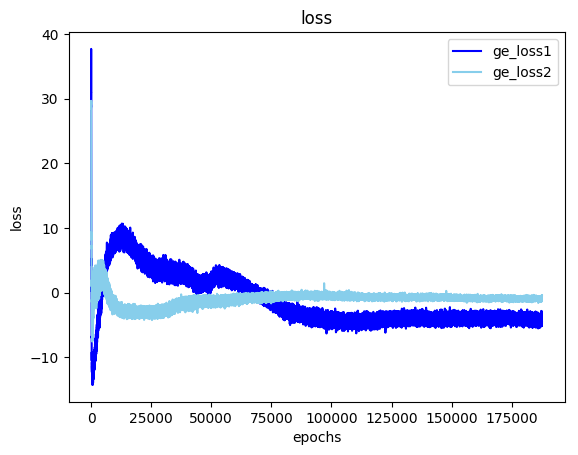

In [48]:
draw_loss(ge1, ge2, d1, d2, run_dir)

In [49]:
def save_net(net, dir):
    tar_f = os.path.join(dir, 'net.pt')
    torch.save(net.state_dict(), tar_f)
    print('net saved in {}'.format(tar_f))

In [50]:
save_net(net, run_dir)

net saved in ./out/lbp_glcm_005_0_wass_e200_b64_l30_betan110.000_betac110.000_betan210.000_betac210.000/net.pt


# Evaluate

In [57]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors

In [58]:
def softmax2argmax(x):
    res = torch.argmax(x, dim=1)
    return res

In [59]:
def vote_score(y_true, y_pred):
    y_voted_labels = np.zeros(y_true.shape)#创建投票标签列列
    labels = np.unique(y_true) #获取真实值中有几个唯一的标签 类似set()
    ordered_labels = np.arange(labels.shape[0]) # 有序标签
    for k in range(labels.shape[0]):
        y_true[y_true==labels[k]] = ordered_labels[k]
    labels = np.unique(y_true)
    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0)
    for cluster in np.unique(y_pred):
        hist, _ = np.histogram(y_true[y_pred==cluster], bins=bins)
        winner = np.argmax(hist)
        y_voted_labels[y_pred==cluster] = winner

    return y_true, y_voted_labels

In [60]:
def attr_anom(zn):
    nei = NearestNeighbors(n_neighbors=2).fit(zn)
    distance, _ = nei.kneighbors(zn)
    score = distance[:, 1]
    return score

In [62]:
# view_num = 2
# latent_dim = 30
# cls_num = 10
# x_shape = (1, 28, 28)
# dataset = 'mnist'
# feat1 = 'lbp'
# feat2 = 'glcm'
# anom = '005_100'
# wass = True
# net_f = '/home/rain/ClusterGAN/out/lbp_glcm_005_100_wass_e200_b64_l30_betan110.000_betac110.000_betan210.000_betac210.000/net.pt'
# net = MultiNet_mnist(view_num=view_num, latent_dim=latent_dim, cls_num=cls_num, x_shape=x_shape, wass=wass)
# net.load_state_dict(torch.load(net_f, map_location=lambda storage, loc: storage))

In [63]:
device_id = 0
if cuda: 
    torch.cuda.set_device(device_id)

In [64]:
net_ = net
net_.to('cpu')
net_.eval()
# if cuda:
#     net.cuda()
loader = dataloader_v2(dataset=dataset, anom=anom, feat1=feat1, feat2=feat2, batch=60000, shuffle=False)

data1, data2, labels = next(iter(loader))
data = (data1, data2)
enc = net_(data=data, mode='E')
enc_labels1 = softmax2argmax(enc[0][1]).cpu().numpy()
enc_labels2 = softmax2argmax(enc[1][1]).cpu().numpy()

In [65]:
labels[200:300]

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

In [66]:
enc_labels1[100:200],enc_labels2[100:200]

(array([6, 2, 0, 2, 2, 9, 7, 4, 4, 8, 9, 2, 0, 2, 3, 0, 8, 5, 9, 7, 4, 2,
        6, 4, 5, 1, 8, 9, 0, 6, 0, 0, 0, 0, 7, 6, 9, 9, 5, 5, 4, 7, 4, 7,
        0, 8, 7, 6, 8, 7, 4, 6, 3, 0, 9, 5, 6, 8, 4, 9, 7, 6, 1, 7, 9, 8,
        9, 7, 3, 3, 2, 3, 1, 9, 0, 1, 0, 4, 2, 9, 5, 0, 5, 6, 2, 1, 0, 5,
        4, 8, 2, 7, 2, 0, 0, 6, 3, 2, 9, 6]),
 array([5, 5, 0, 5, 5, 0, 5, 6, 8, 5, 7, 5, 0, 0, 5, 5, 5, 0, 5, 5, 2, 0,
        3, 5, 0, 6, 5, 5, 0, 6, 0, 5, 1, 5, 6, 6, 0, 6, 5, 5, 2, 5, 5, 0,
        0, 5, 6, 5, 5, 0, 0, 5, 0, 5, 5, 1, 5, 6, 8, 2, 5, 0, 5, 5, 0, 5,
        5, 5, 0, 5, 5, 5, 5, 0, 0, 5, 5, 6, 5, 6, 3, 5, 0, 5, 2, 5, 7, 0,
        5, 0, 0, 5, 5, 5, 5, 5, 5, 6, 0, 0]))

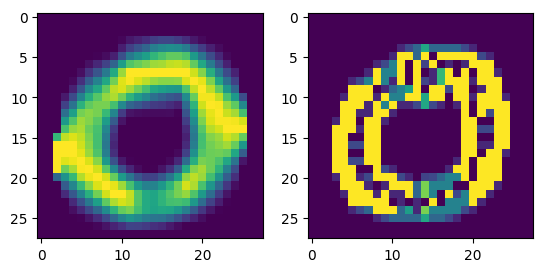

In [67]:
import matplotlib.pyplot as plt

i = 206

# 创建一个包含两个子图的画布
fig, axes = plt.subplots(1, 2)

# 绘制第一个子图
axes[0].imshow(data2[i].squeeze().cpu().detach().numpy())

# 绘制第二个子图
axes[1].imshow(data1[i].squeeze().cpu().detach().numpy())

# 显示图形
plt.show()

In [68]:
from time import time
# 计算attr score
# t1 = time()
# attr_score1 = attr_anom(enc[0][0].cpu().detach().numpy())
# attr_score2 = attr_anom(enc[1][0].cpu().detach().numpy())
# attr_score = attr_score1 + attr_score2
# t2 = time()

# 计算cls score
voted_label1, voted_label2 = vote_score(enc_labels1, enc_labels2)
cls_score = np.zeros([len(labels), ])
for i in range(len(voted_label1)):
    if voted_label1[i] != voted_label2[i]:
        cls_score[i] += 0.5
anom_score =  cls_score#attr_score# attr_score + cls_score
# auc = roc_auc_score(labels, anom_score)
t3 = time()
print('attr cost {}s, cls cost {}s.'.format((t2 - t1), (t3 - t2)))

attr cost 17.94558358192444s, cls cost 1455.1044416427612s.


In [69]:
def find_top_values(array):
    sorted_array = sorted(enumerate(array), key=lambda x: x[1], reverse=True)
    top_values = []
    for i in range(1000):
        index = sorted_array[i][0]
        value = sorted_array[i][1]
        top_values.append((value, index))
    return top_values

# 假设你有一个名为"my_array"的 60000 长度的数组
my_array = anom_score
top_values_with_indices = find_top_values(my_array)

anom_list = []
for value, index in top_values_with_indices:
    anom_list.append(index)
    print(value, index)

0.5 0
0.5 1
0.5 2
0.5 3
0.5 4
0.5 5
0.5 6
0.5 7
0.5 8
0.5 9
0.5 10
0.5 11
0.5 12
0.5 13
0.5 14
0.5 16
0.5 17
0.5 18
0.5 19
0.5 20
0.5 21
0.5 22
0.5 23
0.5 24
0.5 25
0.5 26
0.5 27
0.5 28
0.5 29
0.5 30
0.5 31
0.5 32
0.5 33
0.5 35
0.5 36
0.5 38
0.5 39
0.5 40
0.5 41
0.5 42
0.5 43
0.5 44
0.5 45
0.5 46
0.5 49
0.5 51
0.5 52
0.5 53
0.5 54
0.5 55
0.5 56
0.5 57
0.5 58
0.5 59
0.5 60
0.5 61
0.5 62
0.5 63
0.5 64
0.5 65
0.5 67
0.5 68
0.5 69
0.5 70
0.5 71
0.5 72
0.5 75
0.5 76
0.5 77
0.5 78
0.5 80
0.5 81
0.5 82
0.5 83
0.5 85
0.5 87
0.5 88
0.5 89
0.5 90
0.5 91
0.5 92
0.5 93
0.5 94
0.5 95
0.5 96
0.5 97
0.5 98
0.5 99
0.5 100
0.5 101
0.5 103
0.5 104
0.5 105
0.5 106
0.5 107
0.5 108
0.5 109
0.5 110
0.5 111
0.5 113
0.5 115
0.5 116
0.5 117
0.5 118
0.5 119
0.5 120
0.5 121
0.5 122
0.5 123
0.5 124
0.5 125
0.5 126
0.5 127
0.5 129
0.5 131
0.5 132
0.5 133
0.5 134
0.5 135
0.5 136
0.5 137
0.5 138
0.5 139
0.5 140
0.5 141
0.5 142
0.5 143
0.5 145
0.5 146
0.5 147
0.5 148
0.5 149
0.5 150
0.5 151
0.5 152
0.5 153
0.5 154
0.

# 训练结果可视化

In [61]:
net.cuda()
net.eval()
eval_num = 25
zn, zc, _ = sample_z(shape=eval_num, latent_dim=net.latent_dim, n_c=net.cls_num)
zn, zc = zn.cuda(), zc.cuda()

In [62]:
zn = [zn for _ in range(net.view_num)]
zc = [zc for _ in range(net.view_num)]
gen_imgs = net(zn=zn, zc=zc, mode='G')

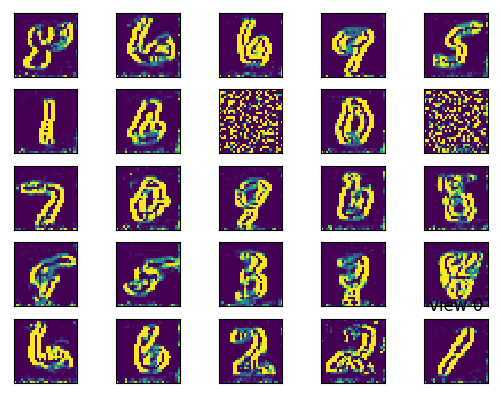

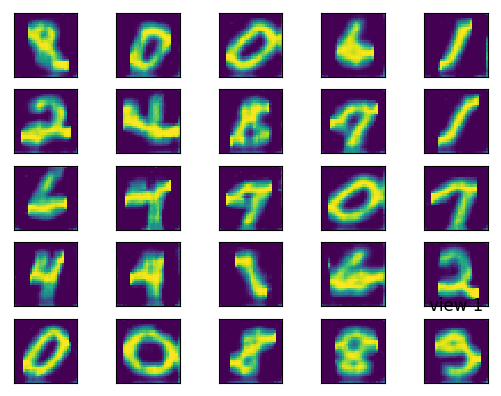

In [63]:
for view in range(net.view_num):
    for i in range(eval_num):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(gen_imgs[view][i].squeeze().cpu().detach().numpy())
    plt.title('view {}'.format(view))
#     tar_f = os.path.join(dir, 'net{}_gen_{}.png'.format(view, epoch))
#     plt.savefig(tar_f)
    plt.show()

In [64]:
# 使用TSNE进行降维可视化
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.cm as cm
# 使用PCA主成分分析进行初始化 再降到2维
tsne = TSNE(n_components=2, verbose=1, init='pca', random_state=42)

In [65]:
_, labels = torch.load("./datasets/mnist/MNIST/processed/mnist_ori.pt")

In [66]:
net_ = net
net_.to('cpu')
net_.eval()
# if cuda:
#     net.cuda()
loader = dataloader_v2(dataset=dataset, anom=anom, feat1=feat1, feat2=feat2, batch=60000, shuffle=False)

data1, data2, labels = next(iter(loader))
data = (data1, data2)
enc = net_(data=data, mode='E')
enc_labels1 = softmax2argmax(enc[0][1]).cpu().numpy()
enc_labels2 = softmax2argmax(enc[1][1]).cpu().numpy()

In [67]:
enc = np.hstack((enc[0][0].cpu().detach().numpy(), enc[0][1].cpu().detach().numpy()))
tsne_enc = tsne.fit_transform(enc)


/home/rain/anaconda3/envs/MVADG/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.002s...
[t-SNE] Computed neighbors for 60000 samples in 75.695s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for sa

/home/rain/anaconda3/envs/MVADG/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.835663
[t-SNE] KL divergence after 1000 iterations: 2.617380


In [68]:
nr_c = 2

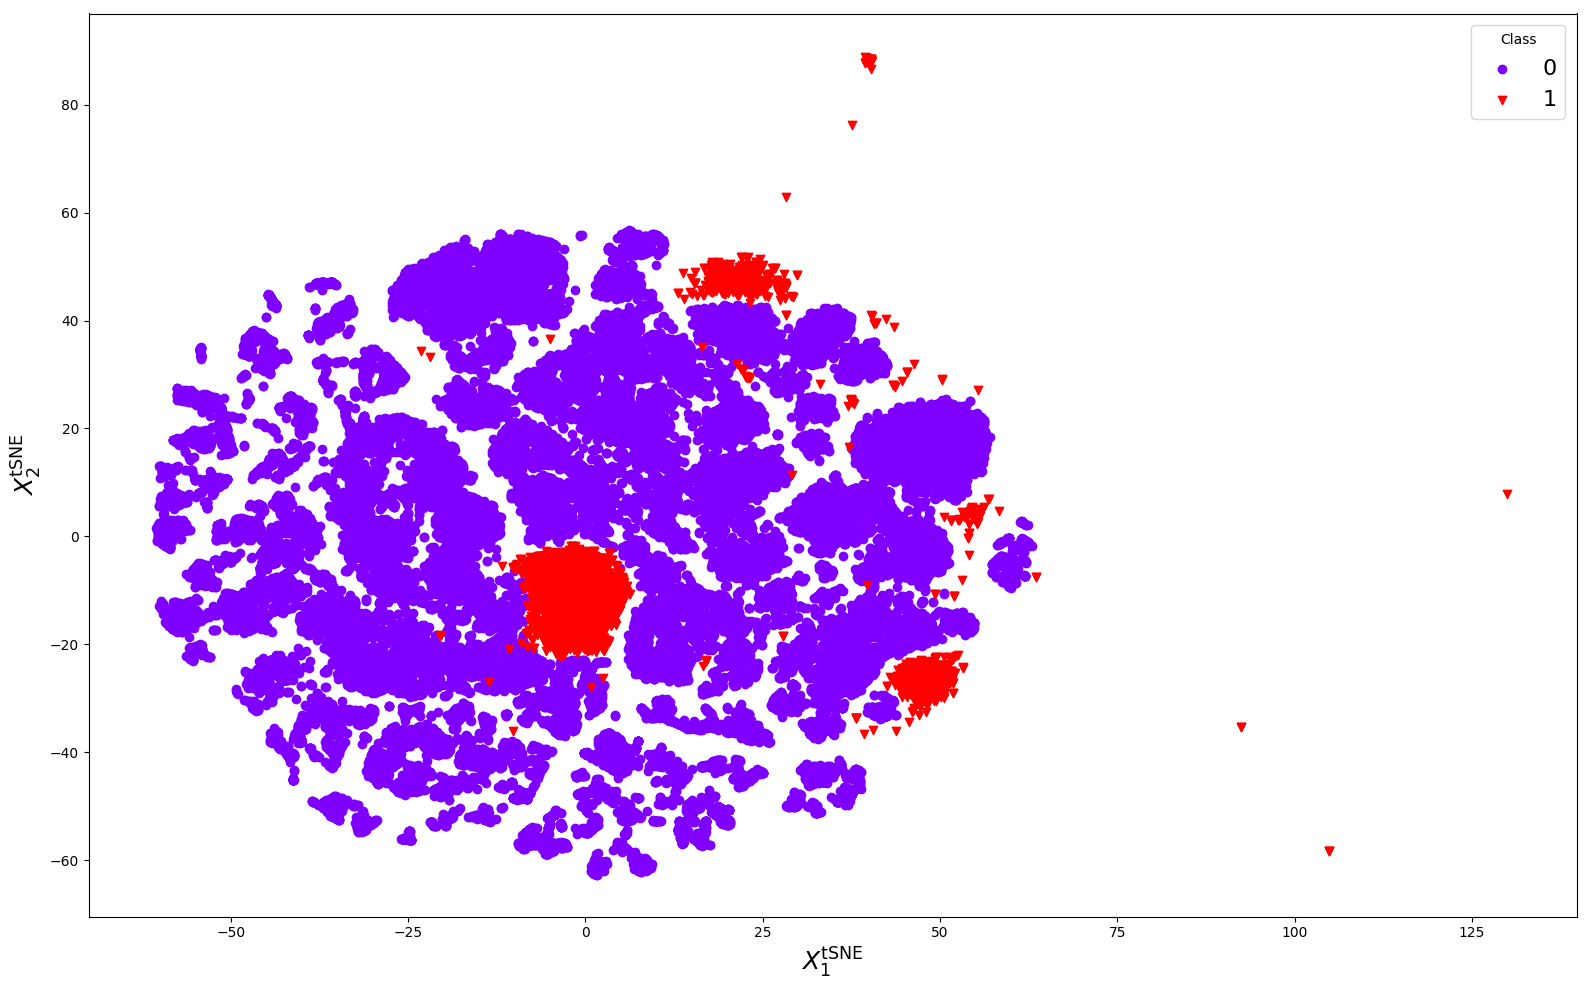

In [69]:
colors = cm.rainbow(np.linspace(0, 1, nr_c))
markers = matplotlib.markers.MarkerStyle.filled_markers

    # Save TSNE figure to file
fig, ax = plt.subplots(figsize=(16,10))
for iclass in range(0, nr_c):
        # Get indices for each class
    idxs = labels==iclass
        # Scatter those points in tsne dims
    ax.scatter(tsne_enc[idxs, 0],
                tsne_enc[idxs, 1],
                marker=markers[iclass],
                c=colors[iclass],
                edgecolor=None,
                label=r'$%i$'%iclass)

    #ax.set_title(r'%s'%fig_title, fontsize=24)
    ax.set_xlabel(r'$X^{\mathrm{tSNE}}_1$', fontsize=18)
    ax.set_ylabel(r'$X^{\mathrm{tSNE}}_2$', fontsize=18)
    plt.legend(title=r'Class', loc='best', numpoints=1, fontsize=16)
    plt.tight_layout()
    fig.savefig('tsne-pca.png')